###  Generates engineering drawings for the transverse dimensions of every single layer of HG-CALI, as well as the backplanes

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, matplotlib as mpl
import random

from shapely import Polygon
import mplhep as hep

hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

In [2]:
import design_parameters as dp
beampipe0=dp.beampipe0

In [3]:
def dimension(x, y, slashlength=1, position_ratio=0.5):
    #draw line
    plt.plot(x, y,color='0.5', linestyle='-')
    #draw slashes
    for i in 0,1:
        plt.plot([x[i]-slashlength/2, x[i]+slashlength/2], 
                 [y[i]-slashlength/2, y[i]+slashlength/2], color='0.5', linestyle='-', linewidth=3)

    #now write the dimension
    dist = np.hypot(x[1]-x[0], y[1]-y[0])
    pr=position_ratio
    phi=-np.arctan2(y[1]-y[0], x[1]-x[0])
    plt.text(x[0]*pr+x[1]*(1-pr), y[0]*pr+y[1]*(1-pr), 
             f"{dist:.2f} cm\n{dist/2.54:.2f}\"", ha='center', va='center',
            rotation=phi*180/np.pi)

In [4]:

def engineering_diagram(layer, beampipe=dp.beampipe0, height=dp.det_height, width=dp.det_width,
                        gap=dp.det_gap, backplanes_in_holes=False):
    fig, ax=plt.subplots(1,1,figsize=(16,16))
    plt.text(-10, 27, f"Layer {layer}", ha='center', fontsize=40)
    phi = np.linspace(-np.pi, np.pi, 7)
    boundaries={}
    for side in "LR":
        boundaries[side]=dp.layer_boundaries(layer, side, beampipe=beampipe, height=height, width=width, 
                                          backplanes_in_holes=backplanes_in_holes)
        
        plt.plot(*boundaries[side].exterior.xy, linestyle='-', color='k', linewidth=2)
        plt.fill(*boundaries[side].exterior.xy, color='#33aaff11')
    offset=-10
    
    
    #gap=gap_between_sides+2*gap_for_backplanes
    
    #right to left
    dimension([offset-width/2, offset+width/2], [-height/2+3, -height/2+3])
    
    #top to bottom
    dimension([offset-width/2+5, offset-width/2+5], [height/2, -height/2], position_ratio=0.3)
    
    #right to gap
    dimension([offset-width/2, -gap/2], [22,22])
    
    #left to gap
    dimension([gap/2, offset+width/2], [25,25])
    
    #center to left
    dimension([beampipe.holeX(layer), offset+width/2], [0,0], position_ratio=0.25)
    #center to right
    dimension([offset-width/2, beampipe.holeX(layer)], [0,0], position_ratio=0.6)
    
    phi=0.7*np.pi
    x=beampipe.holeX(layer)
    r=beampipe.holeR(layer)
    #center to hole
    dimension([x+np.cos(phi)*r,x], [np.sin(phi)*r,0])
    
    #now show the gap dimensions using inward-pointing arrows
    arg=dict(color='0.5', linestyle='-')
    h=-24 #height of where the dimension goes
    ah=0.5 #arrowhead
    plt.plot([-2, -gap/2], [h, h], **arg)
    plt.plot([-gap/2-ah, -gap/2, -gap/2-ah], [h+ah, h, h-ah],**arg)
    
    plt.plot([2, gap/2], [h, h],**arg)
    plt.plot([gap/2+ah, gap/2, gap/2+ah], [h+ah, h, h-ah],**arg)
    
    plt.text(6, h, f"{gap:.2f} cm\n{gap/2.54:.2f}\"", va='center', ha='center')
    
    
    if  backplanes_in_holes:
        #now show the dimension for the additional gap for the inner backplanes:
        ah=0.5 #arrowhead
        holeX=beampipe.holeX(layer)
        holeR=beampipe.holeR(layer)
        shift=-2
        plt.plot([holeX-shift]*2, [holeR, holeR-2], **arg)
        plt.plot([holeX-shift-ah, holeX-shift, holeX-shift+ah], [holeR-ah, holeR, holeR-ah], **arg)

        plt.plot([holeX-shift]*2, [holeR+gap_for_backplanes, holeR+gap_for_backplanes+2], **arg)
        plt.plot([holeX-shift-ah, holeX-shift, holeX-shift+ah], 
                 [holeR+gap_for_backplanes+ah, holeR+gap_for_backplanes, holeR+gap_for_backplanes+ah], **arg)

        plt.text(holeX-shift, holeR-5, f"{gap_for_backplanes:.2f} cm\n{gap_for_backplanes/2.54:.2f}\"", va='center', ha='center')

        shift=-3
        dimension([holeX,-gap/2], [-holeR-gap_for_backplanes+shift]*2, position_ratio=0.6)

    
    ax.invert_xaxis()
    ax.axis("off")
    return fig, ax
    #plt.plot(
                #plt.plot(df.x[i]+dx, df.y[i]+dy, color=color)
    

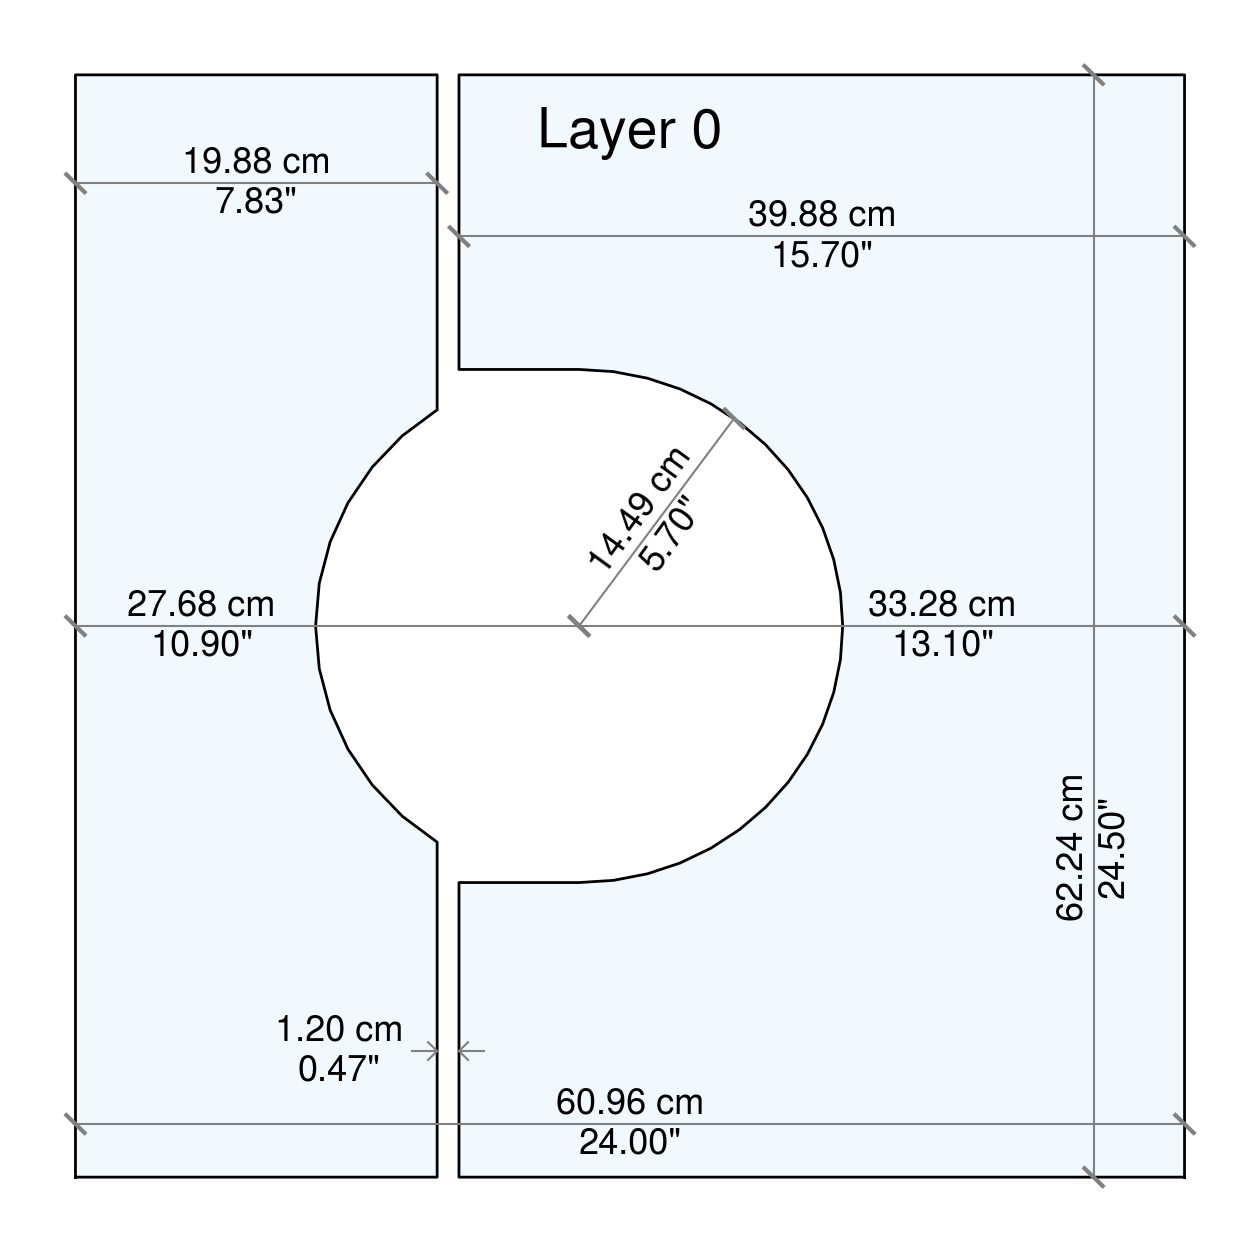

(<Figure size 1600x1600 with 1 Axes>, <AxesSubplot:>)

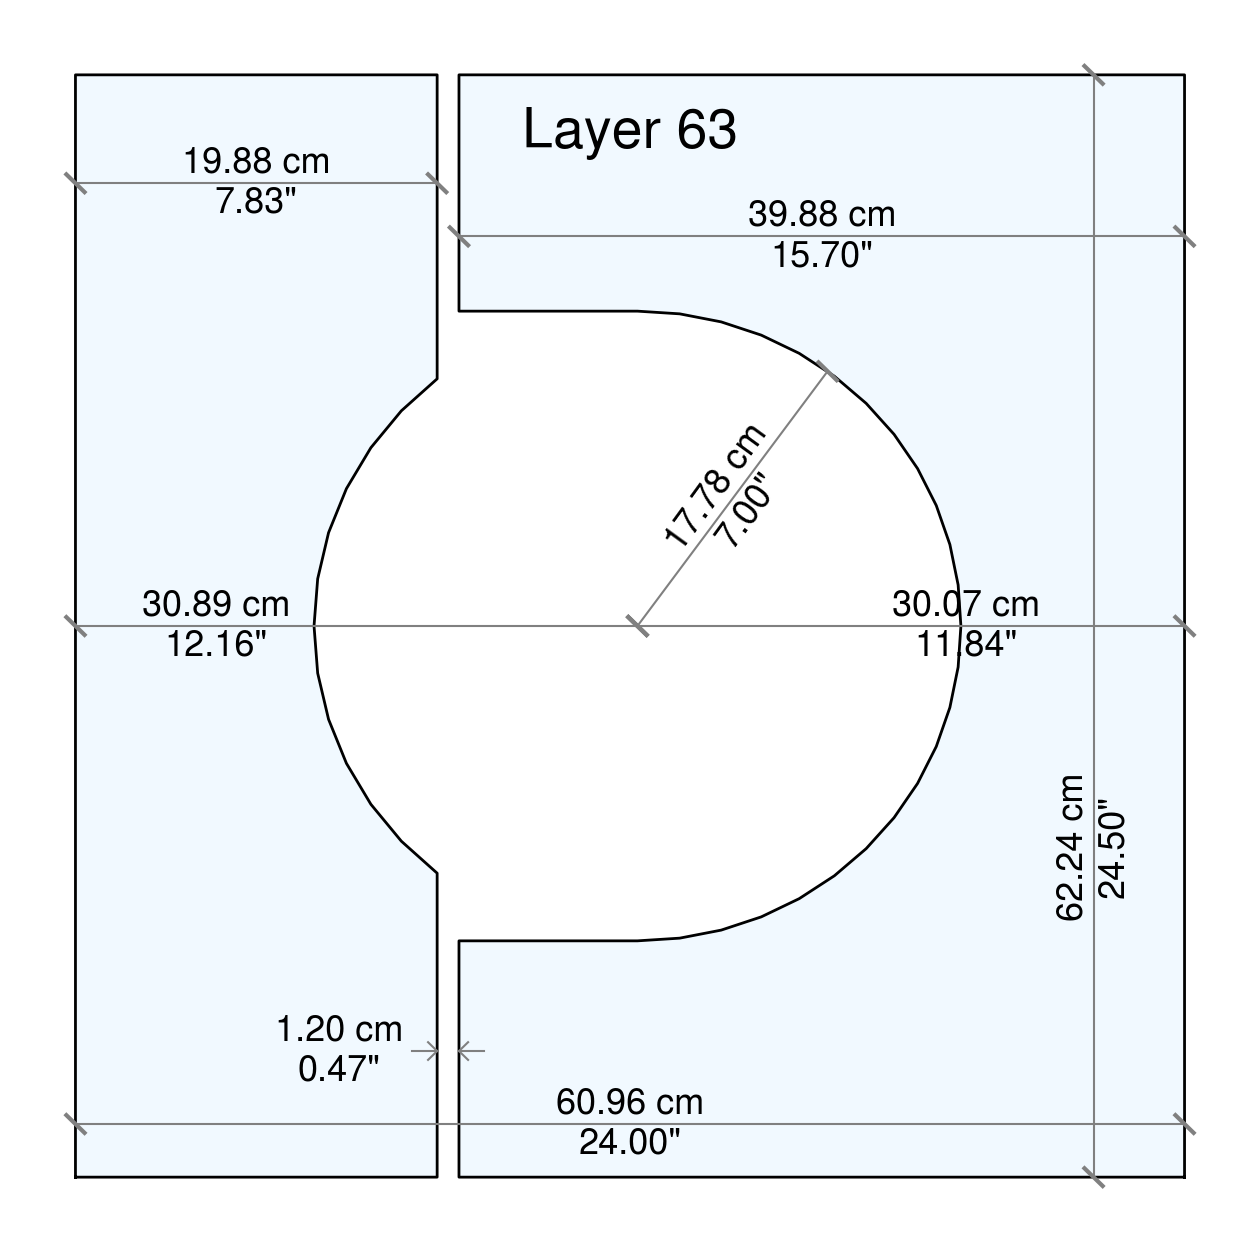

In [5]:
#now show the first and last layers

engineering_diagram(0, width=dp.det_width, height=dp.det_height)
plt.show()
engineering_diagram(dp.n_layers-1, width=dp.det_width, height=dp.det_height)


In [6]:
def draw_backplanes(beampipe=beampipe0,height=dp.det_height, board_shape='rect', include_inner=False):
    
    nabsorbers=dp.n_layers+1
    
    if include_inner:
        fig, axs=plt.subplots(6,1,figsize=(16,16+8), sharex=False)
    else:
        fig, axs=plt.subplots(4,1,figsize=(16,16), sharex=False)
    offset=10
    gap=0.4 #this is the gap between the two halves of the detector, which determines the dimensions of the backplanes
    
    absorber_thickness=1.61
    
    #left top, left bottom, right top, right bottom
    for j in range(4):
        plt.sca(axs[j])
        holeX0=beampipe.holeX(0)
        holeR0=beampipe.holeR(0)
        z0=beampipe.getZ(0)+absorber_thickness
        phi0 = np.arccos((holeX0-gap/2)/holeR0)
        y0=holeR0*np.sin(phi0) if j <2 else holeR0


        holeX1=beampipe.holeX(nabsorbers)
        holeR1=beampipe.holeR(nabsorbers)
        z1=beampipe.getZ(nabsorbers-1)+absorber_thickness
        #print(f"space for downstream connectors: {(z1-z0)} cm")
        #force the length to be 120 cm (maximum available) so that there's space for connectors at the downstream end
        #z1=z0+120
        
        phi1 = np.arccos((holeX1-gap/2)/holeR1)
        y1=holeR1*np.sin(phi1) if j <2 else holeR1

        if board_shape=='rect':
            y0=min(y1, y0)
            y1=y0
        
        arg=dict(linestyle='-', color='k', linewidth=2)
        
        bounds = [z0, z1, z1, z0, z0], [y0, y1, height/2, height/2, y0]
        plt.plot(*bounds, **arg)
        plt.fill(*bounds, color='#33ffaa11')
        
        
        if board_shape=='trap':
            #mark which corners are right angles.  
            a=3
            plt.plot([z0, z0+a, z0+a, z0, z0], [height/2, height/2, height/2-a, height/2-a, height/2],**arg)
            plt.plot([z1, z1-a, z1-a, z1, z1], [height/2, height/2, height/2-a, height/2-a, height/2],**arg)
        
        
        
        dimension([z0-7, z0-7], [height/2, y0])
        dimension([z1+7, z1+7], [height/2, y1])
        dimension([z0,z1],[height/2+7, height/2+7])
        
        axs[j].axis("off")
        axs[j].set_xlim(z0-10, z0+150)
        axs[j].set_ylim(10, 50)
        txt=''
        if j%2:
            if board_shape=='trap':
                axs[j].invert_yaxis()
            txt+="bottom"
        else:
            txt+="top"
        if j<2:
            txt+=" left"
        else:
            if board_shape=='trap':
                axs[j].invert_yaxis()
            txt+=" right"
        
        
        plt.text((z0+z1)/2,(height/2-10) , txt, ha='center', va='center')
    
    if not include_inner:
        return
    #top inner right, bottom inner right
    for j in range(4,6):
        plt.sca(axs[j])
        holeX0=beampipe.holeX(0)
        holeR0=beampipe.holeR(0)
        z0=beampipe.getZ(0)+absorber_thickness
        phi0 = np.arccos((holeX0-gap/2)/holeR0)
        y0=-holeX0


        holeX1=beampipe.holeX(nabsorbers)
        holeR1=beampipe.holeR(nabsorbers)
        z1=beampipe.getZ(nabsorbers-1)+absorber_thickness
        phi1 = np.arccos((holeX1-gap/2)/holeR1)
        y1=-holeX1
        
        if board_shape=='rect':
            y0=min(y1, y0)
            y1=y0

        #take into account the tilt
        z1=z0+(z1-z0)/np.cos(np.arctan((holeR1-holeR0)/(z1-z0)))
        
        #print(f"space for downstream connectors: {120-(z1-z0)} cm")
        #z1=z0+120
        
        print(np.cos(np.arctan((holeR1-holeR0)/(z1-z0))))
        
        arg=dict(linestyle='-', color='k', linewidth=2)
        
        bounds = [z0, z1, z1, z0, z0], [y0, y1, 0, 0, y0]
        plt.plot(*bounds, **arg)
        plt.fill(*bounds, color='#33ffaa11')
        
        
        if board_shape=='trap':
            #mark which corners are right angles.  
            a=3
            plt.plot([z0, z0+a, z0+a, z0, z0], [0, 0, a, a, 0],**arg)
            plt.plot([z1, z1-a, z1-a, z1, z1], [0, 0, a, a, 0],**arg)
        
        
        dimension([z0-7, z0-7], [y0, 0])
        dimension([z1+7, z1+7], [y1, 0])
        dimension([z0,z1],[-7, -7])
        
        axs[j].axis("off")
        axs[j].set_xlim(z0-10, z0+150)
        axs[j].set_ylim(-10, 30)
        txt=''
        if j%2:
            txt+="bottom"
            axs[j].invert_yaxis()
        else:
            txt+="top"
            if board_shape!='trap':
                axs[j].invert_yaxis()
        txt += " inner"
        txt+=" right"
        
        plt.text((z0+z1)/2,(y1+y0)/4 , txt, ha='center', va='center')

0.9996654157831008
0.9996654157831008


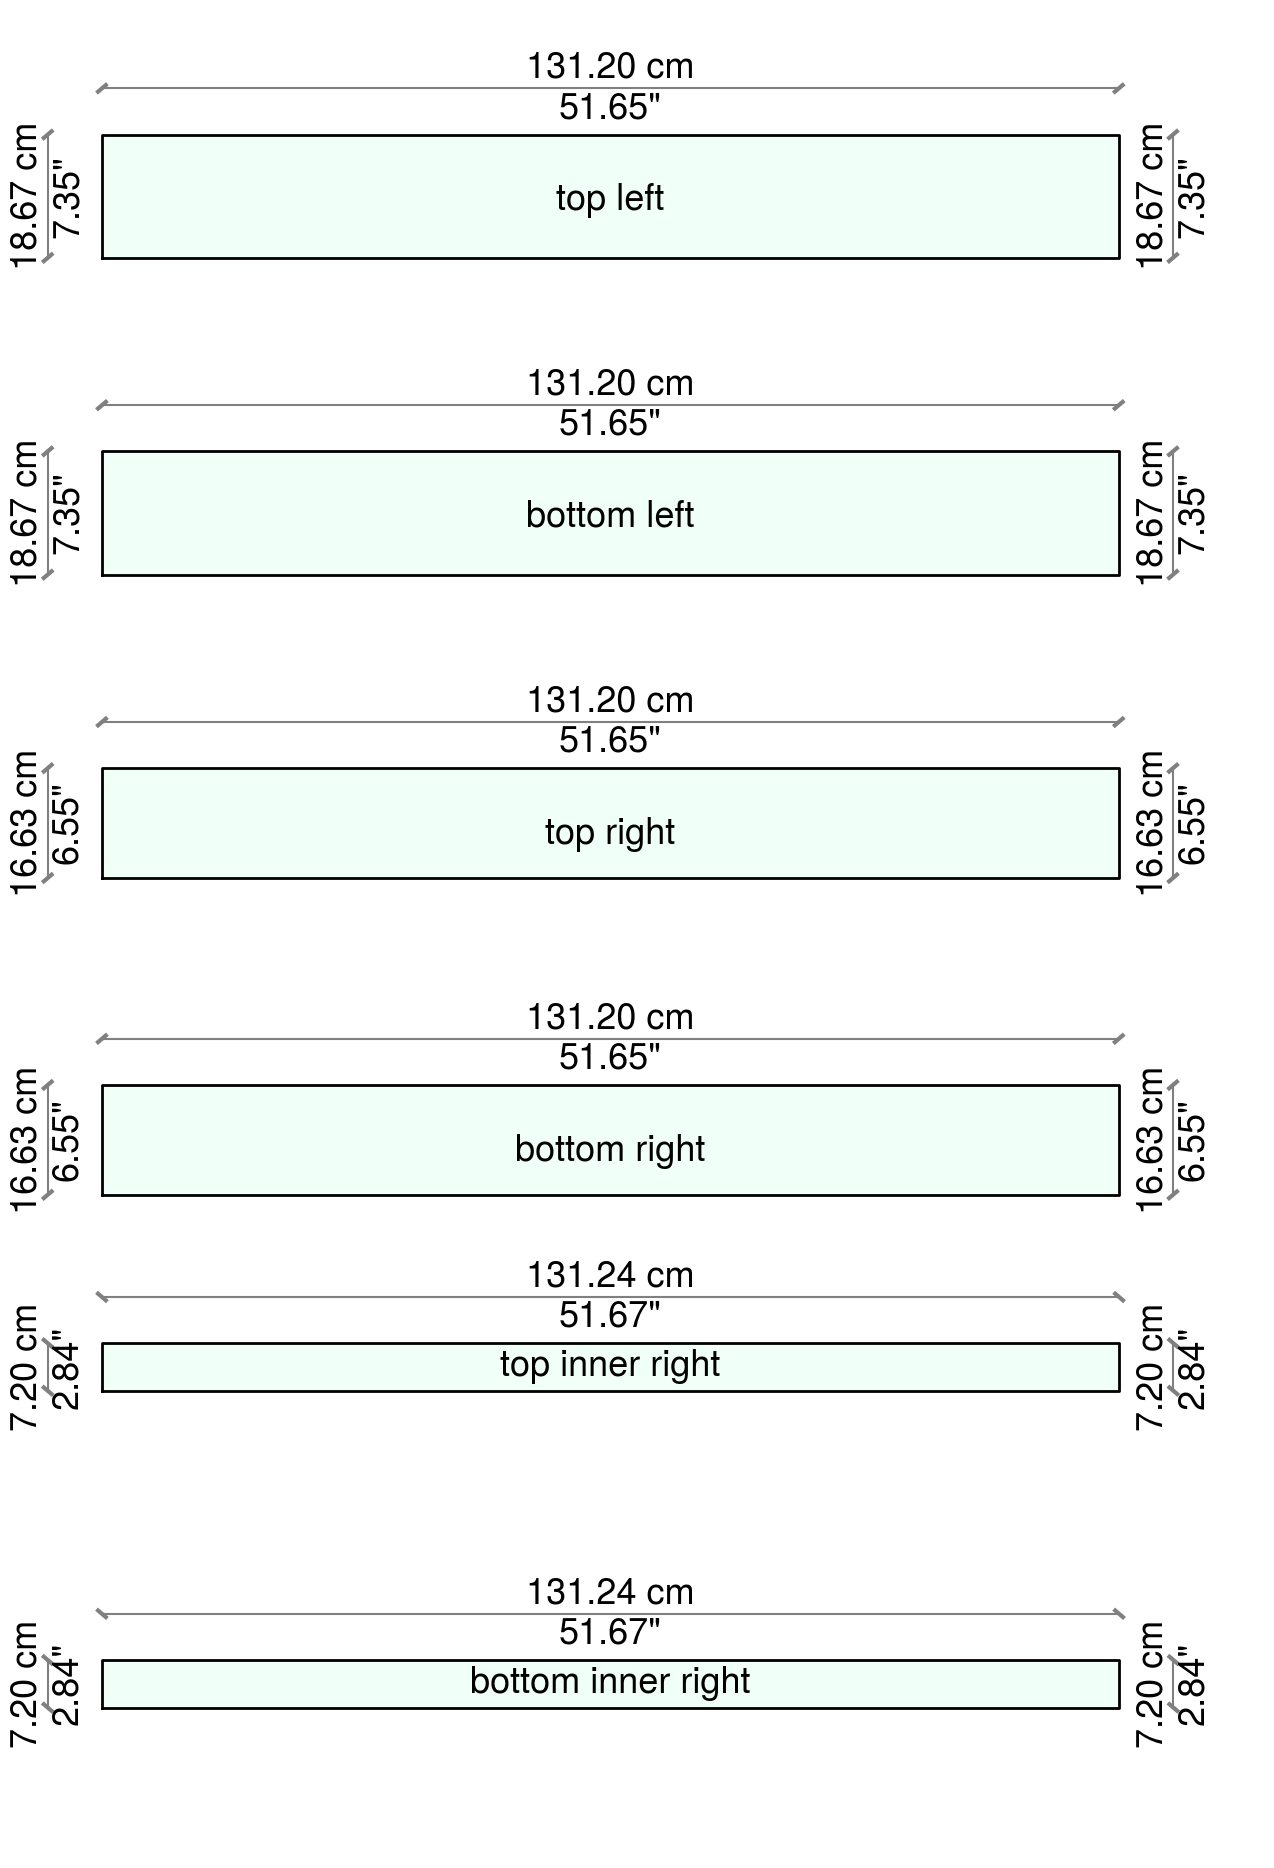

In [7]:
draw_backplanes(include_inner=True)

In [8]:
beampipe0.holeX(np.array([0, 59]))

array([ -7.2047662 , -10.20673431])

/var/folders/_x/mzz2_hcx0dg4mv6b9blzjpp40000gn/T/ipykernel_98466/3405170475.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax=plt.subplots(1,1,figsize=(16,16))


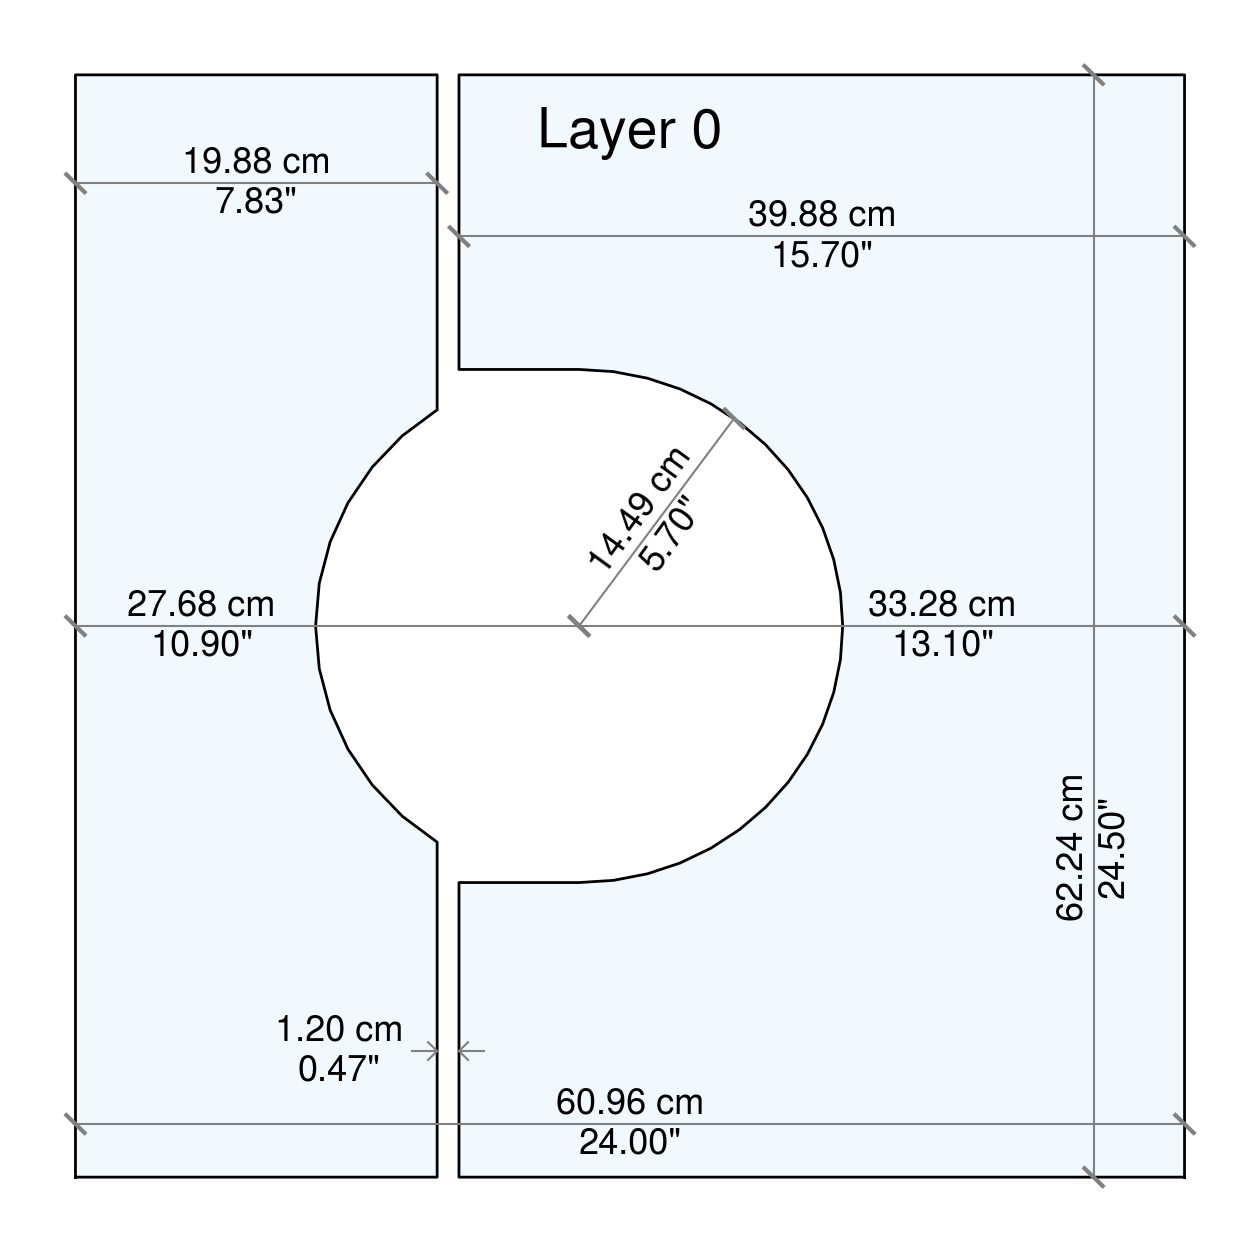

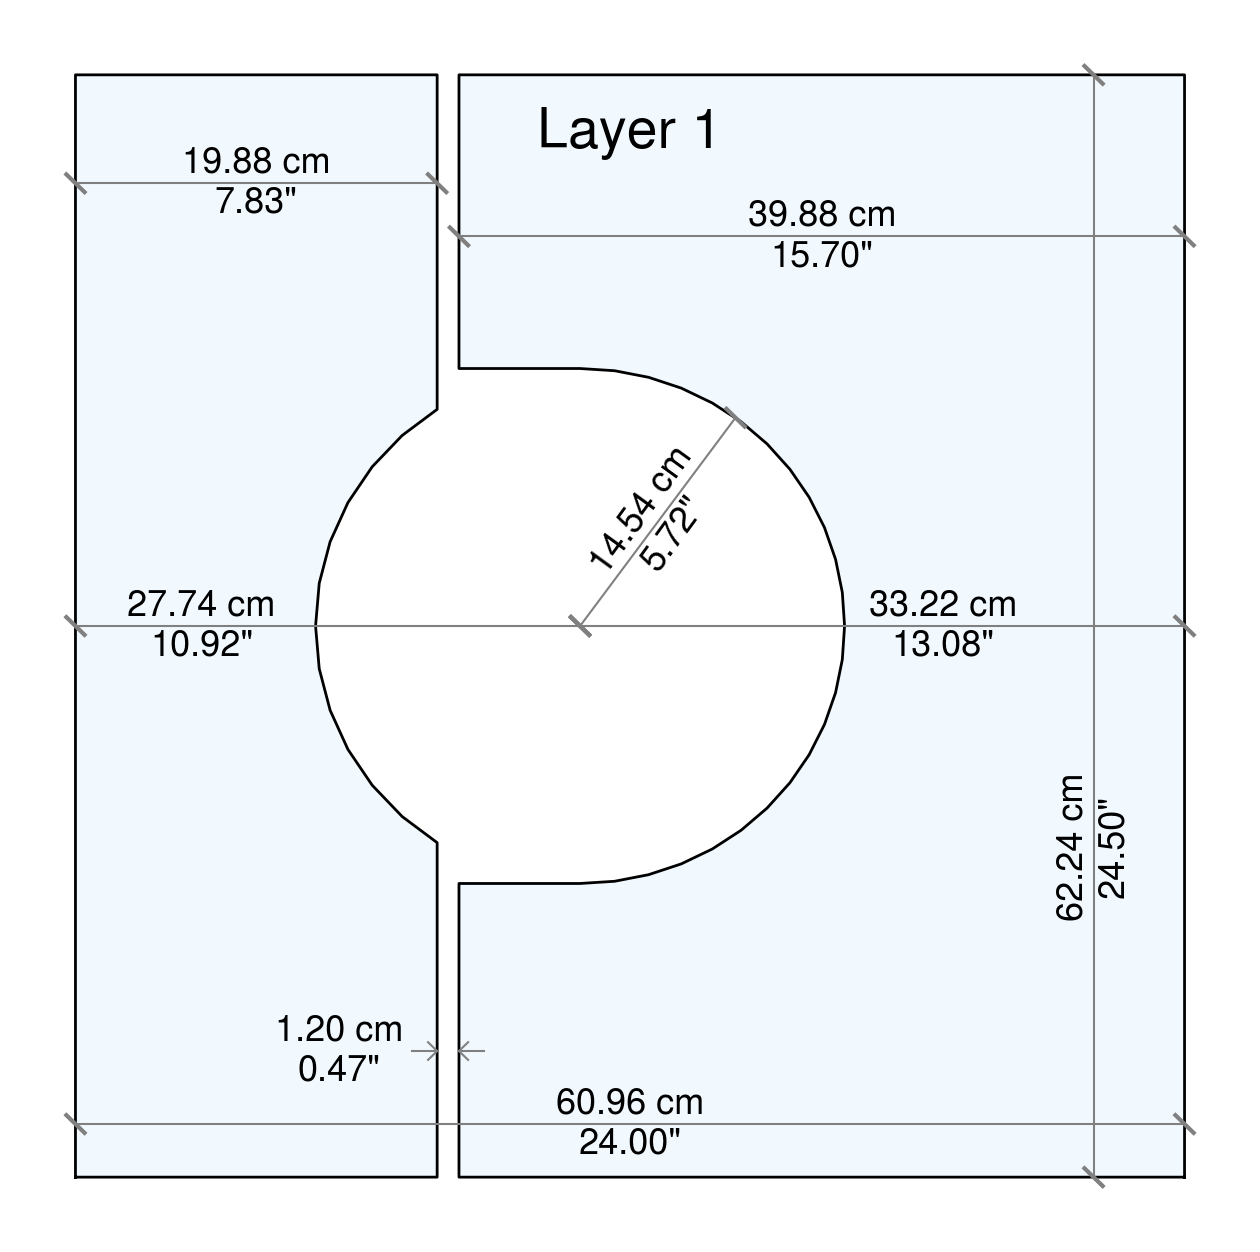

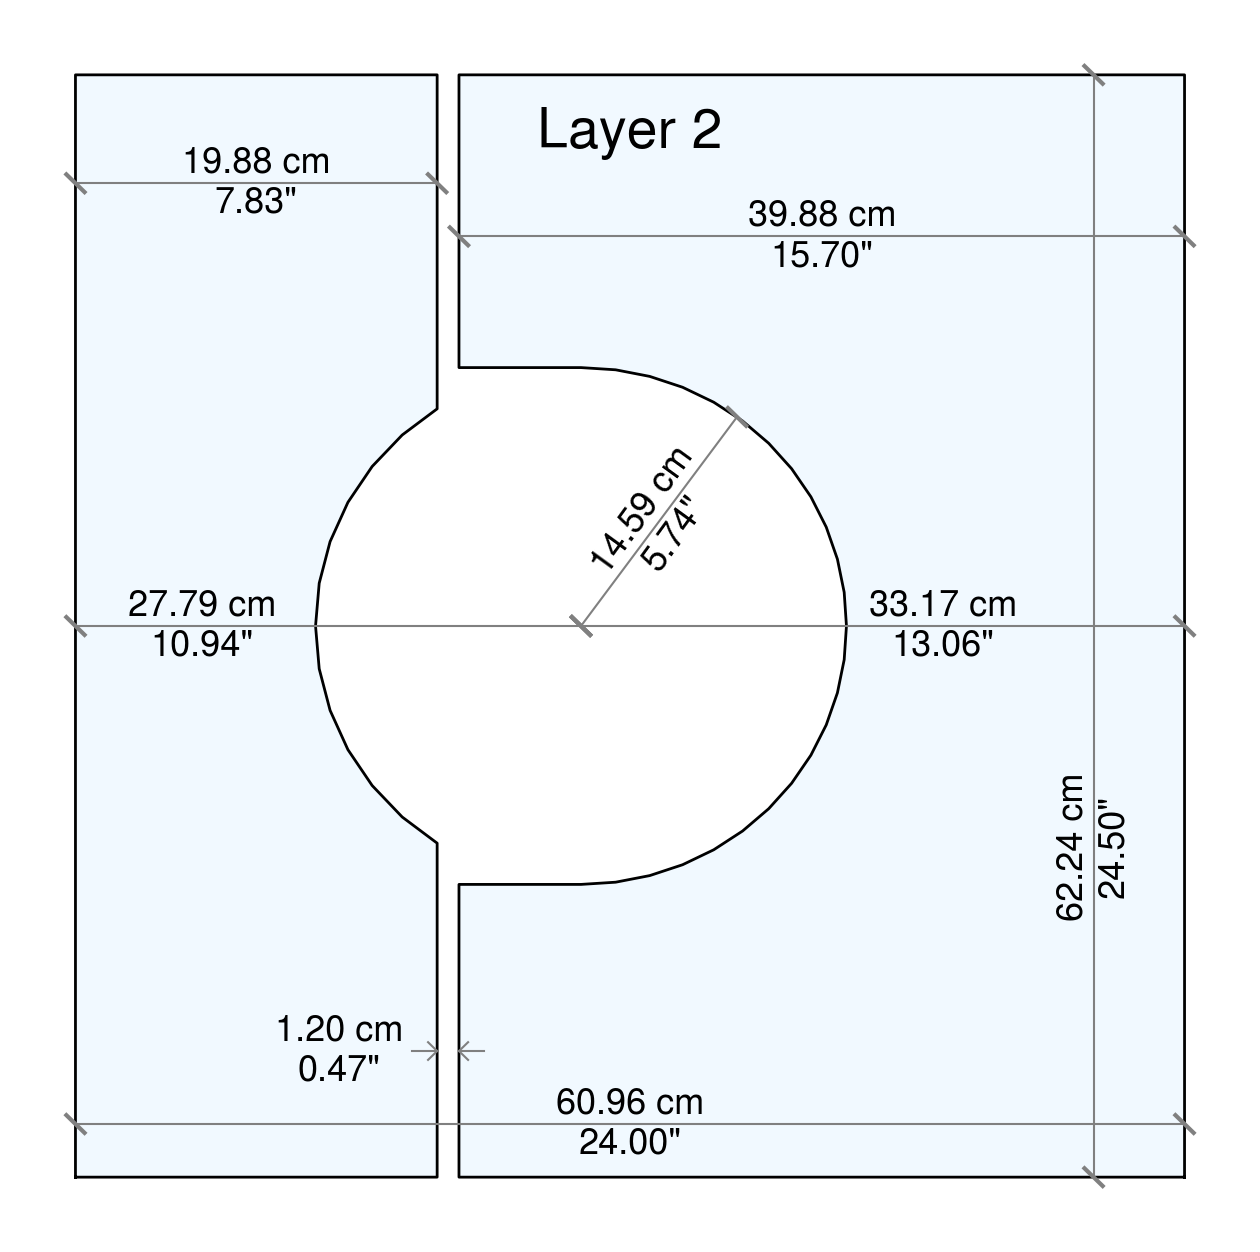

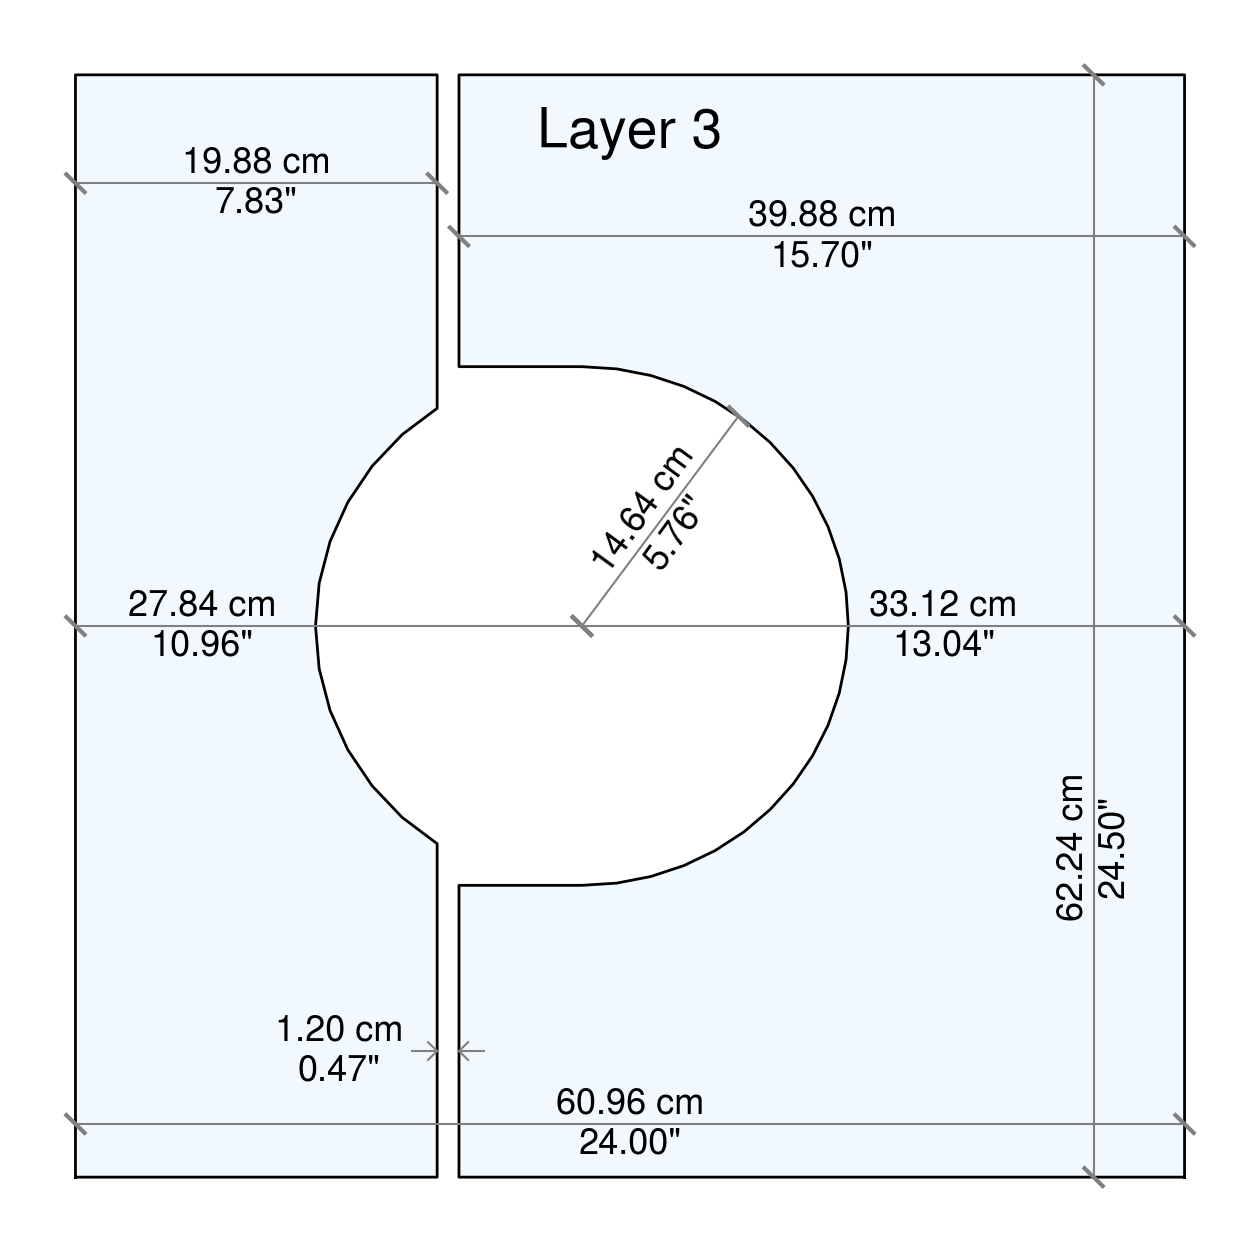

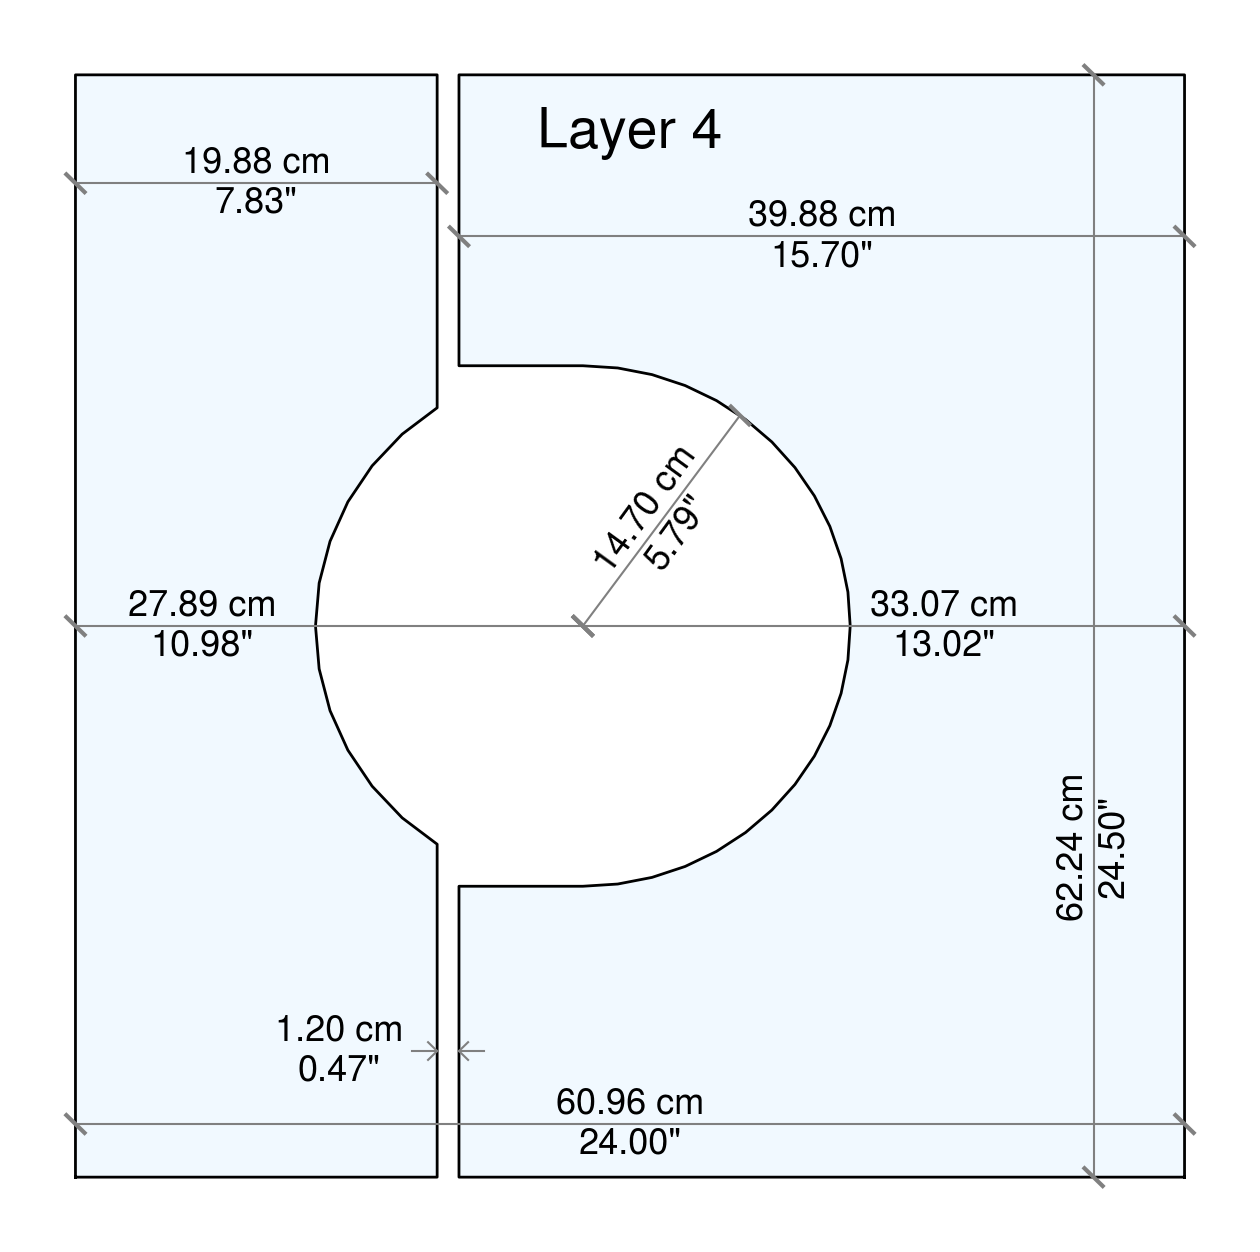

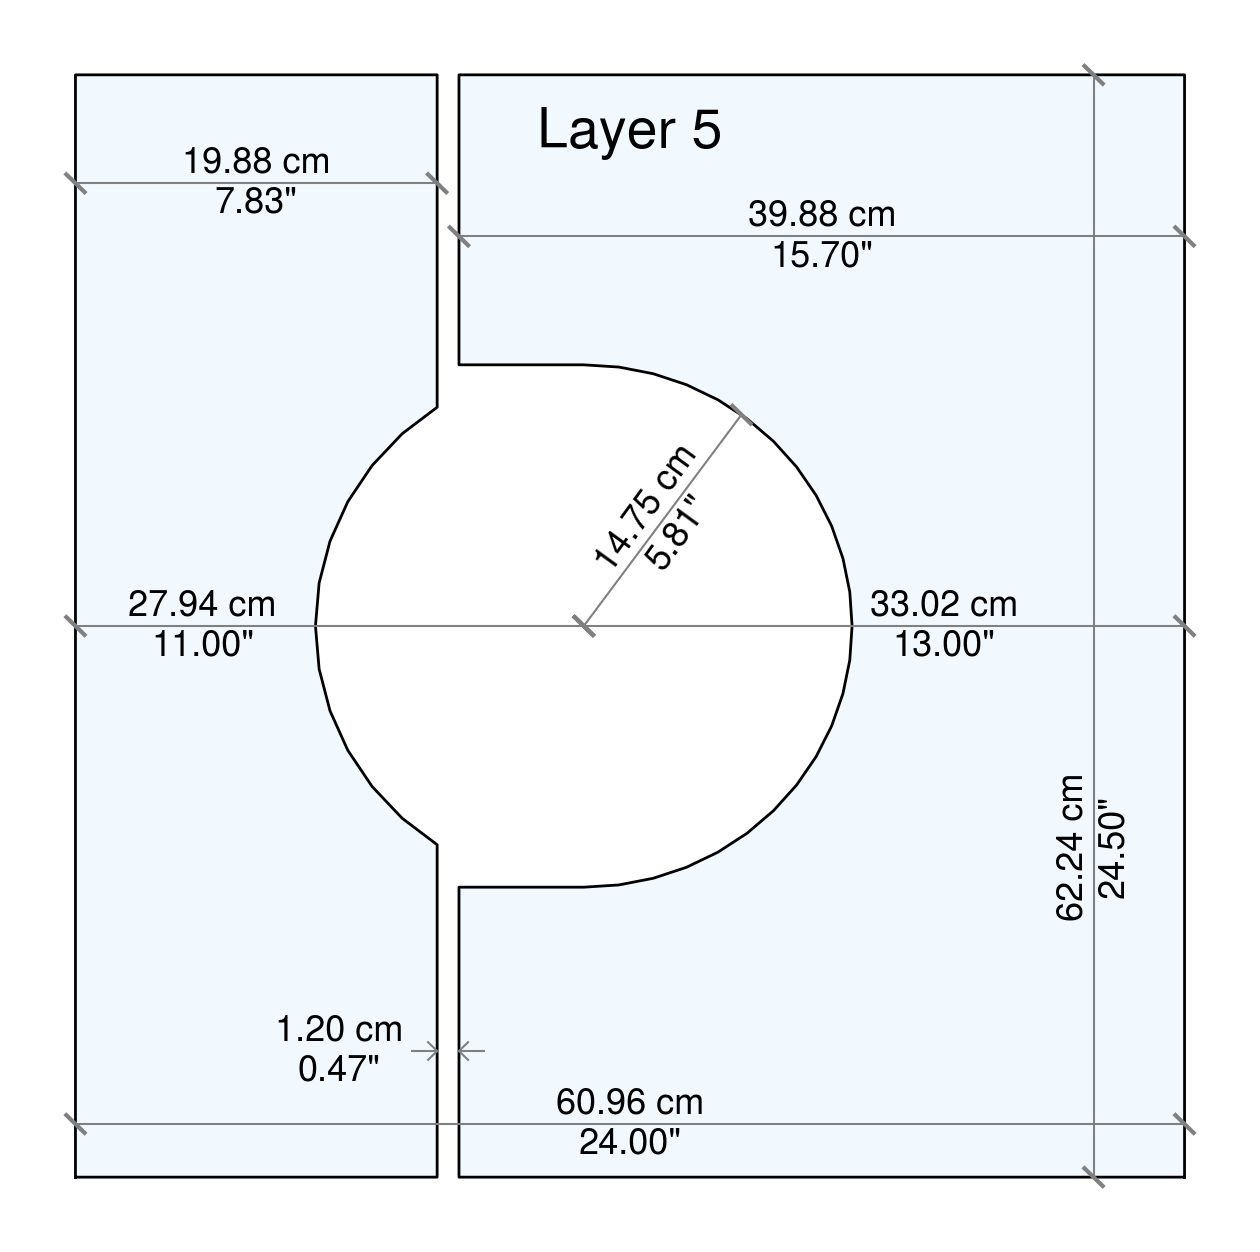

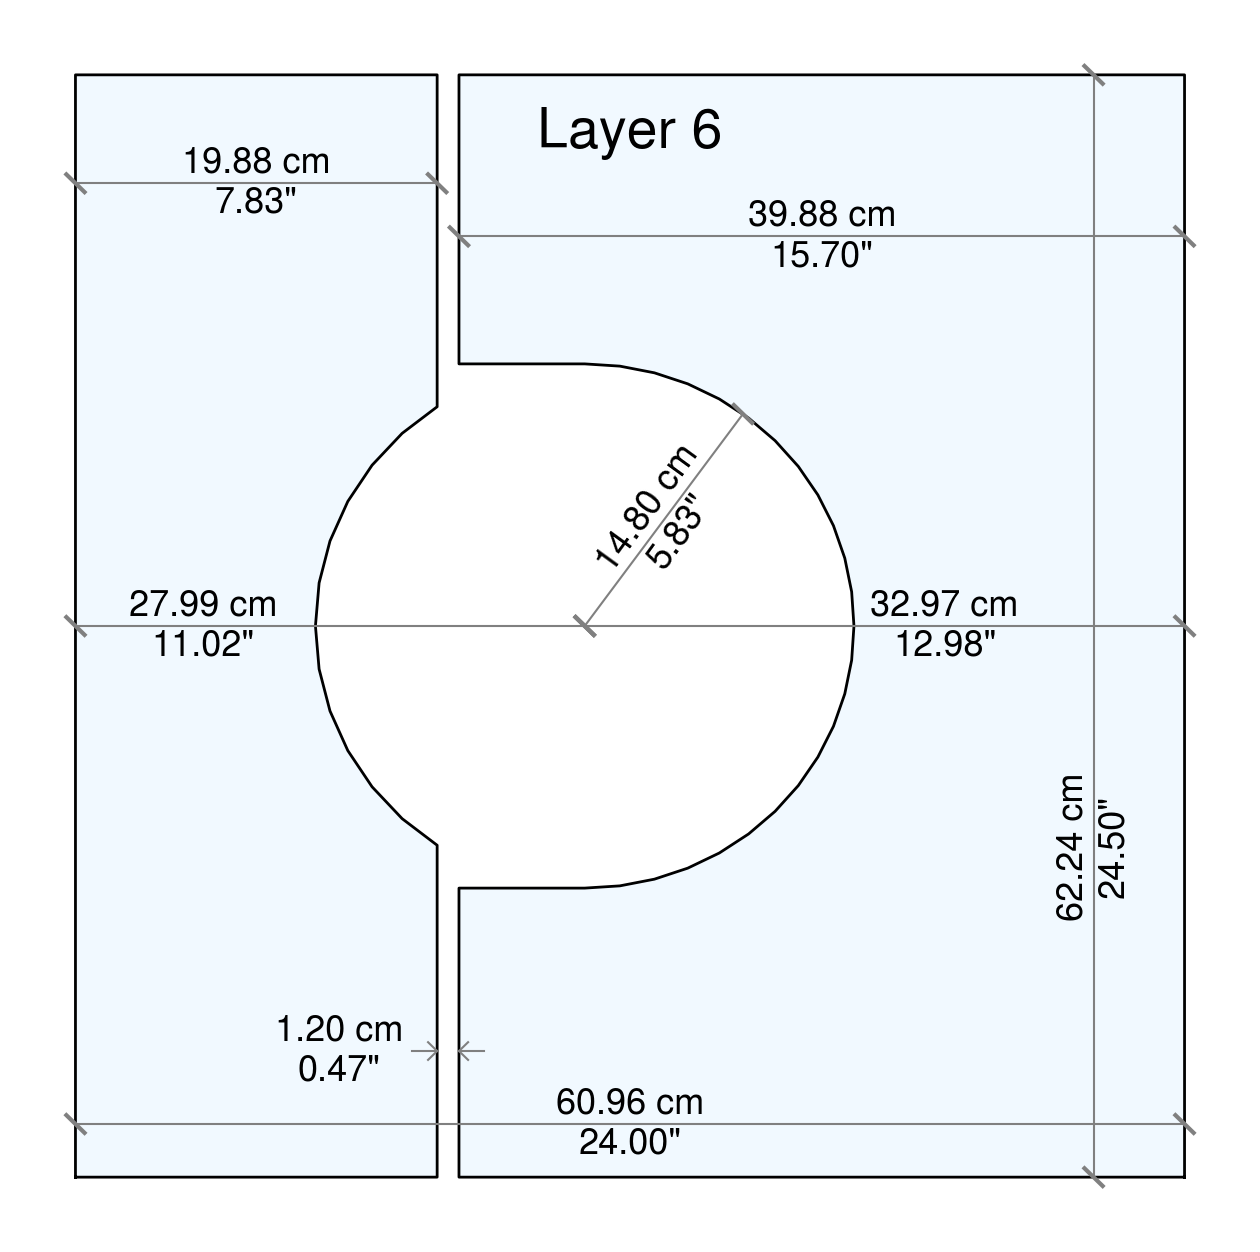

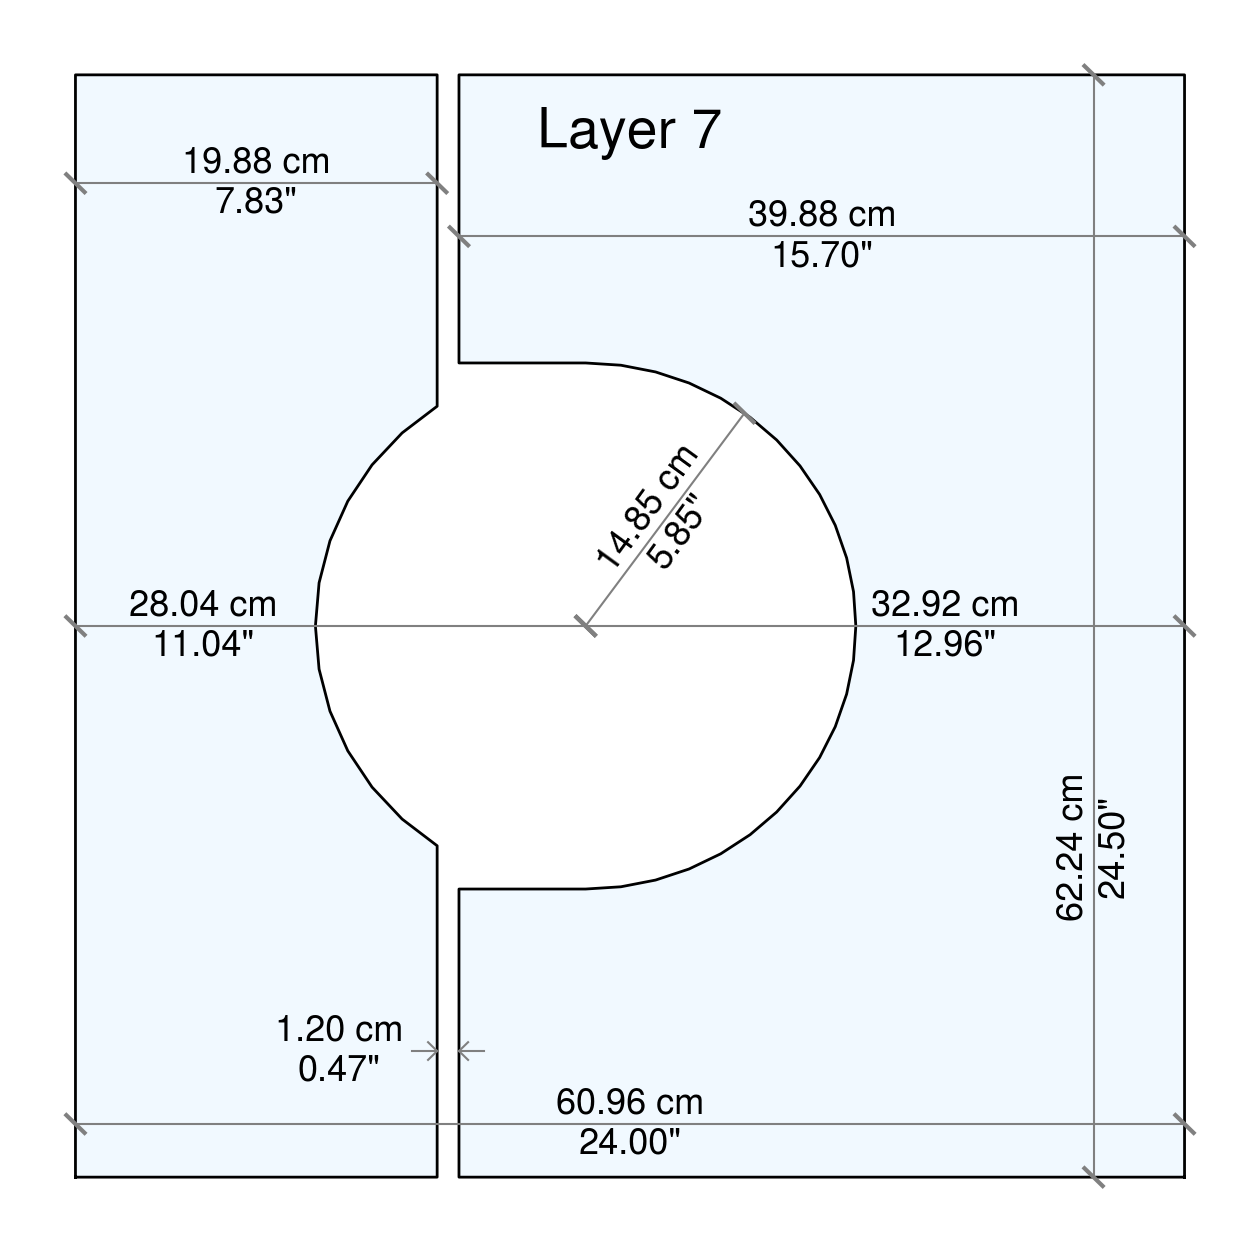

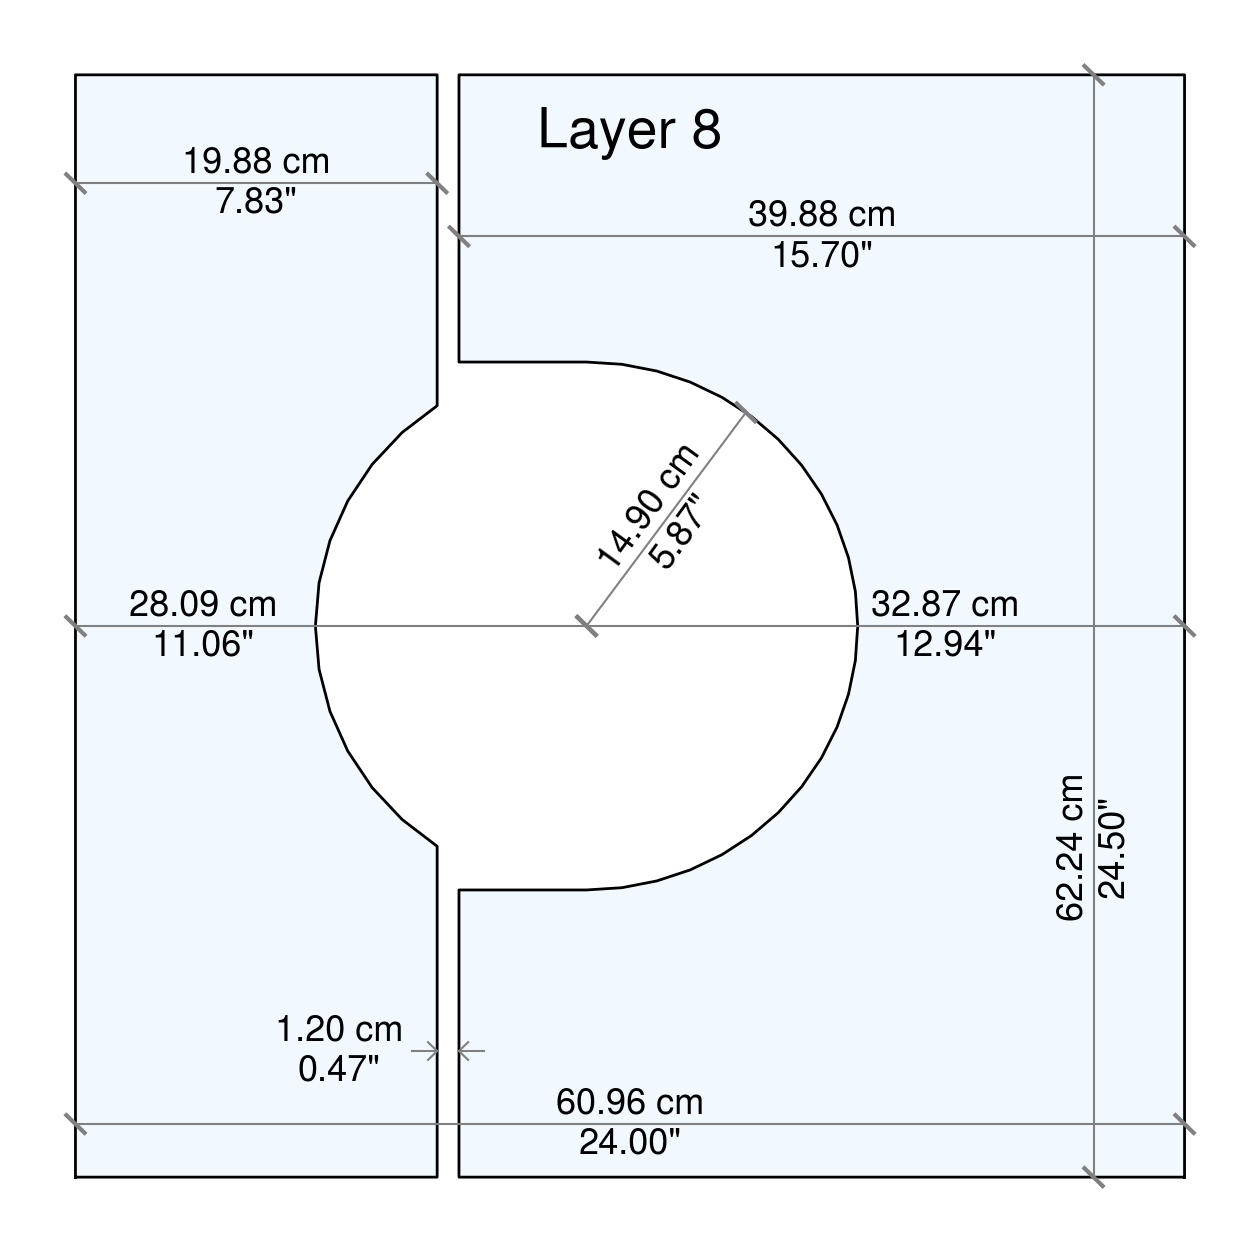

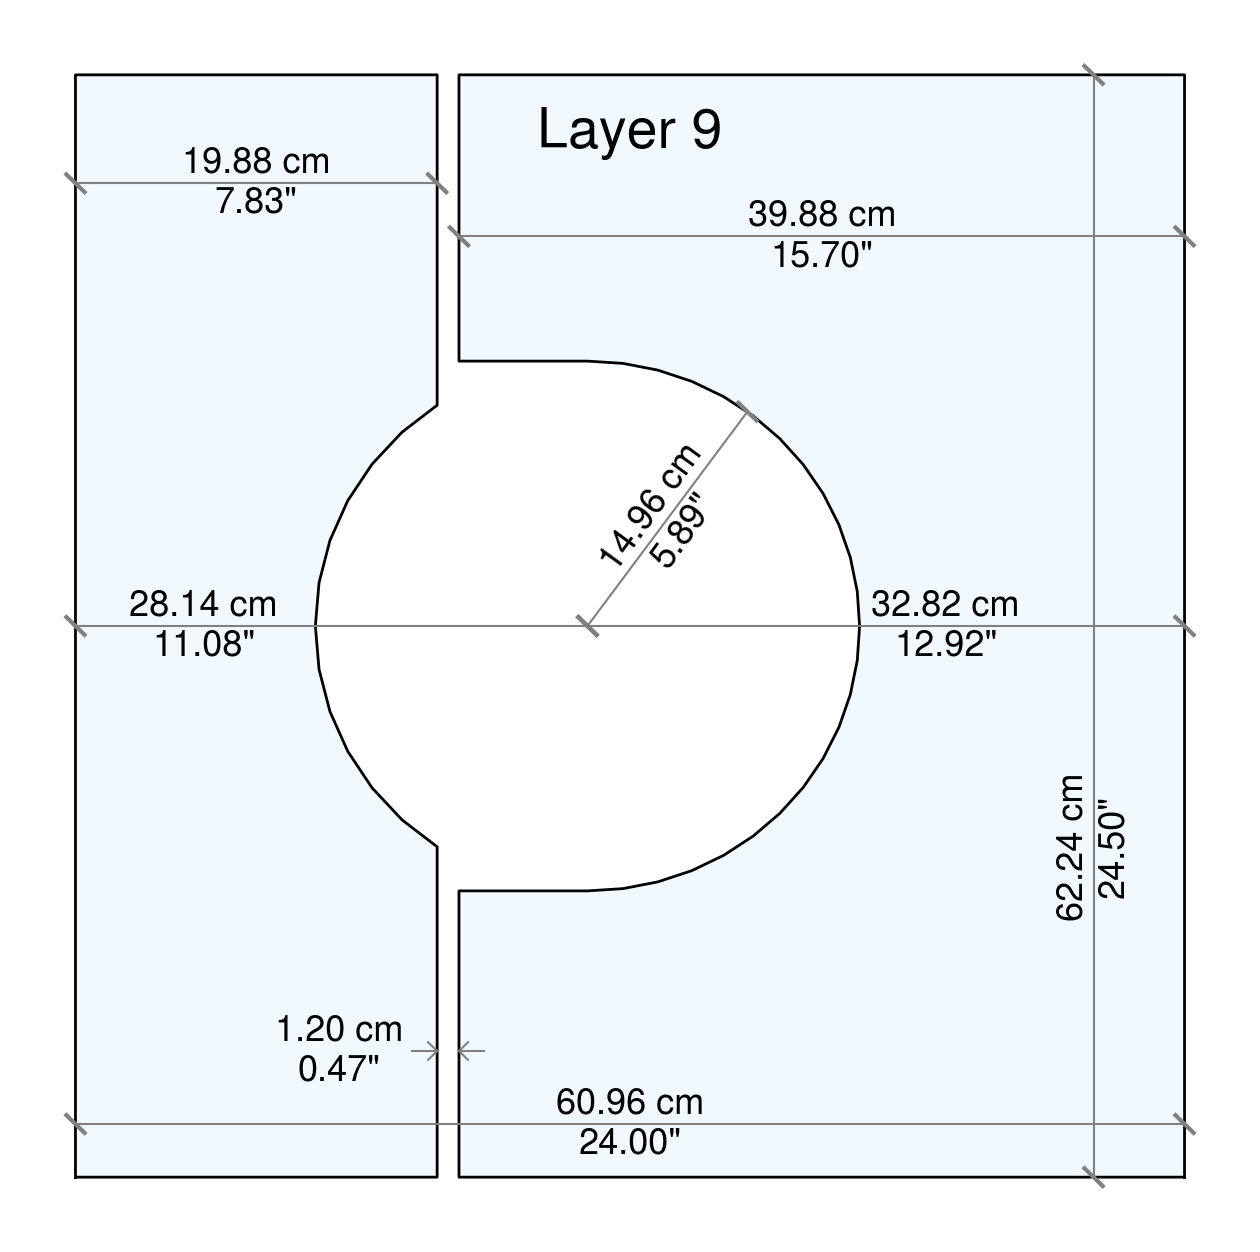

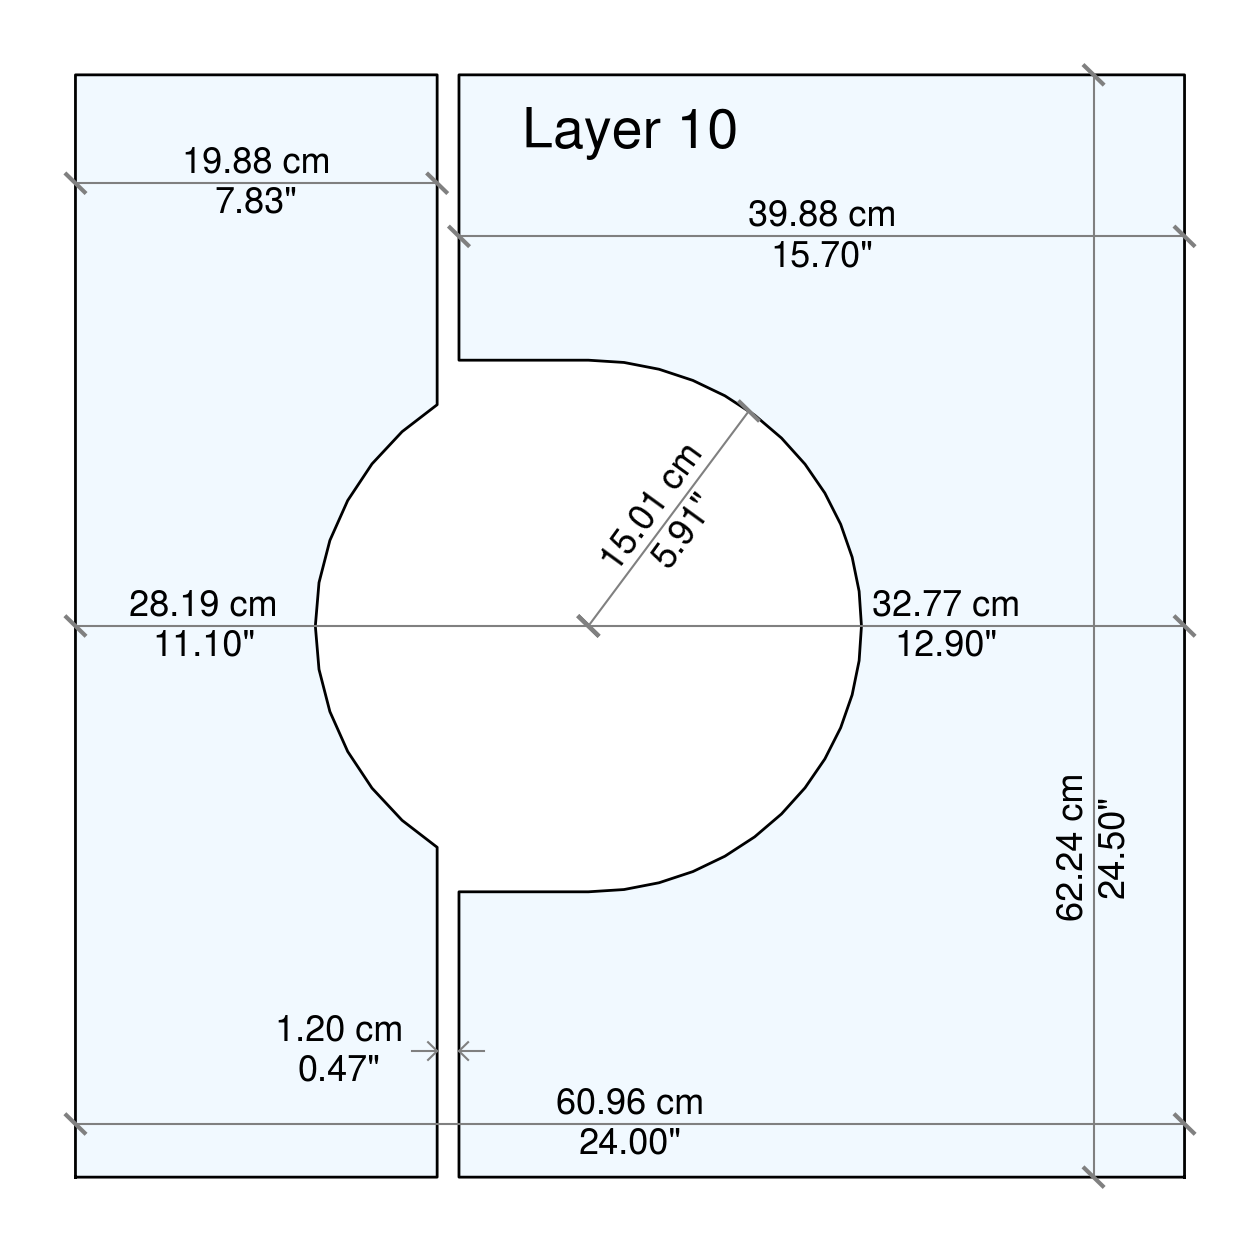

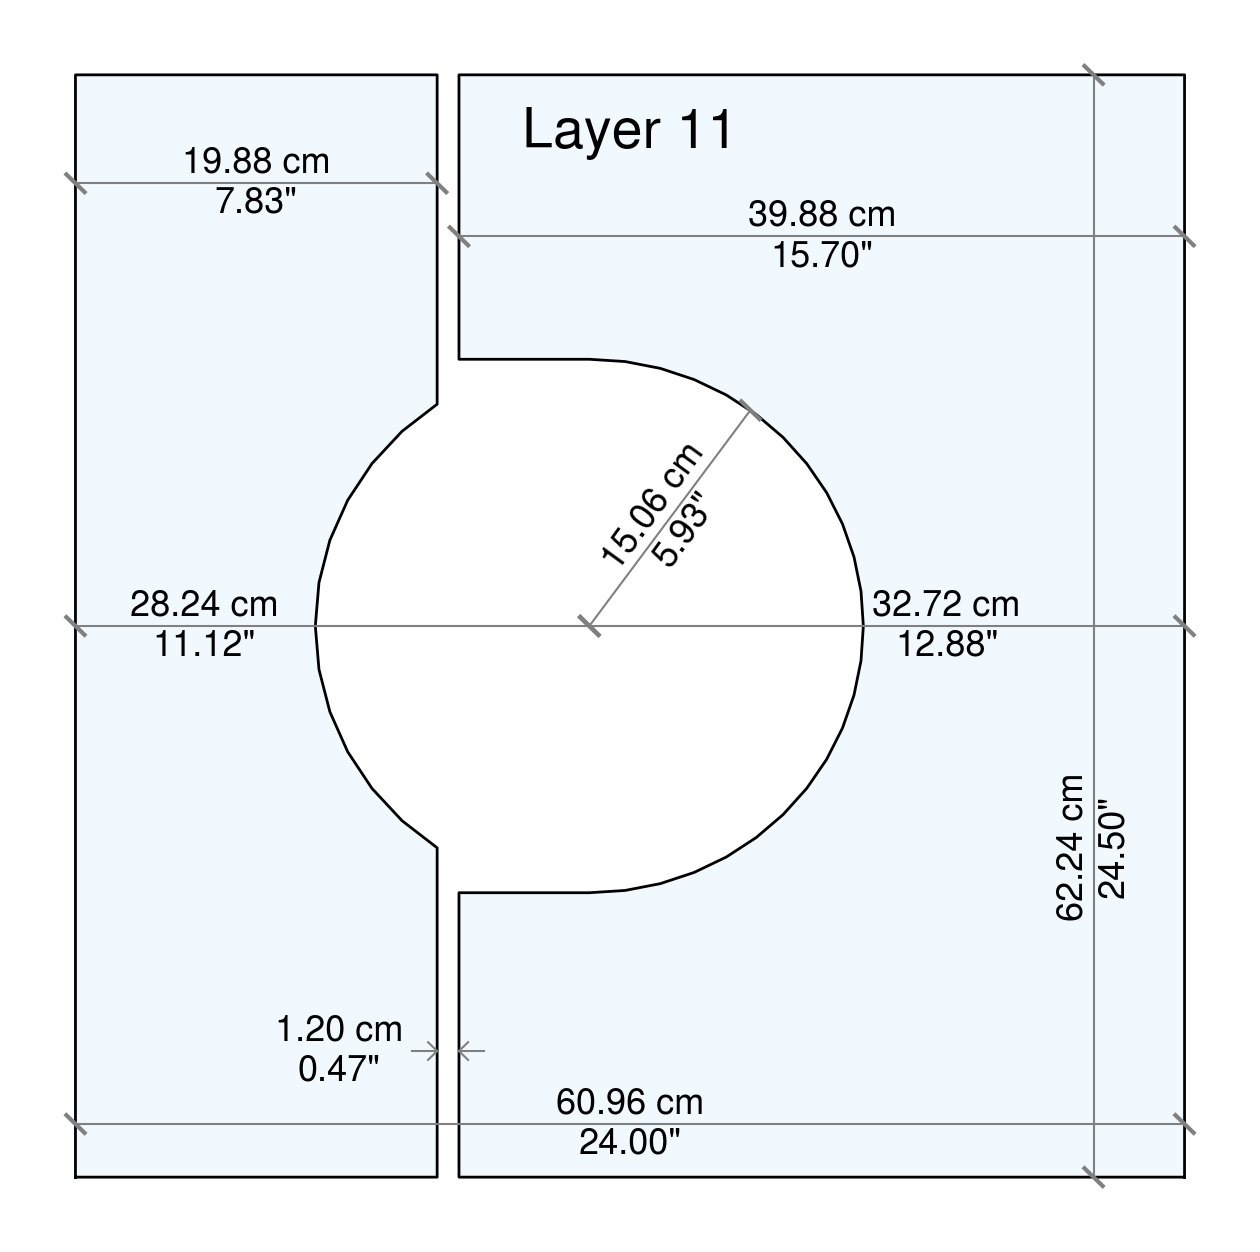

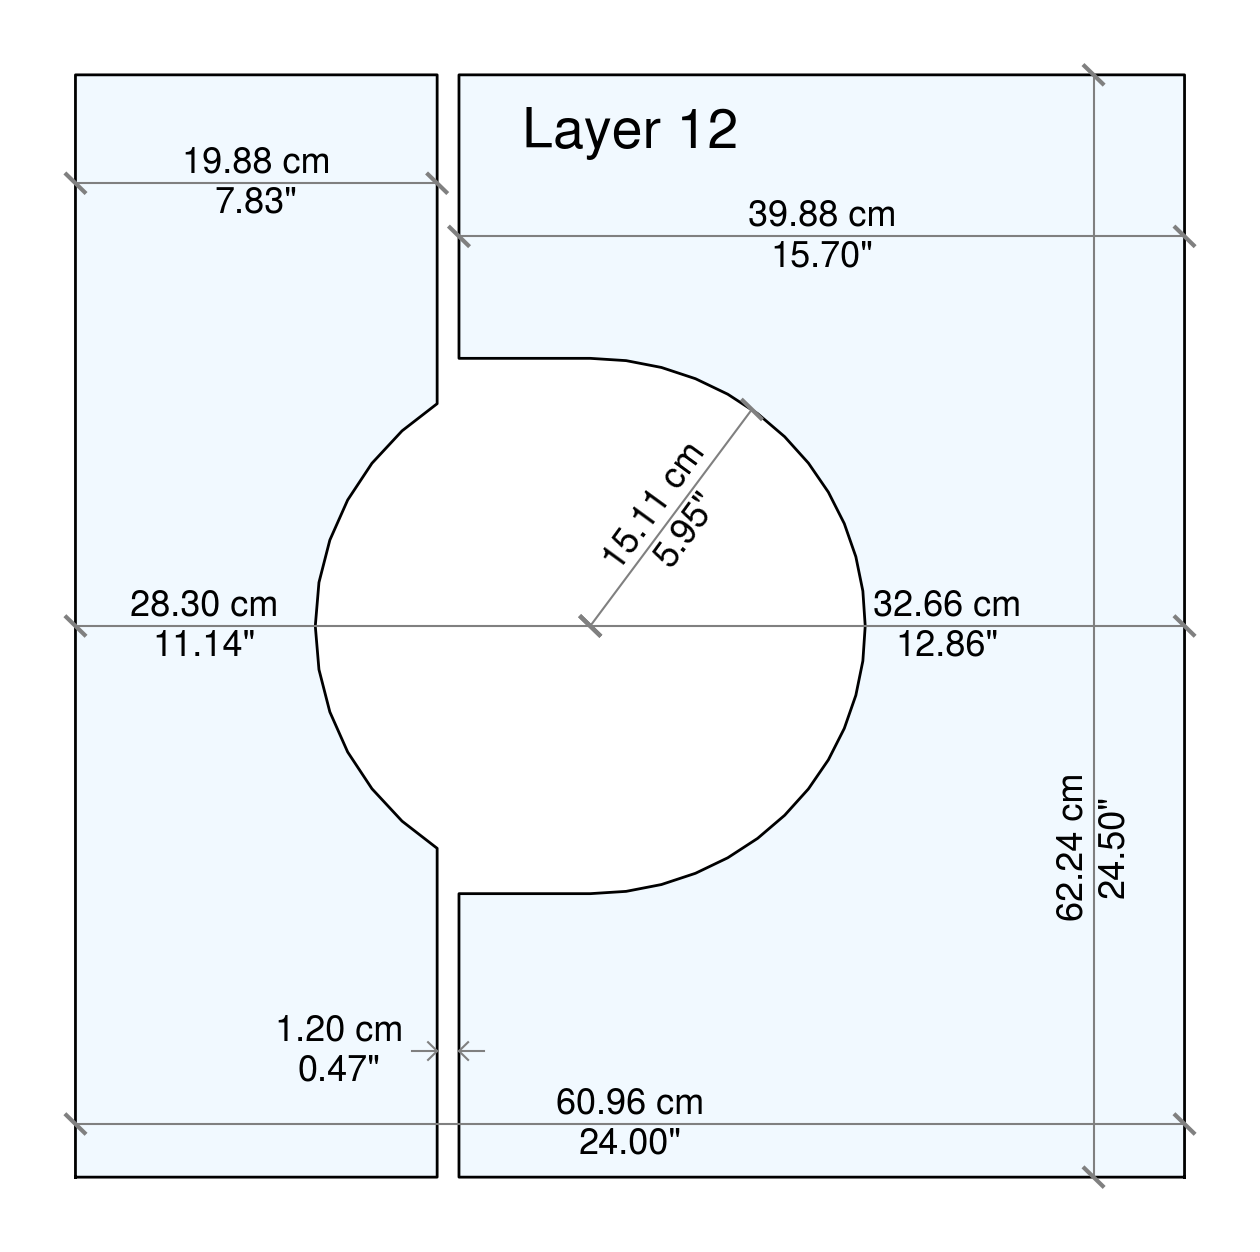

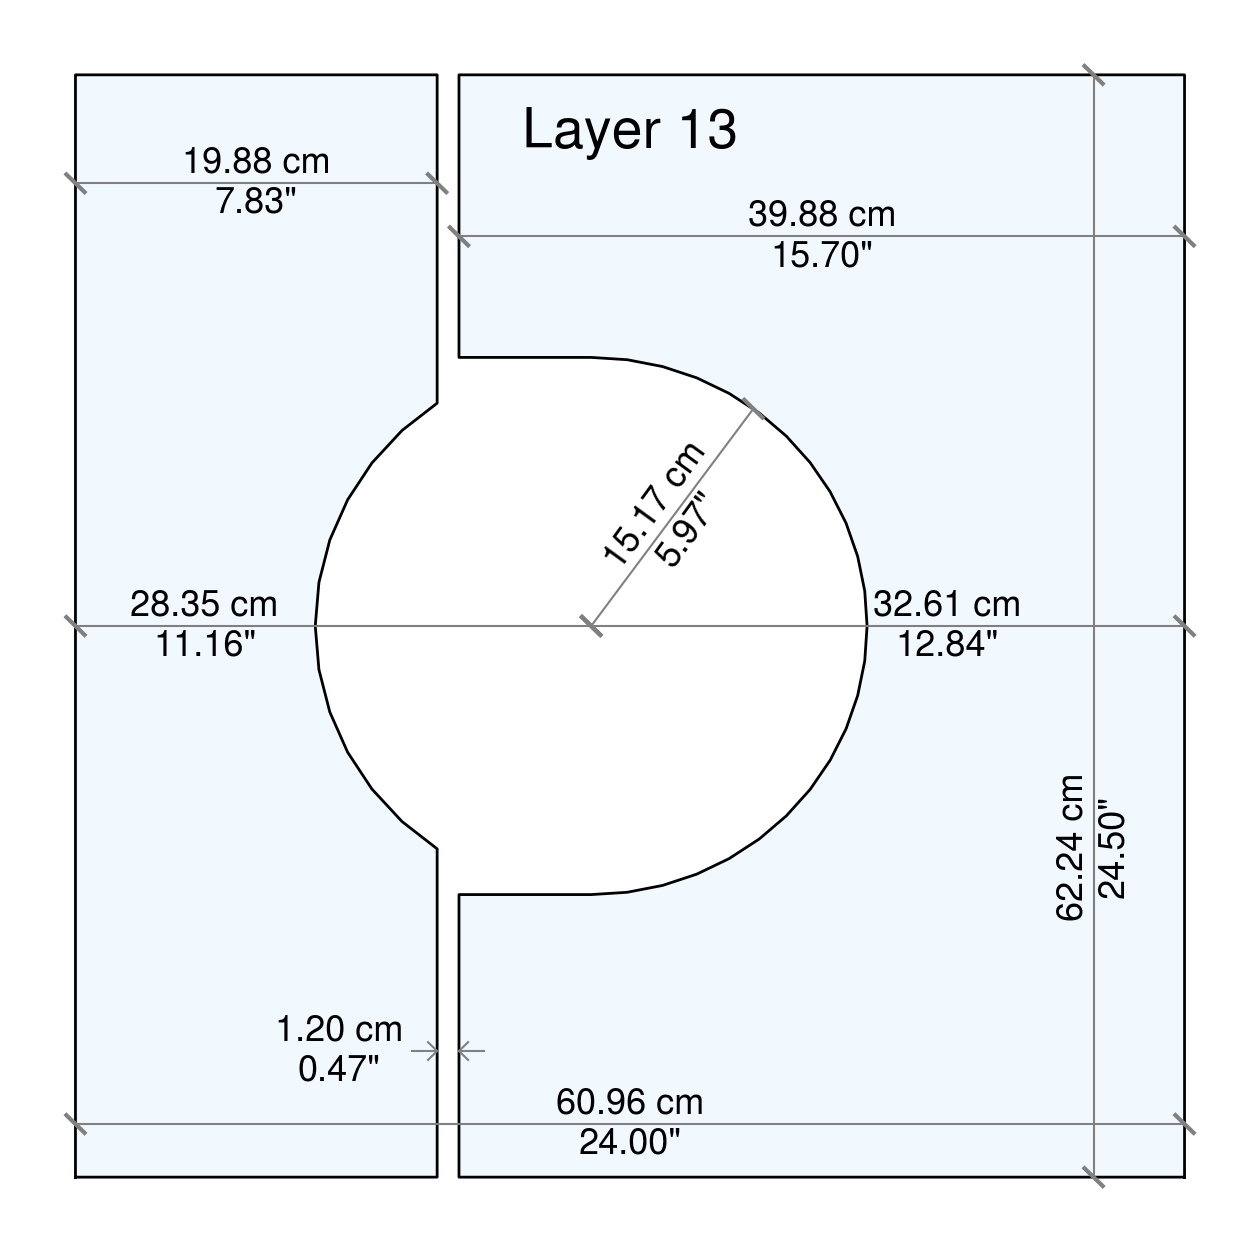

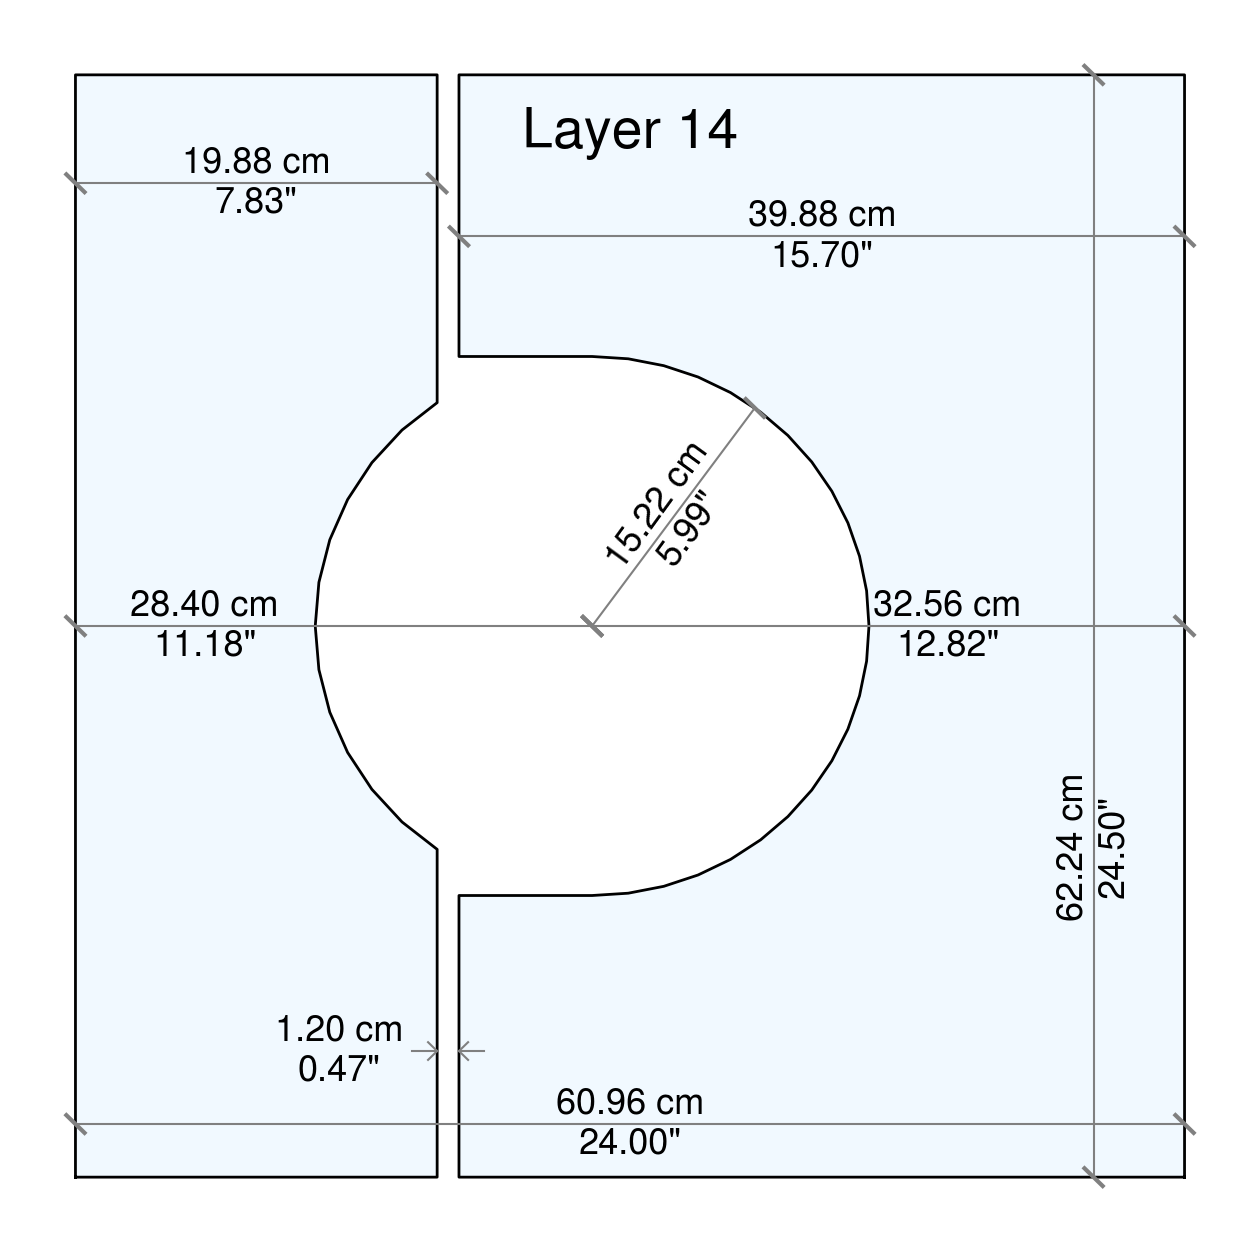

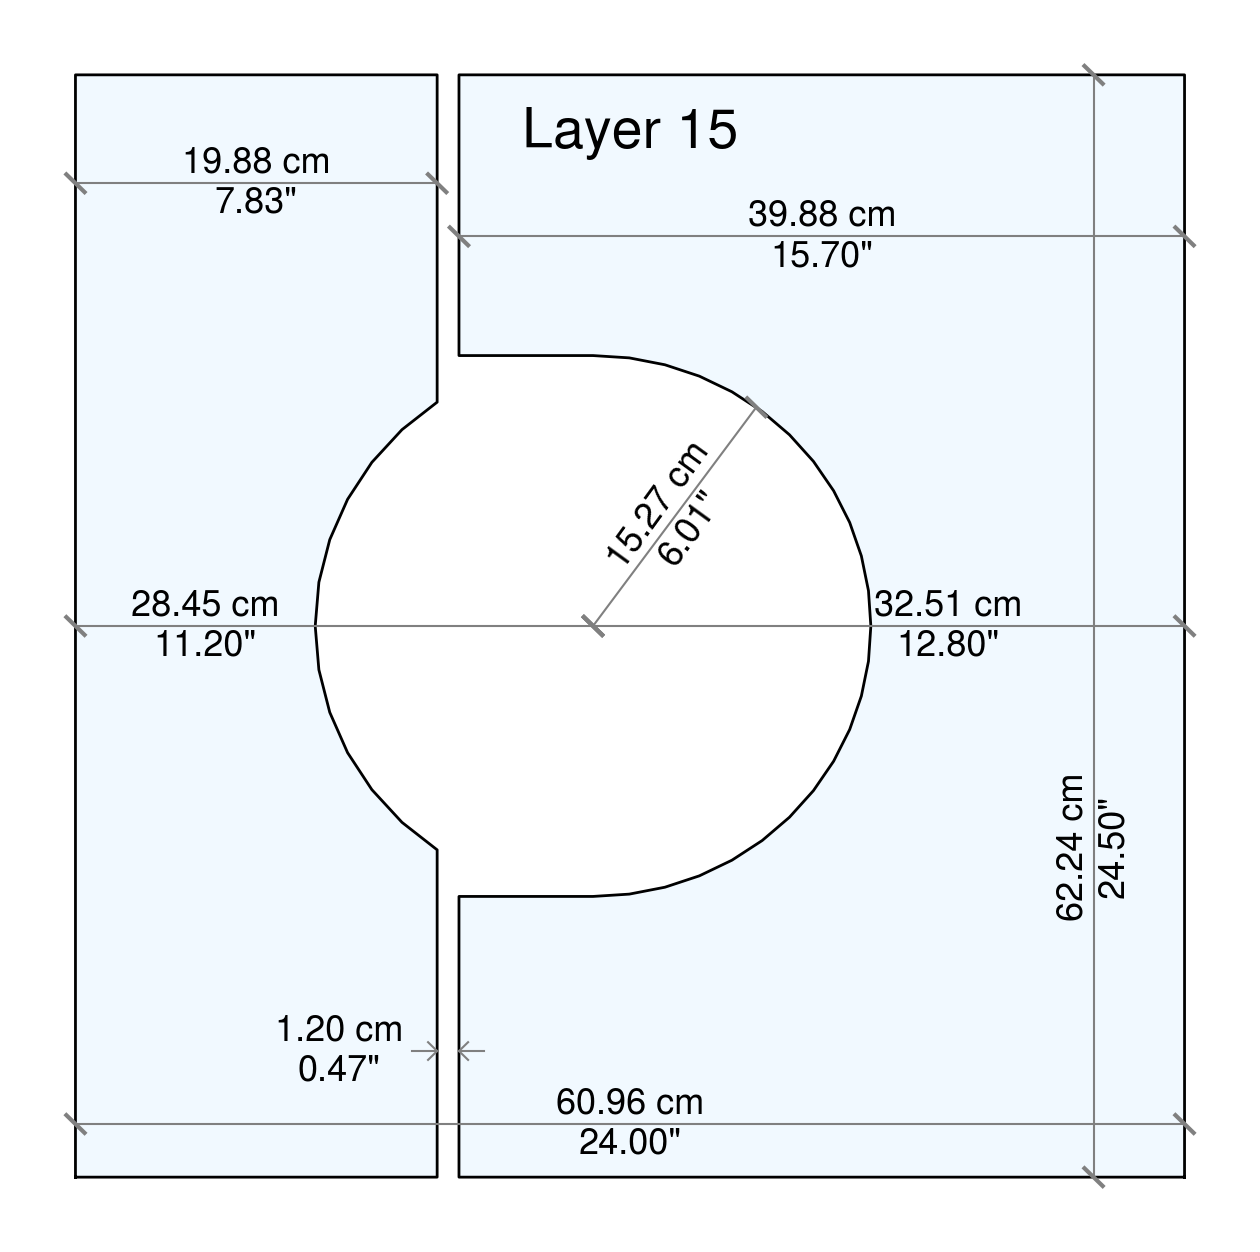

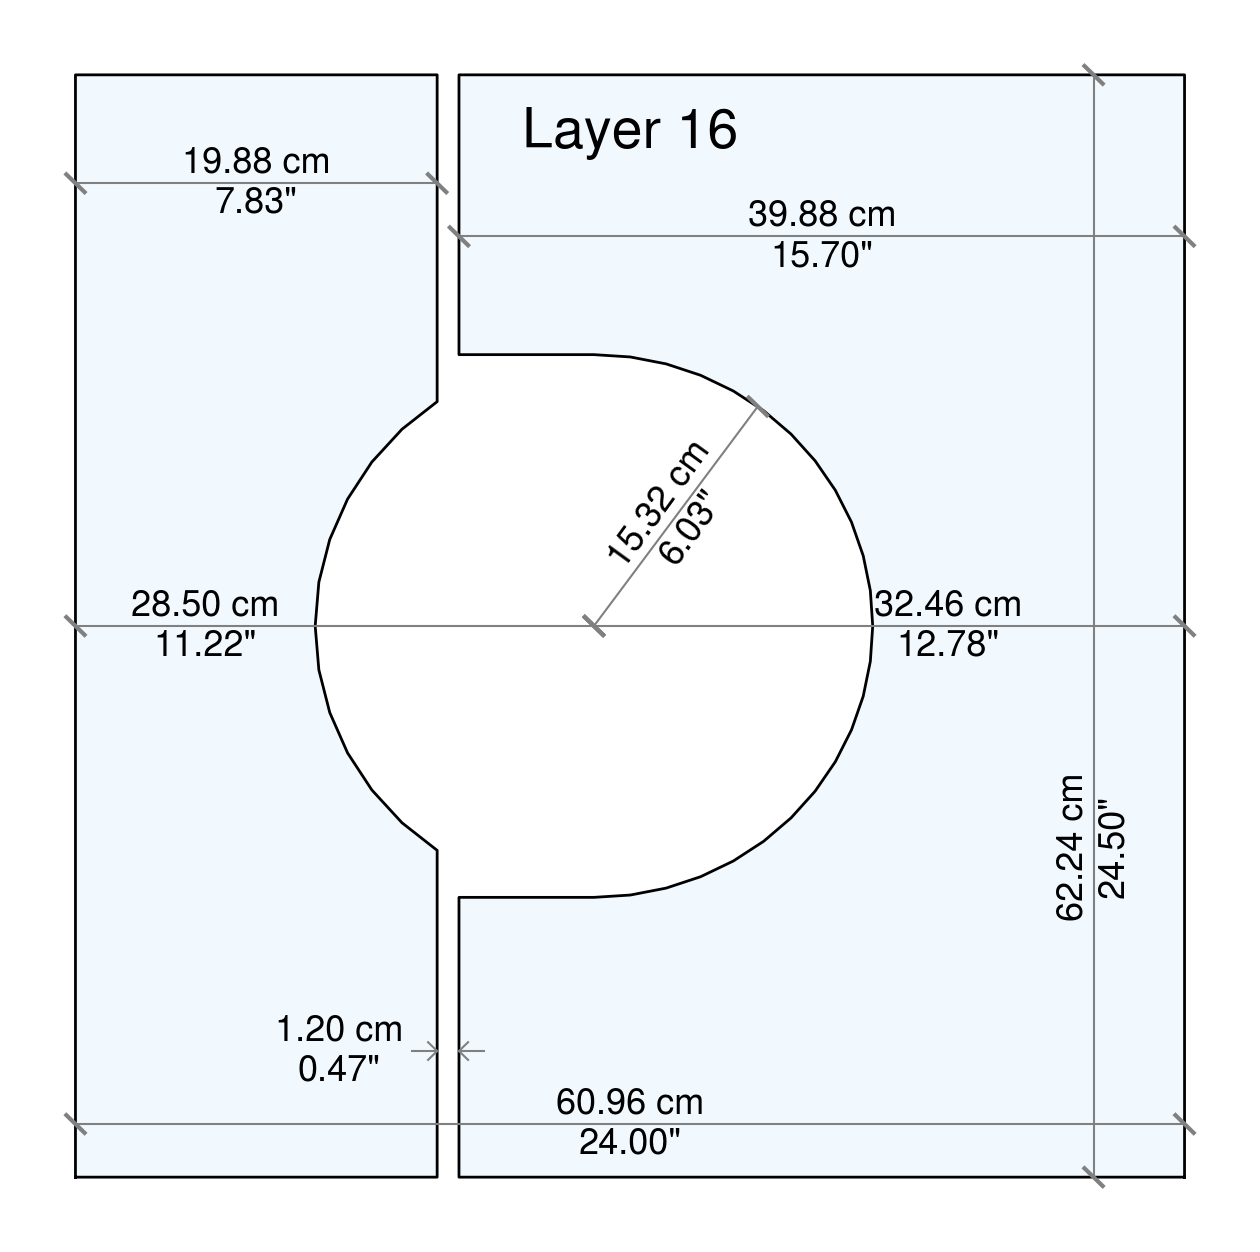

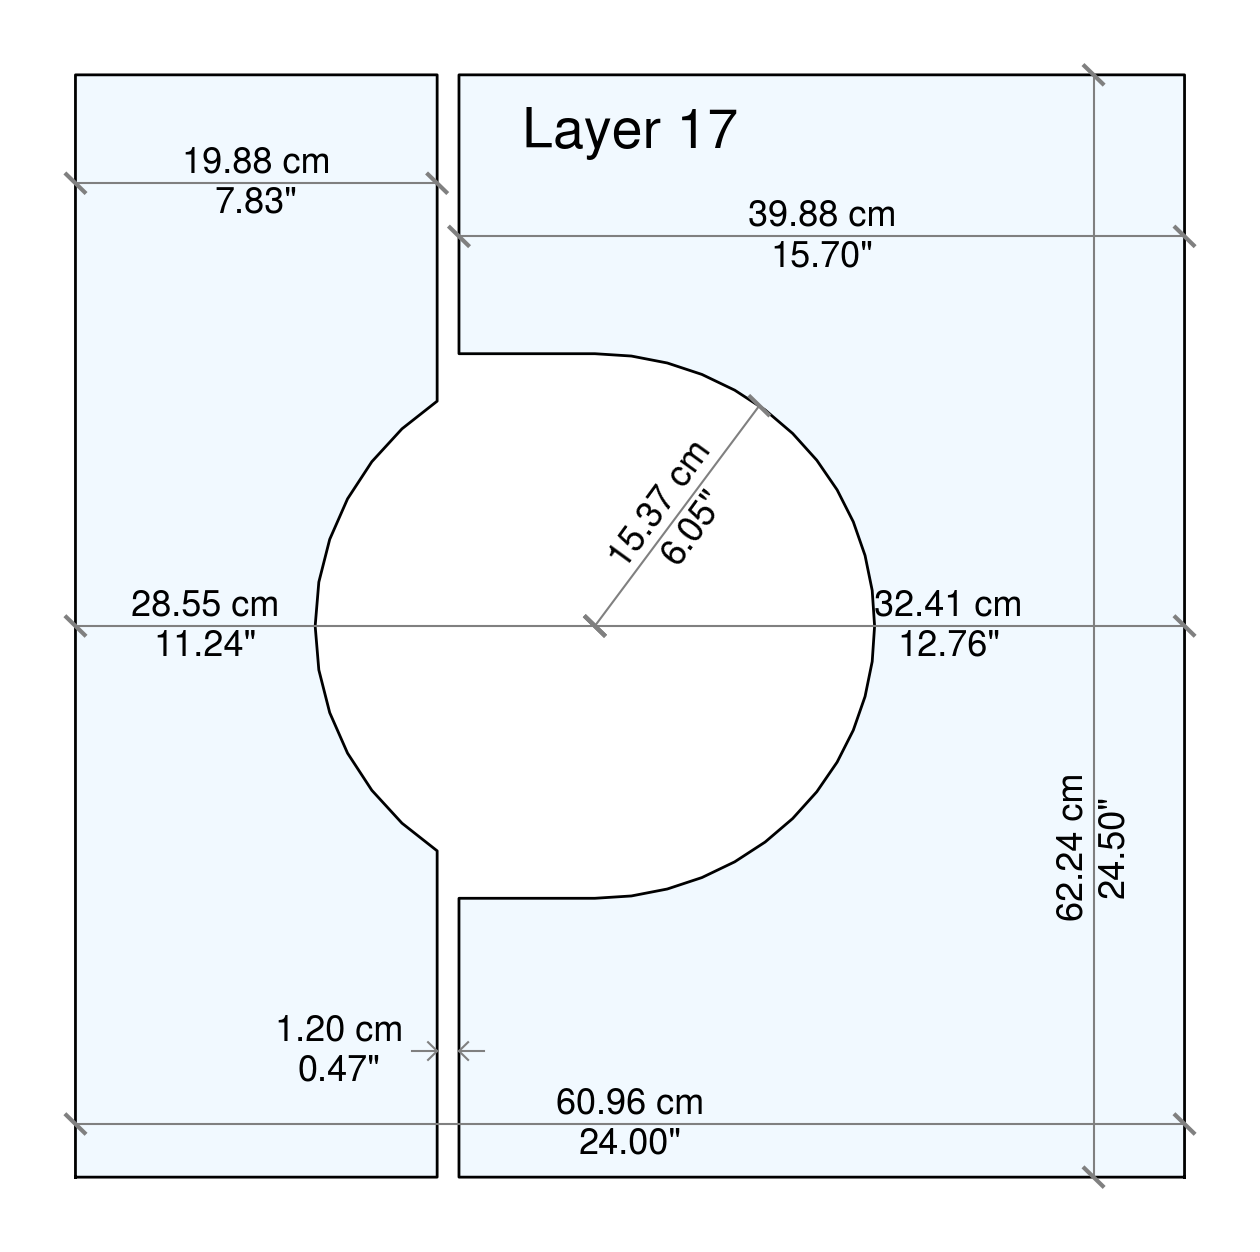

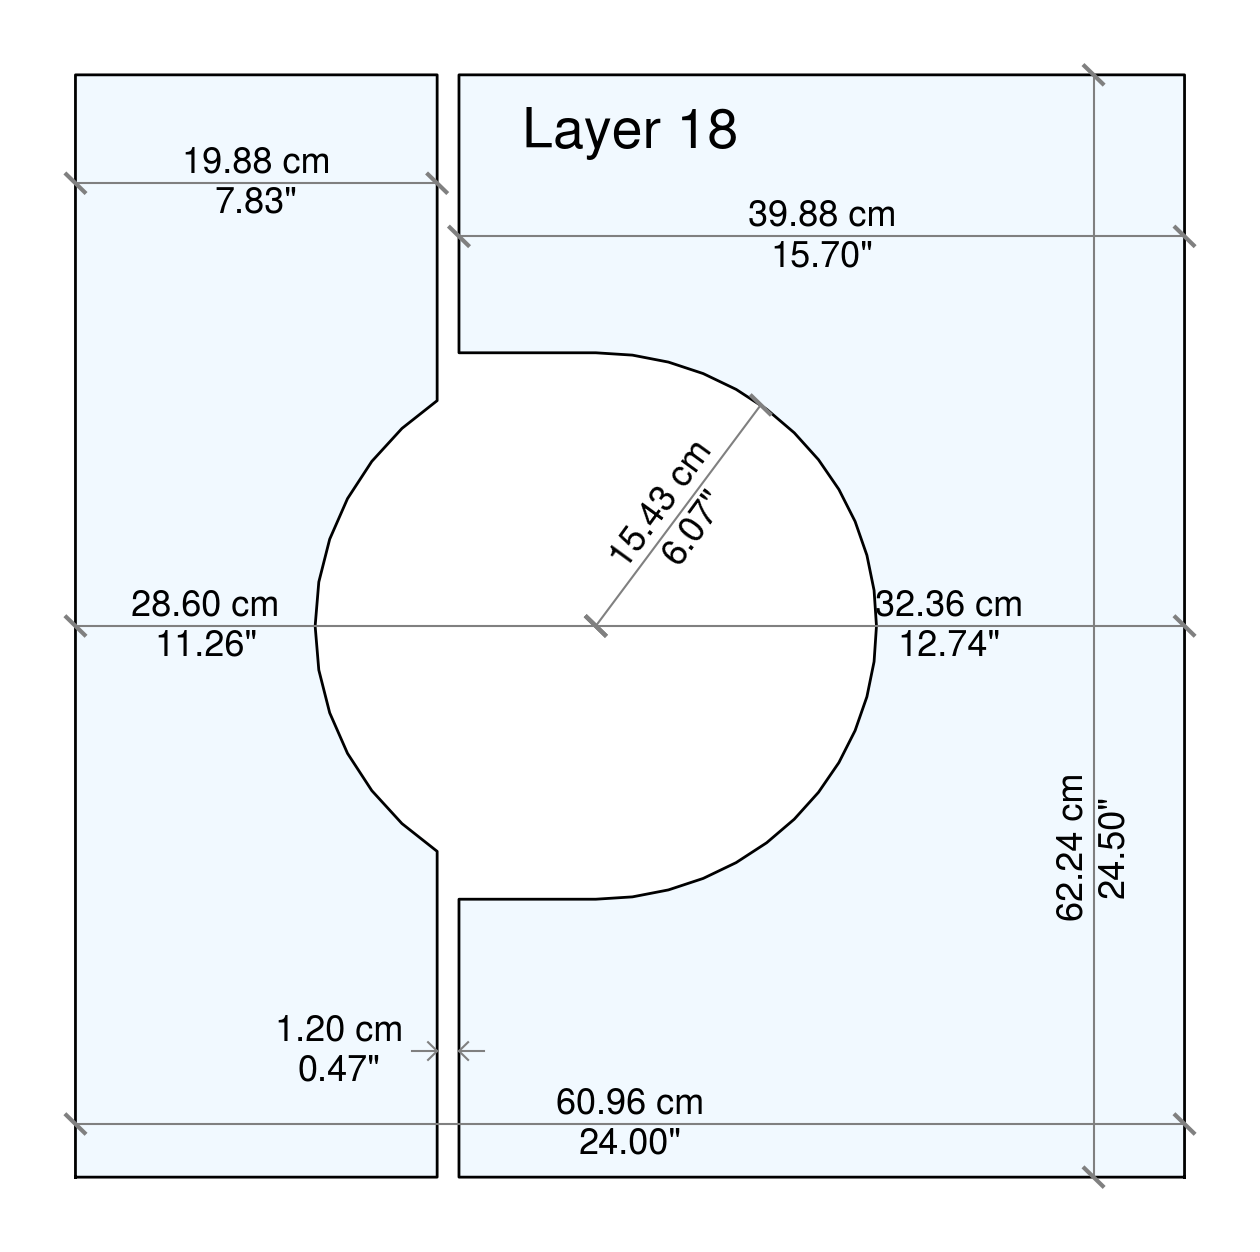

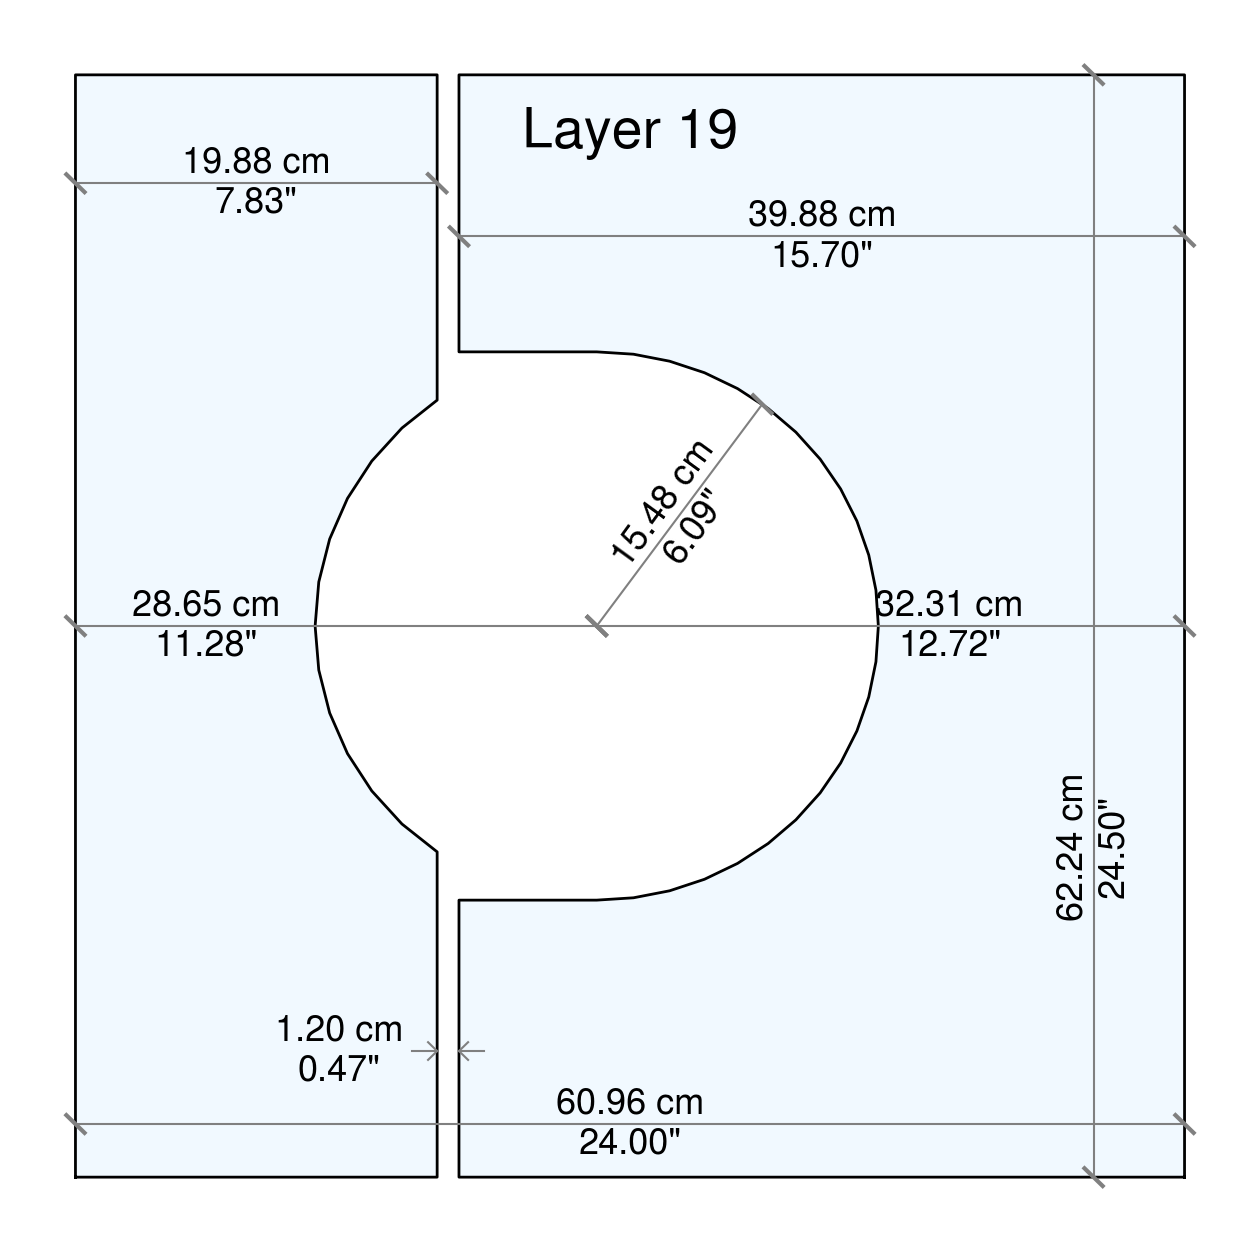

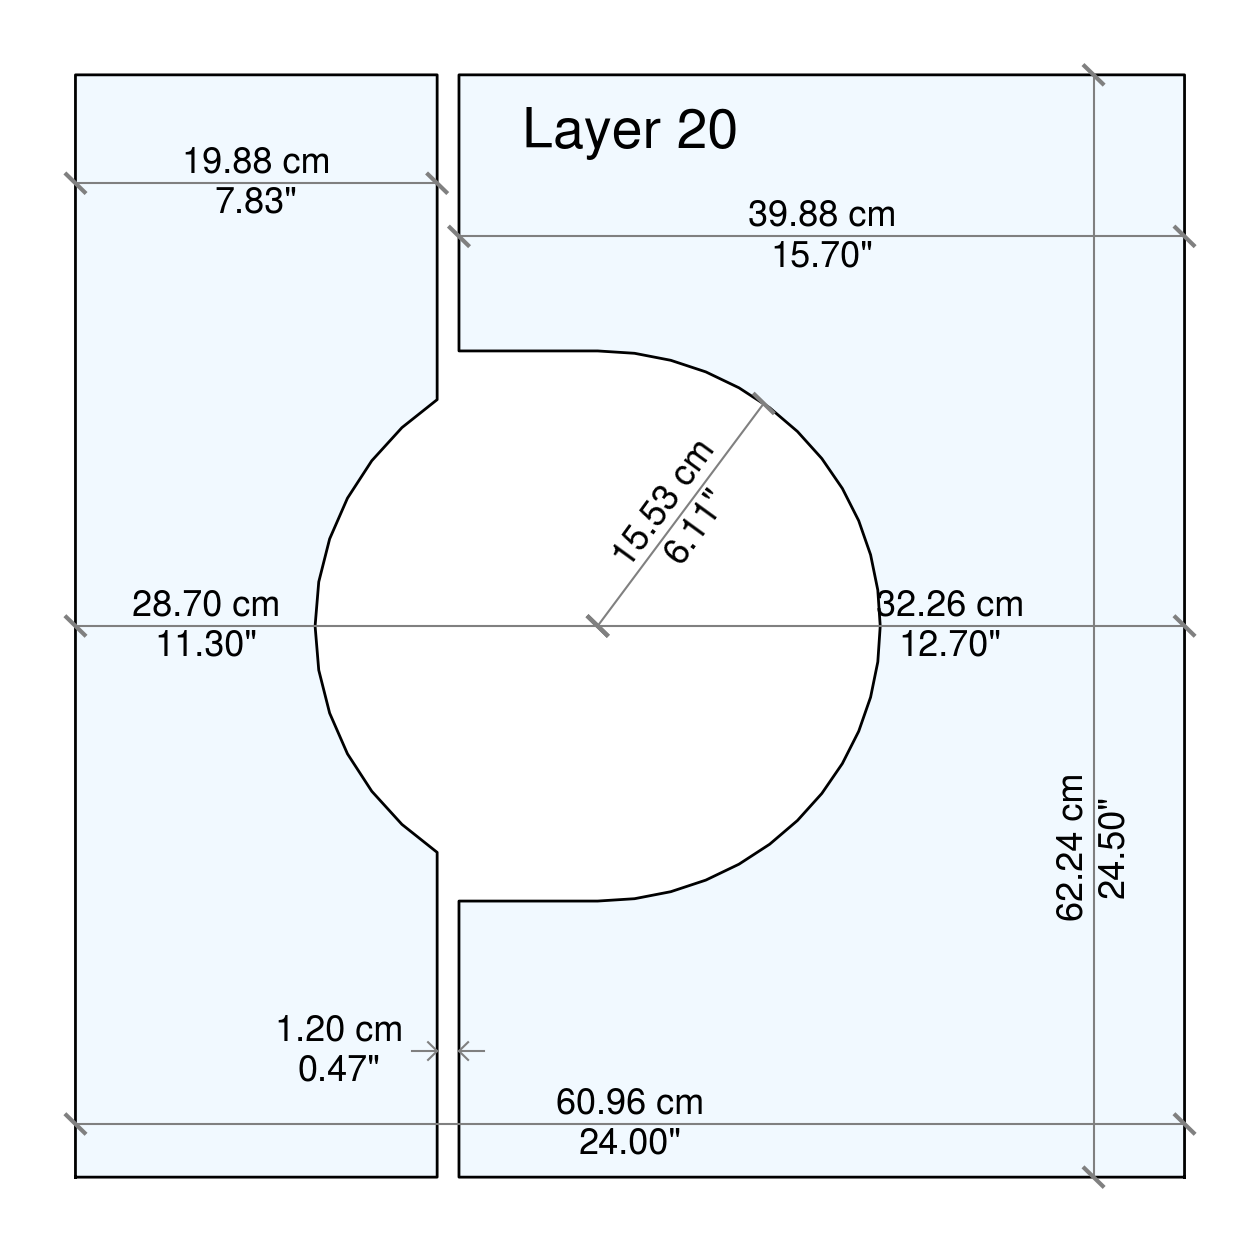

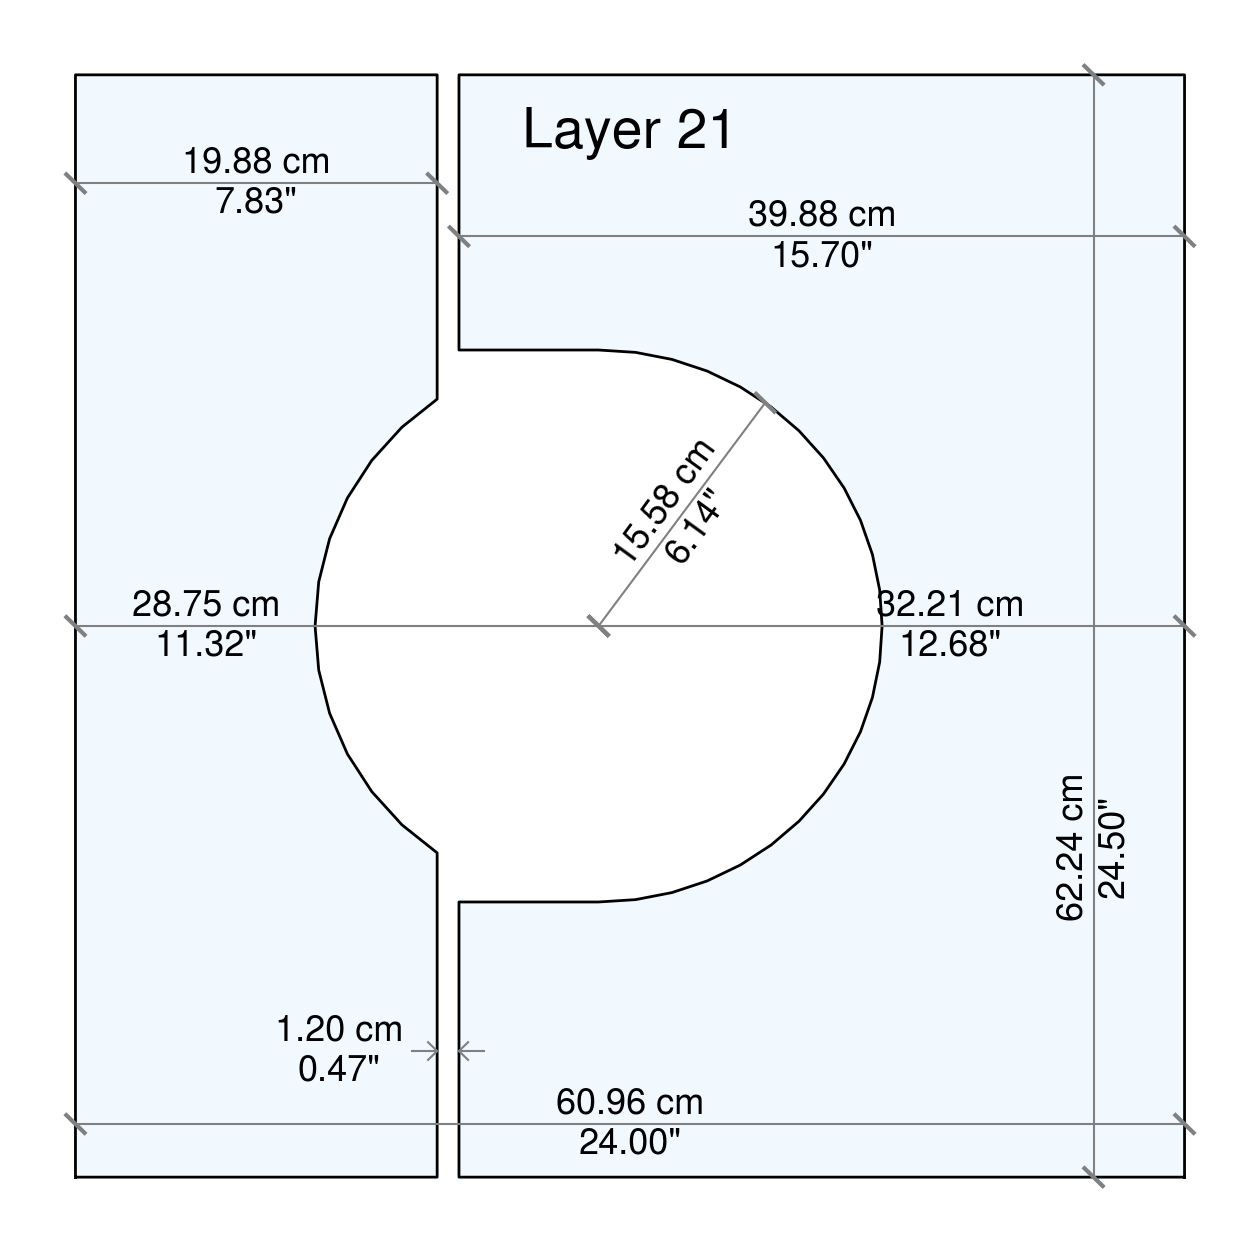

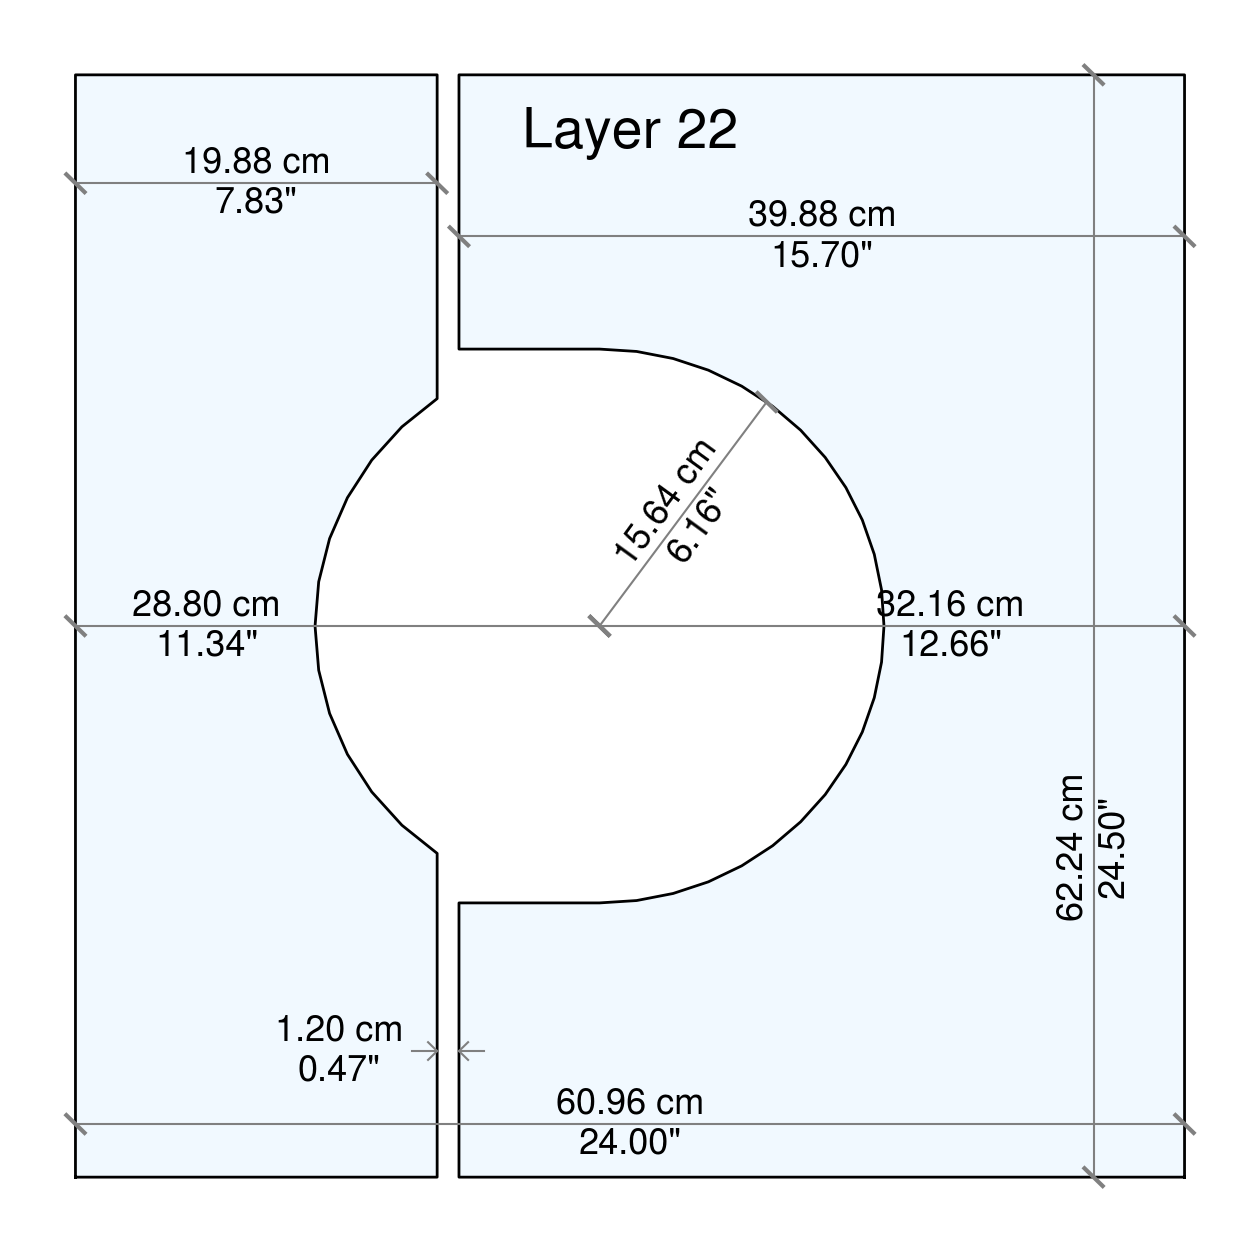

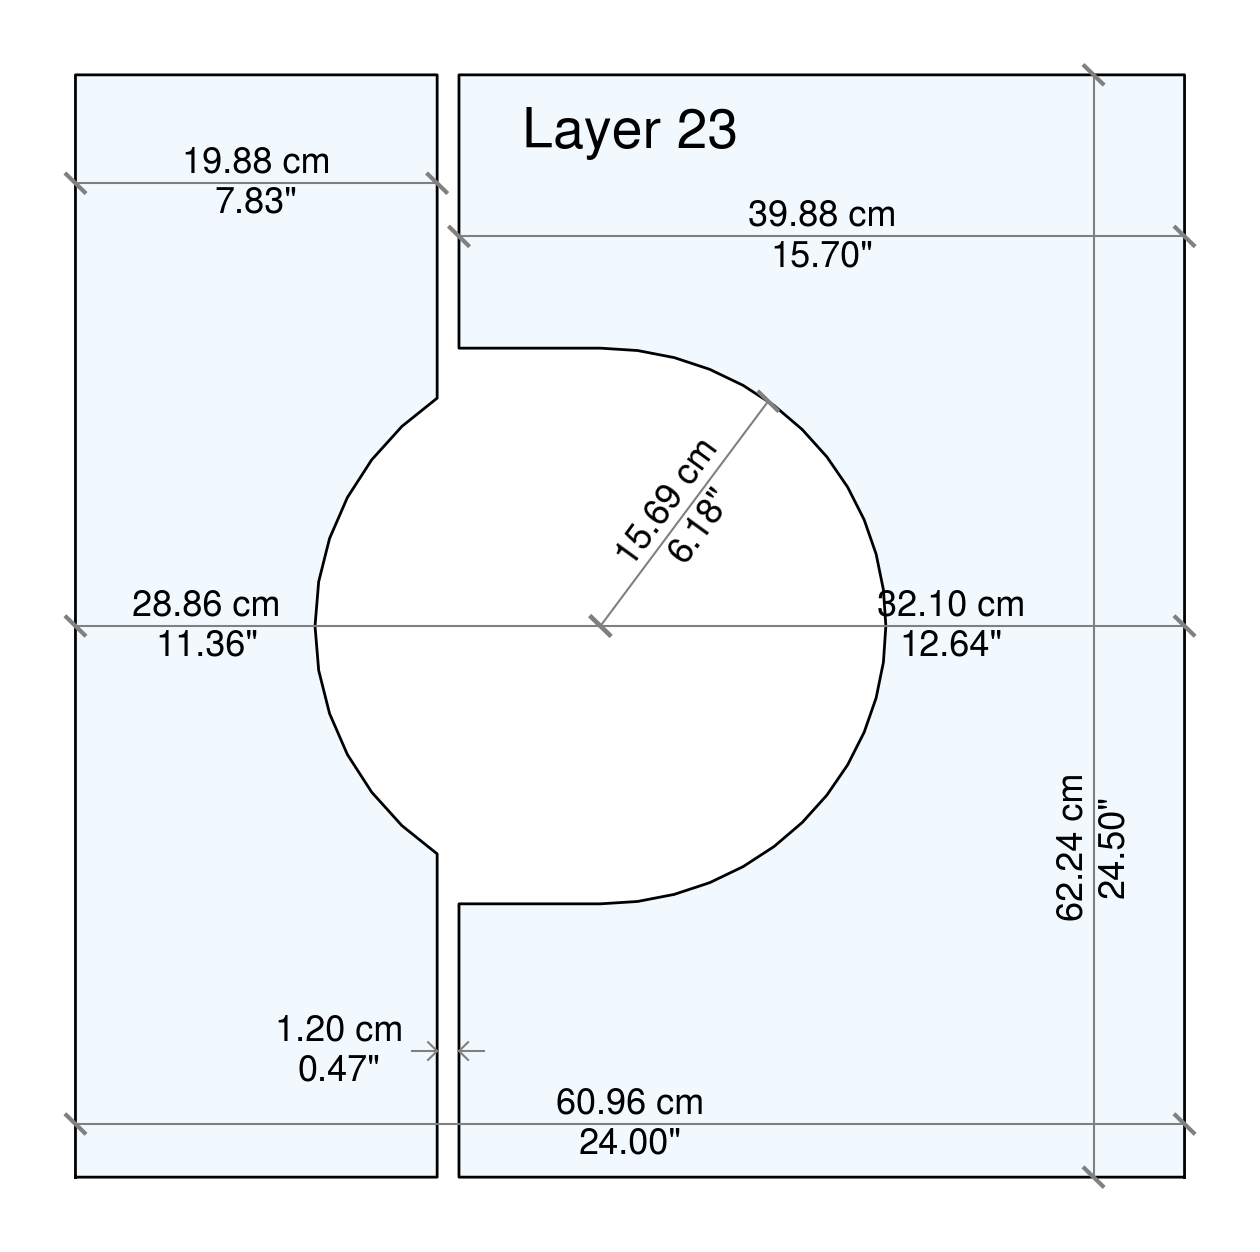

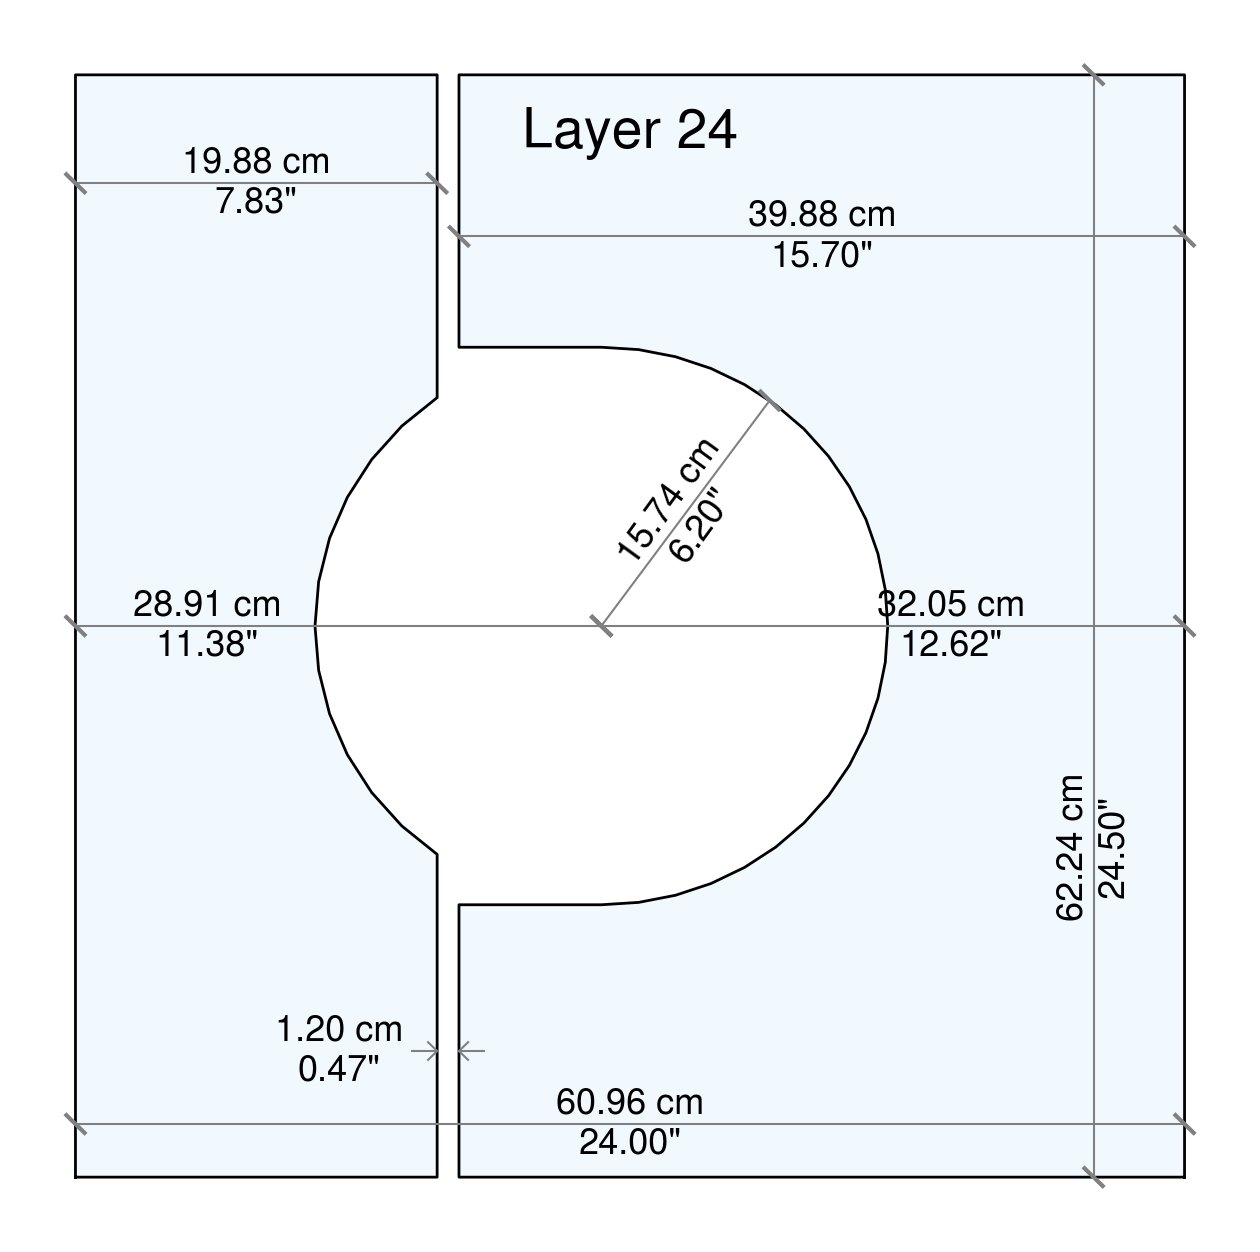

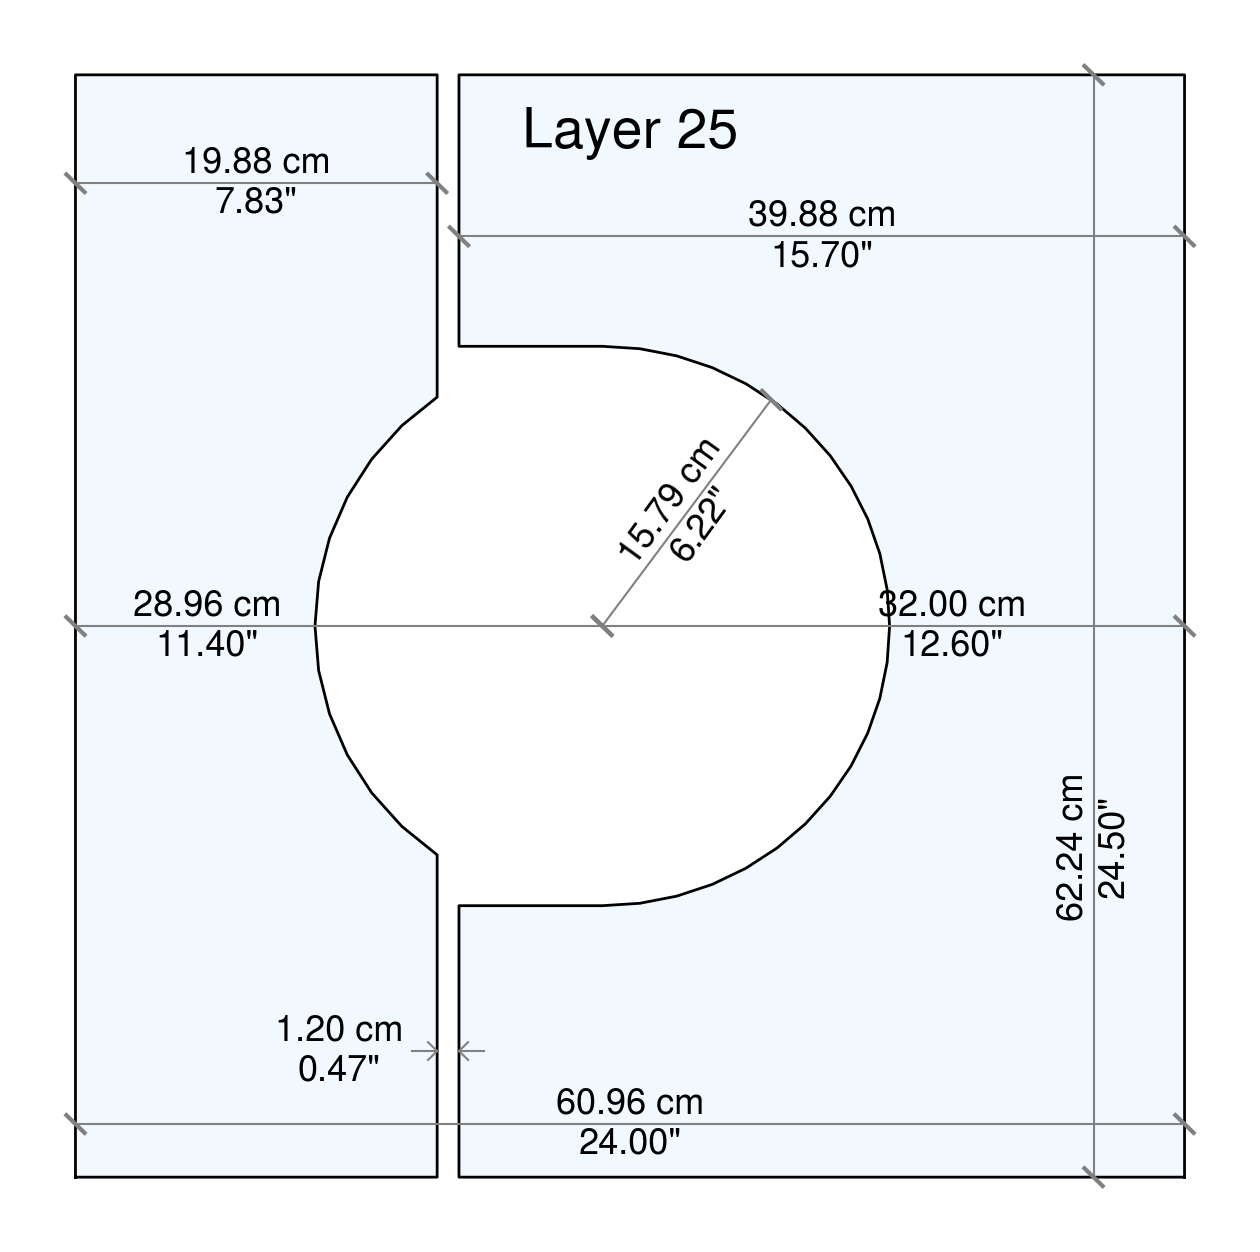

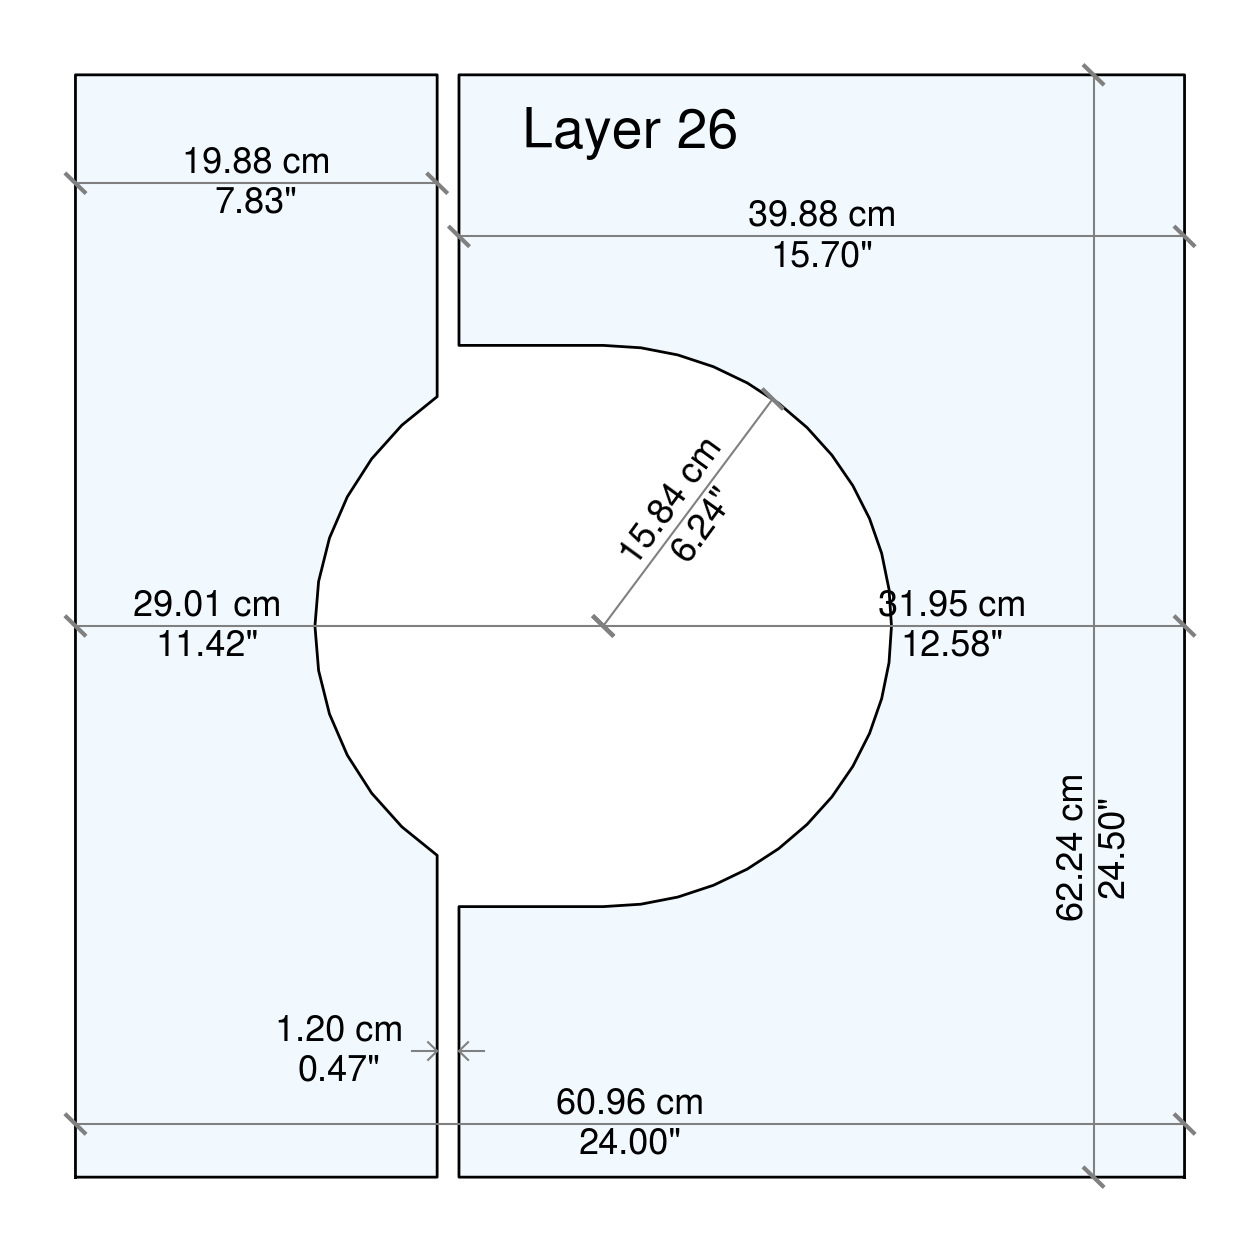

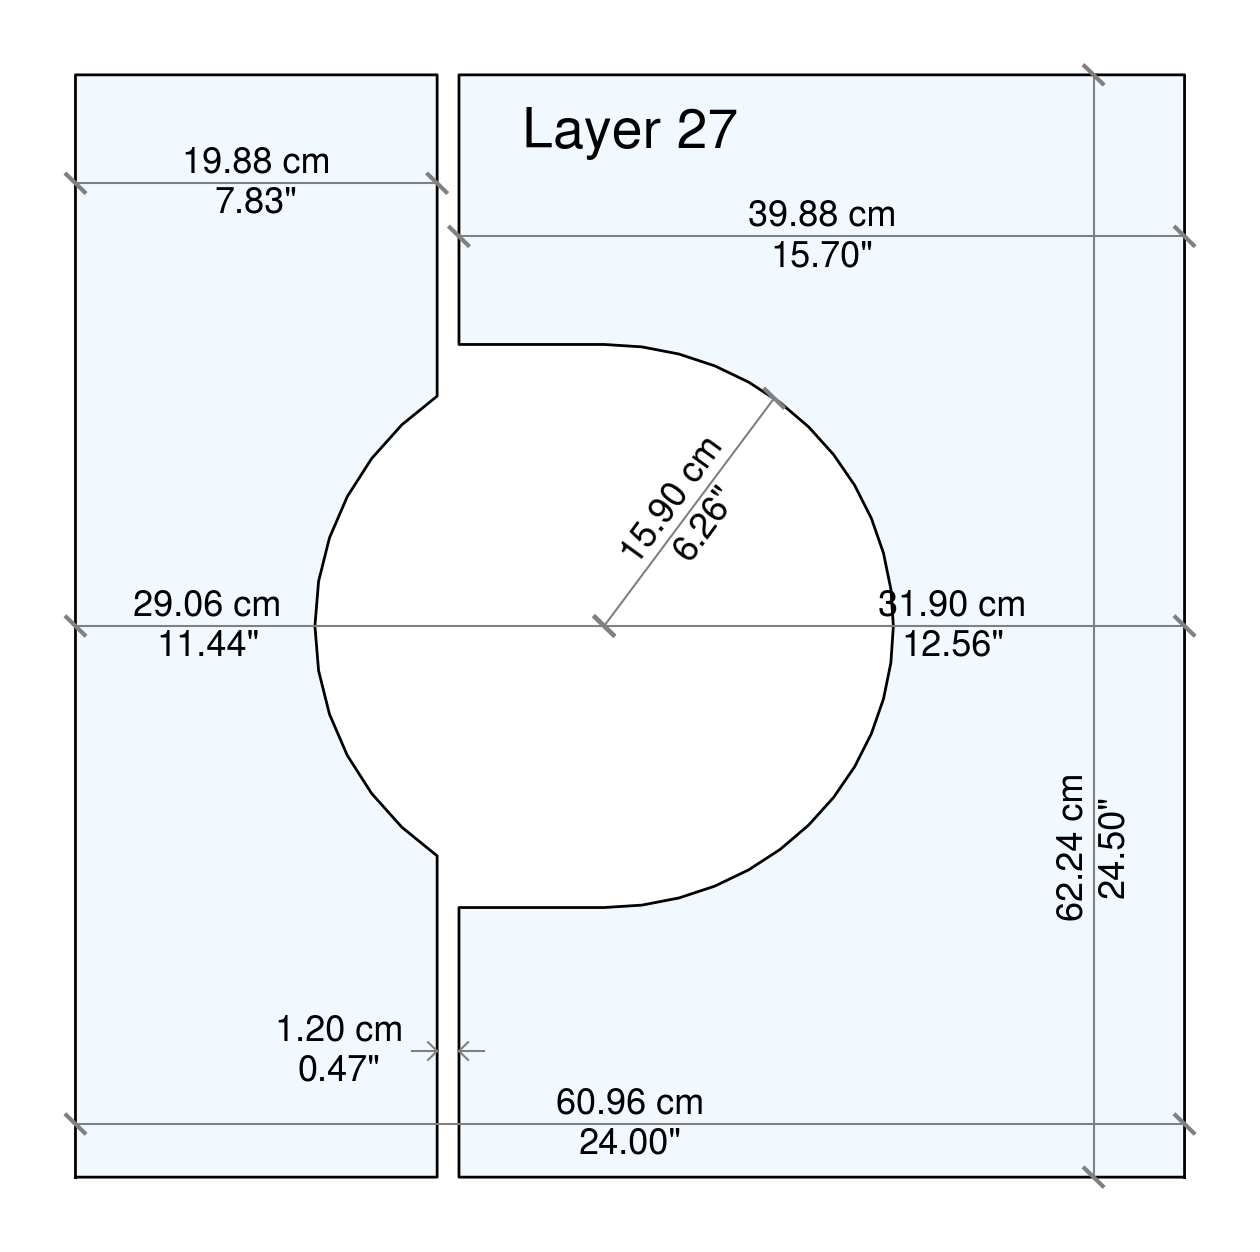

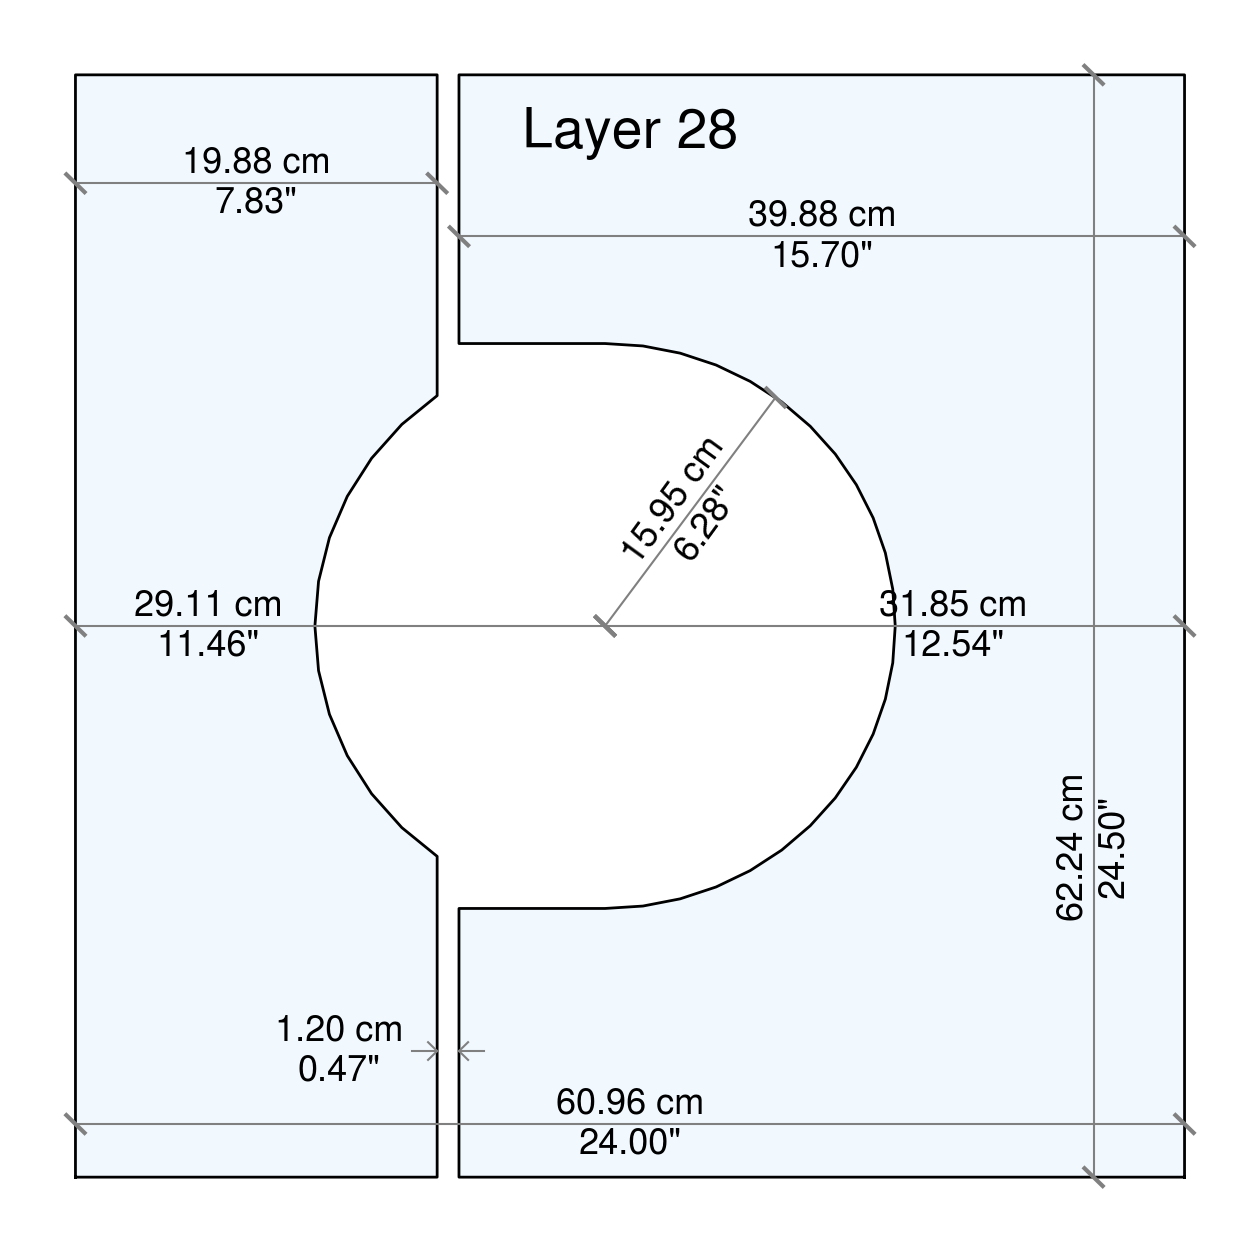

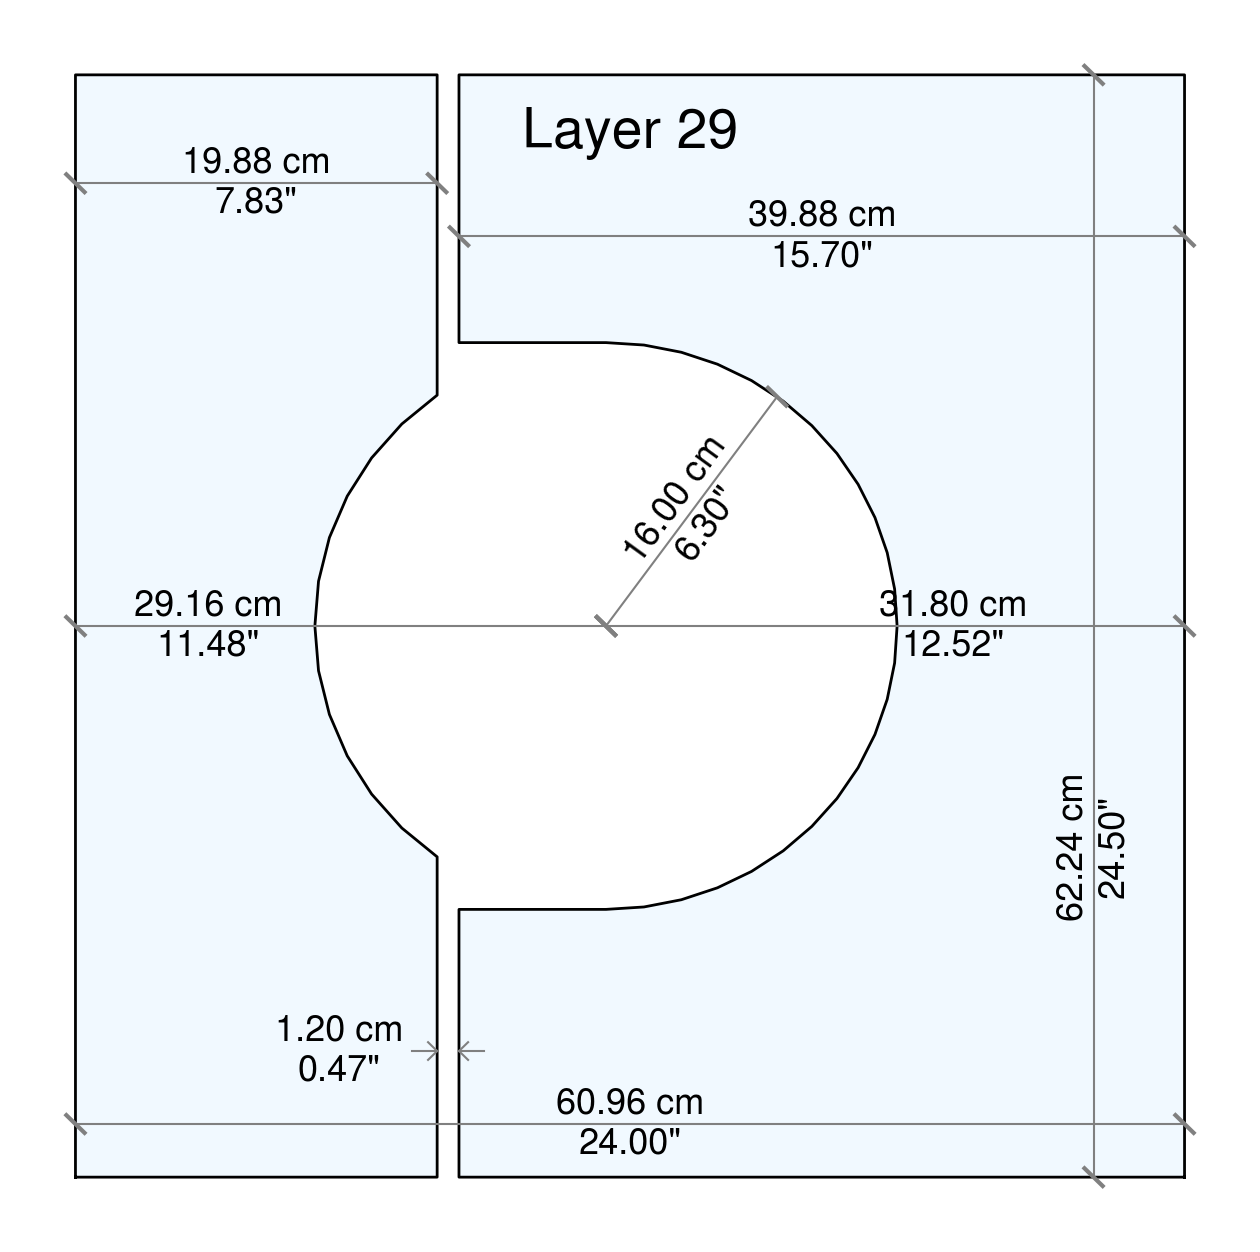

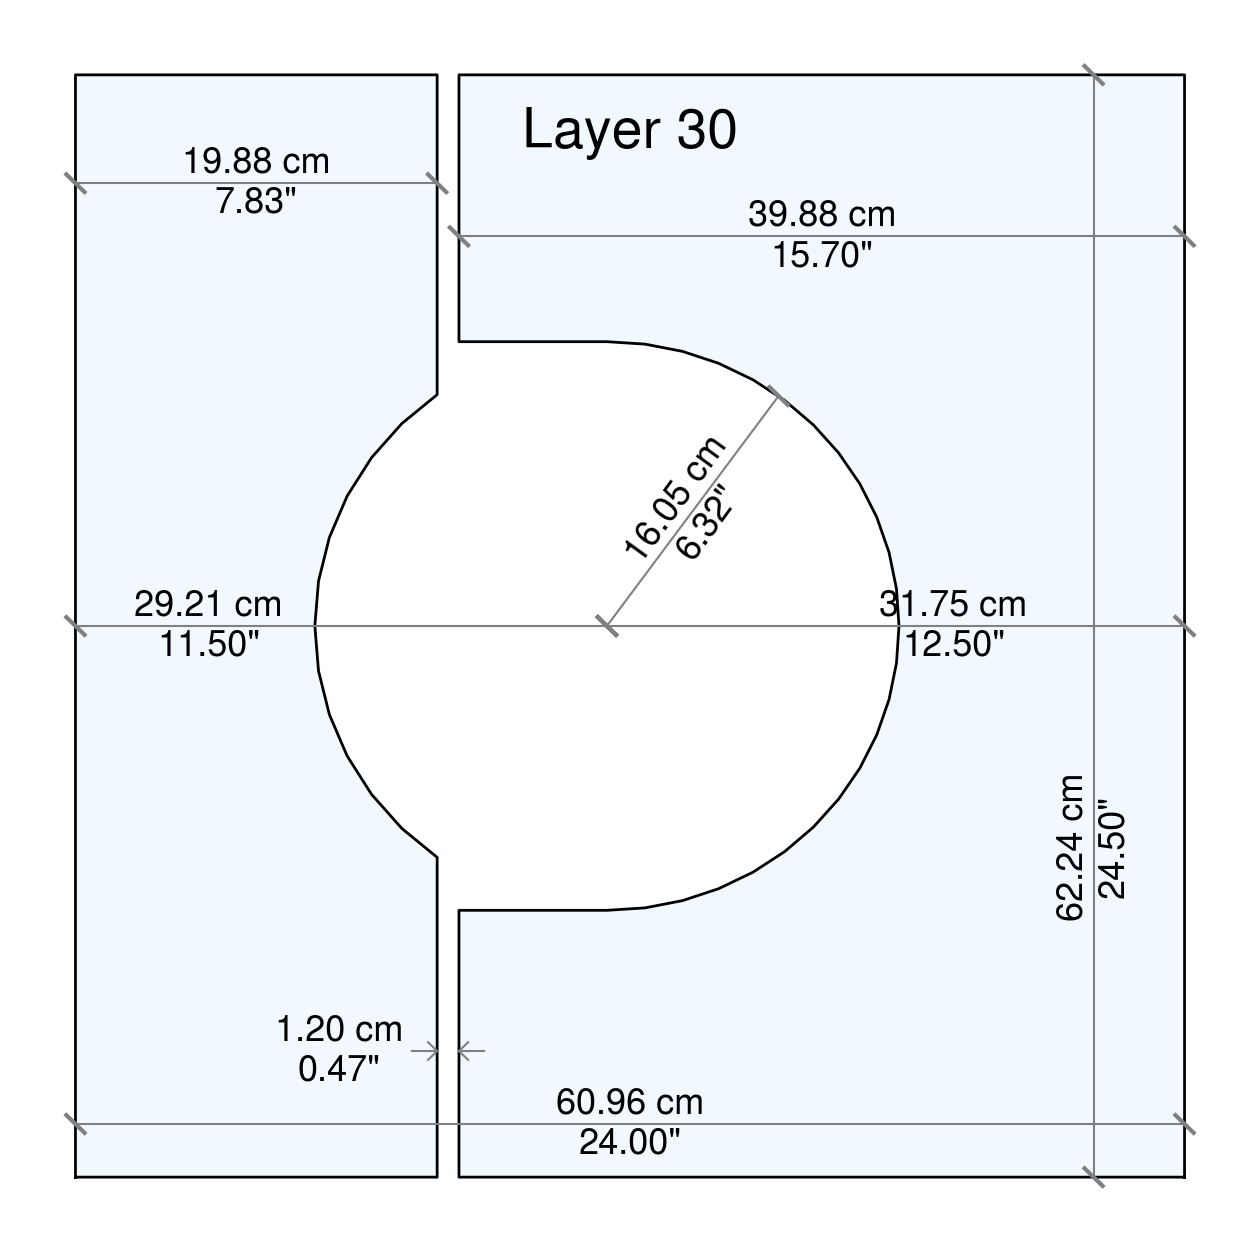

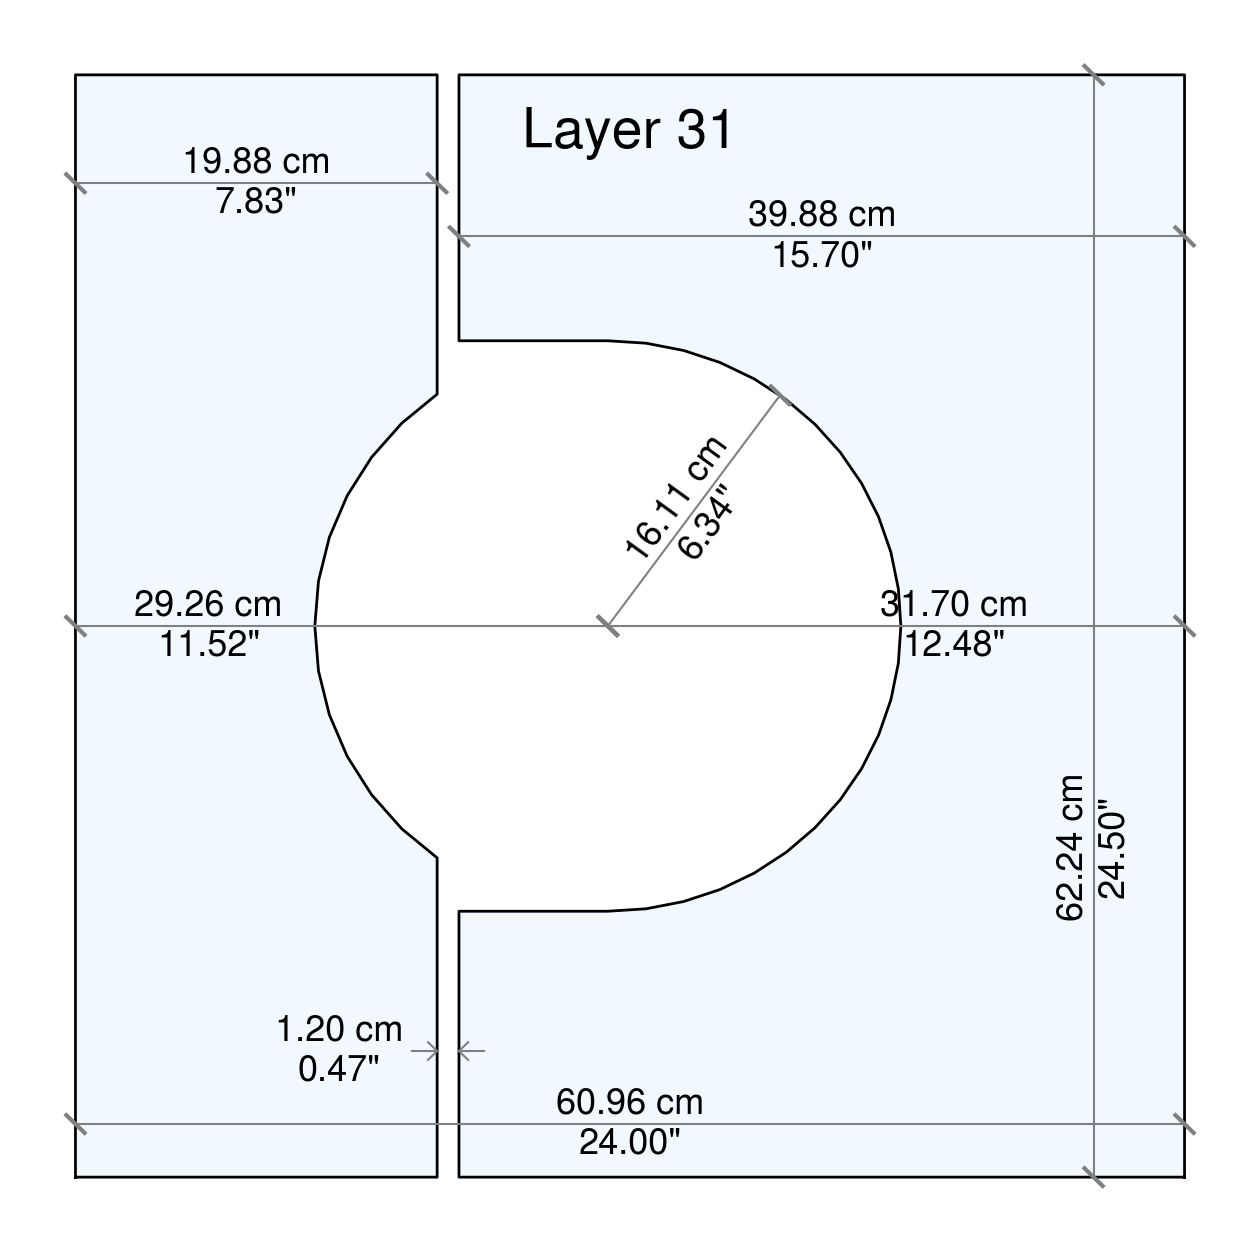

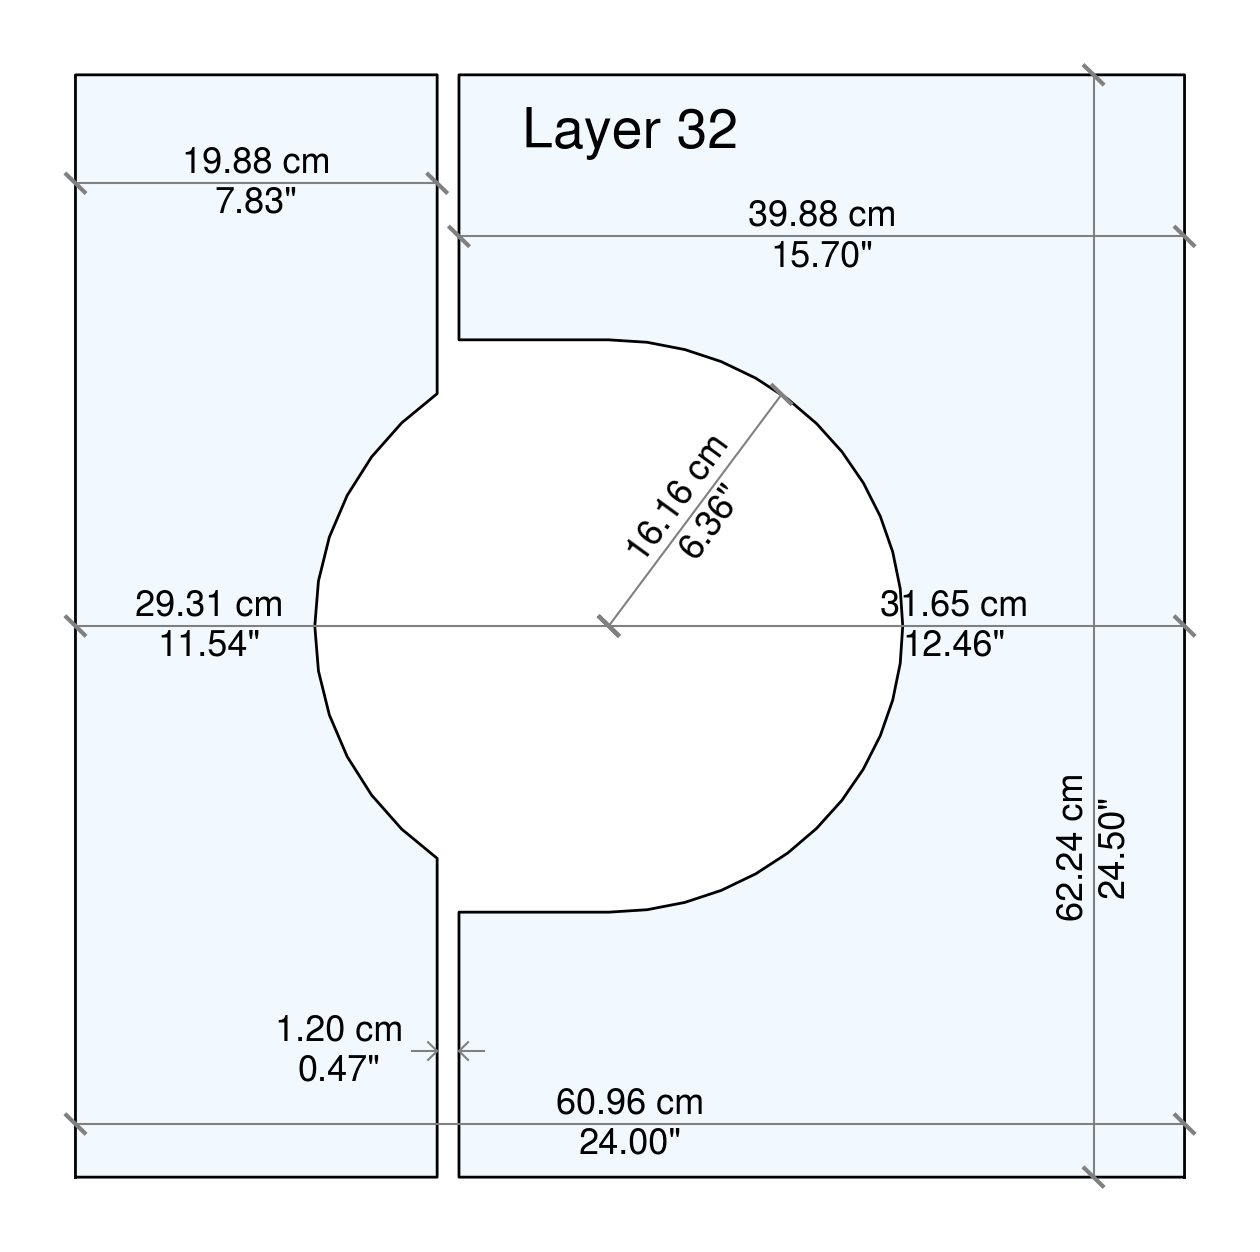

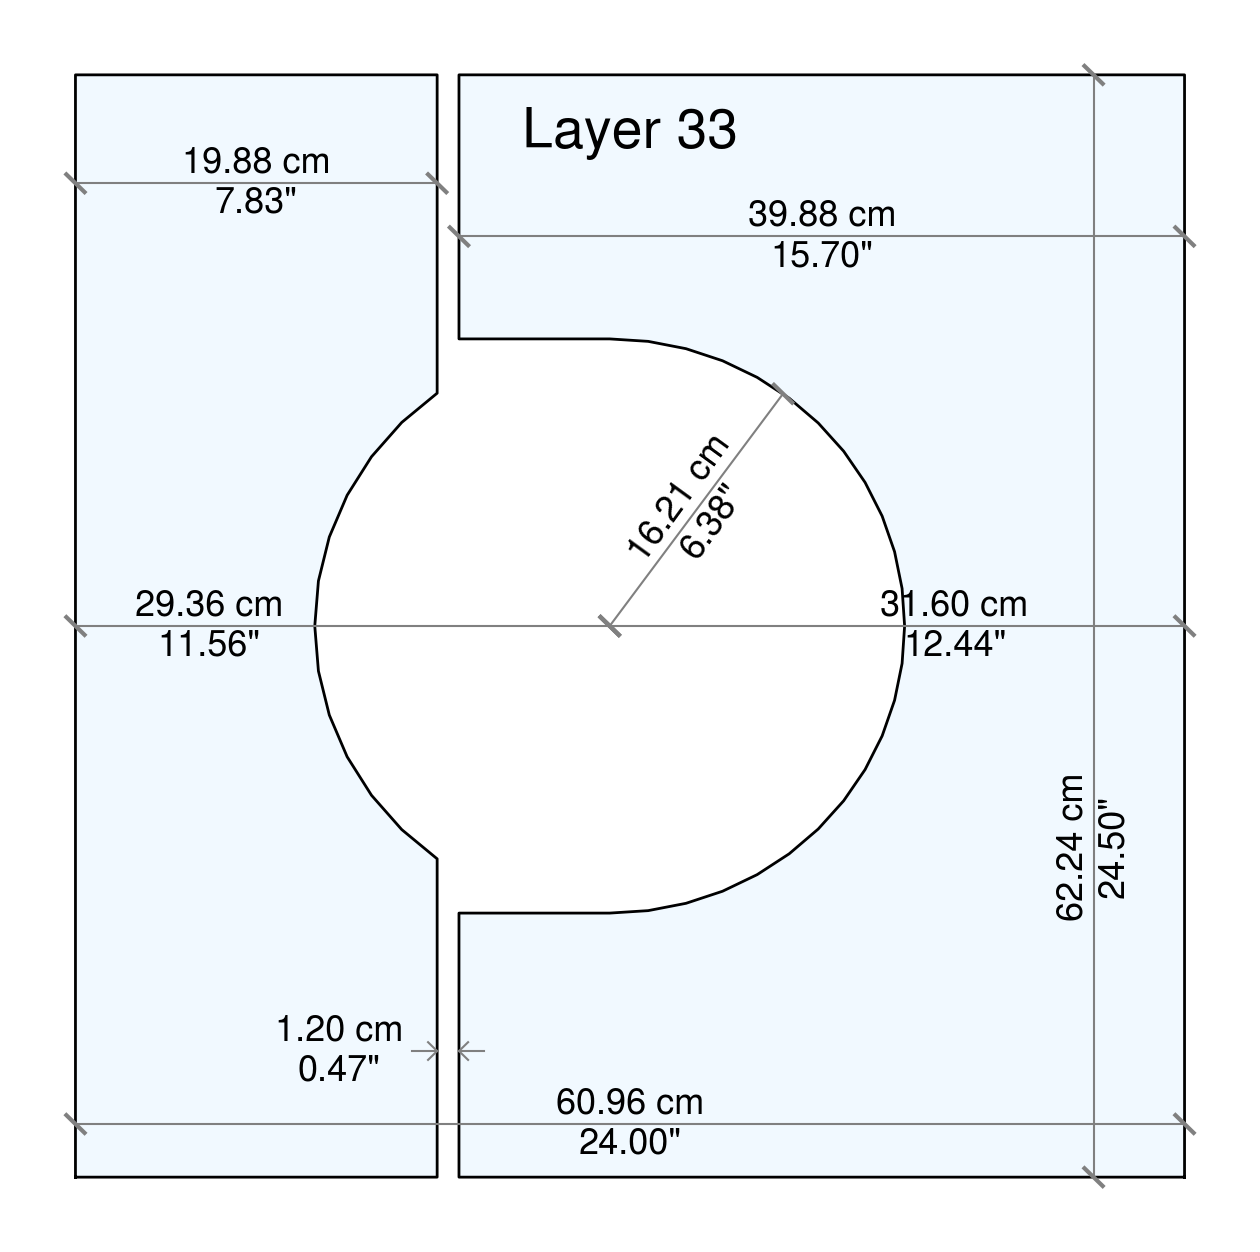

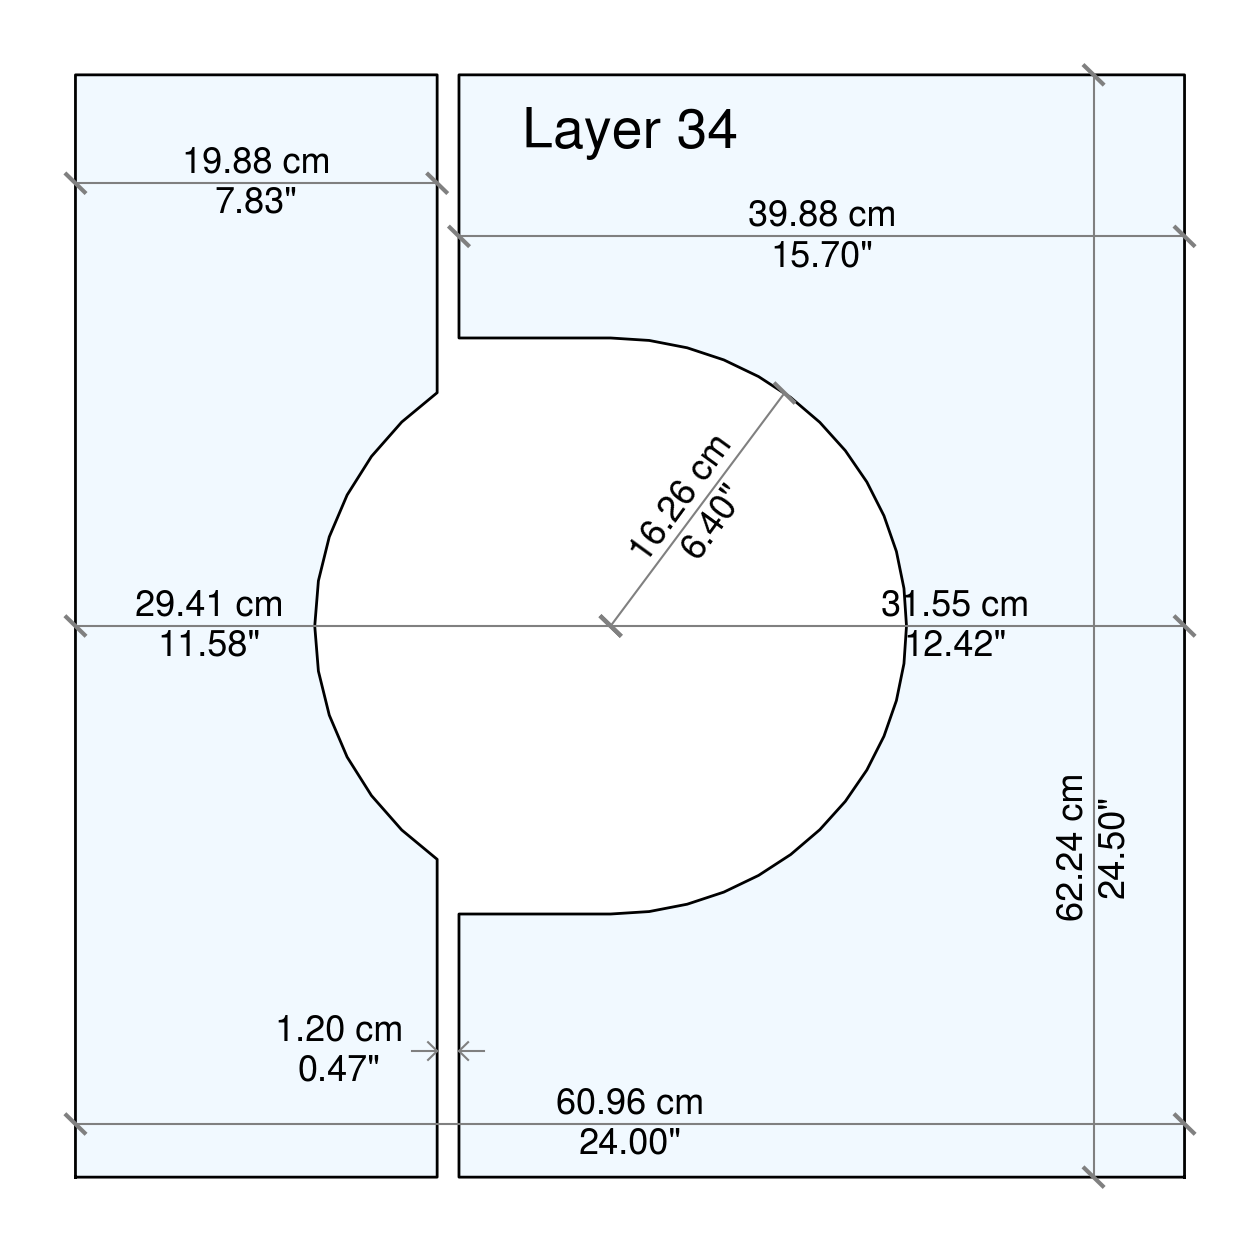

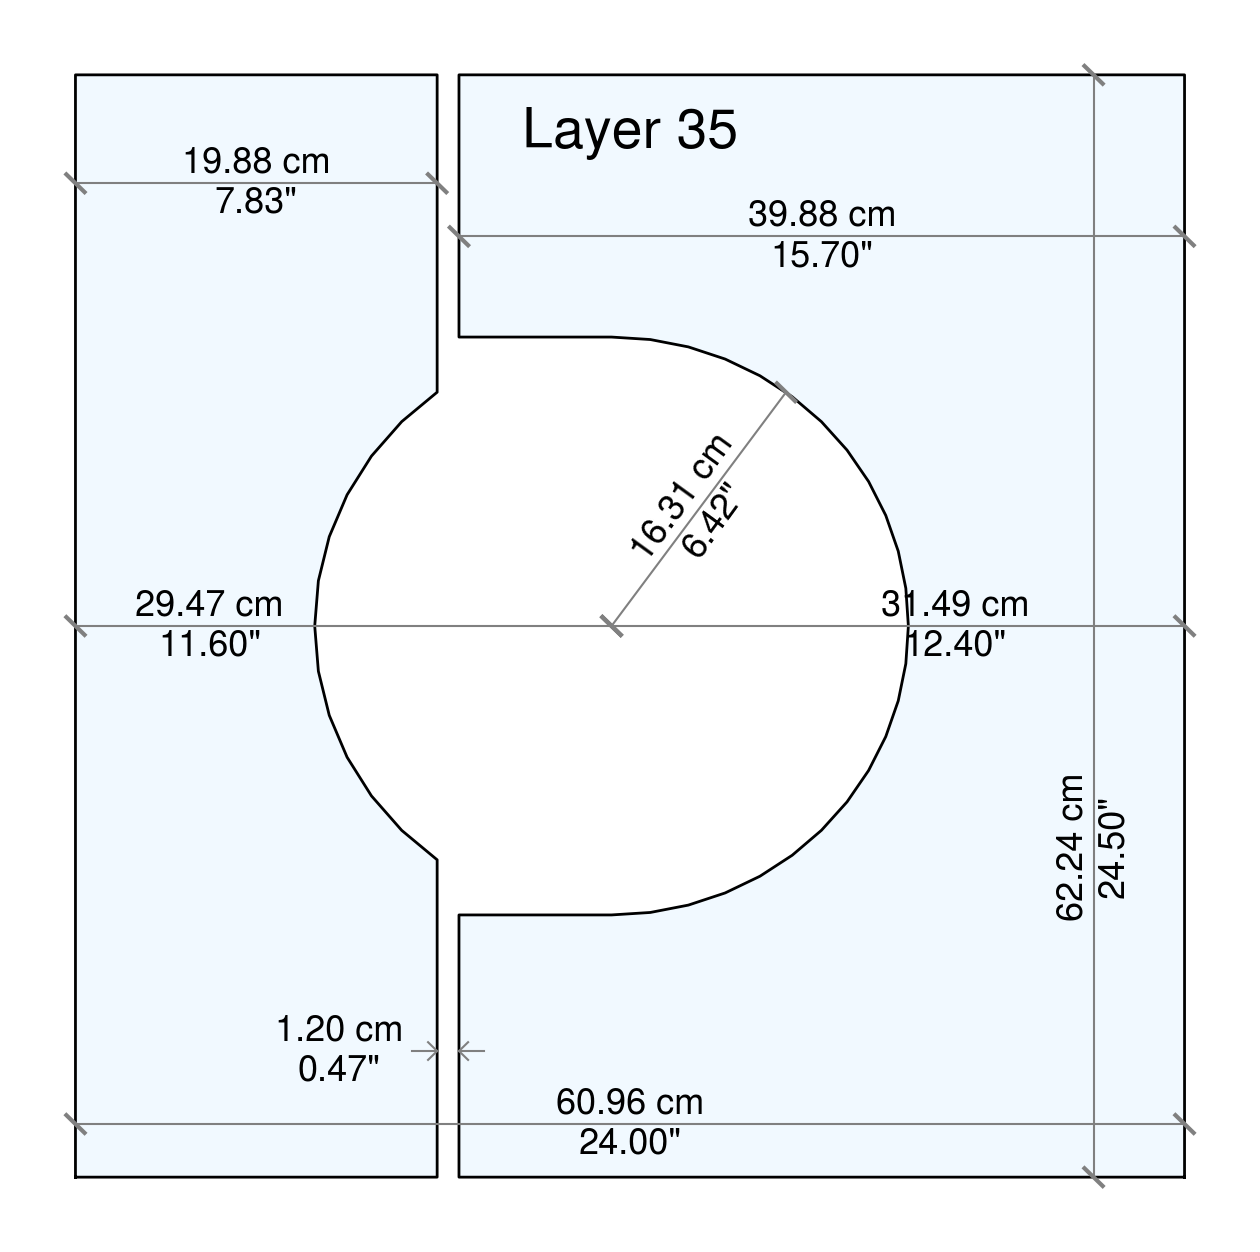

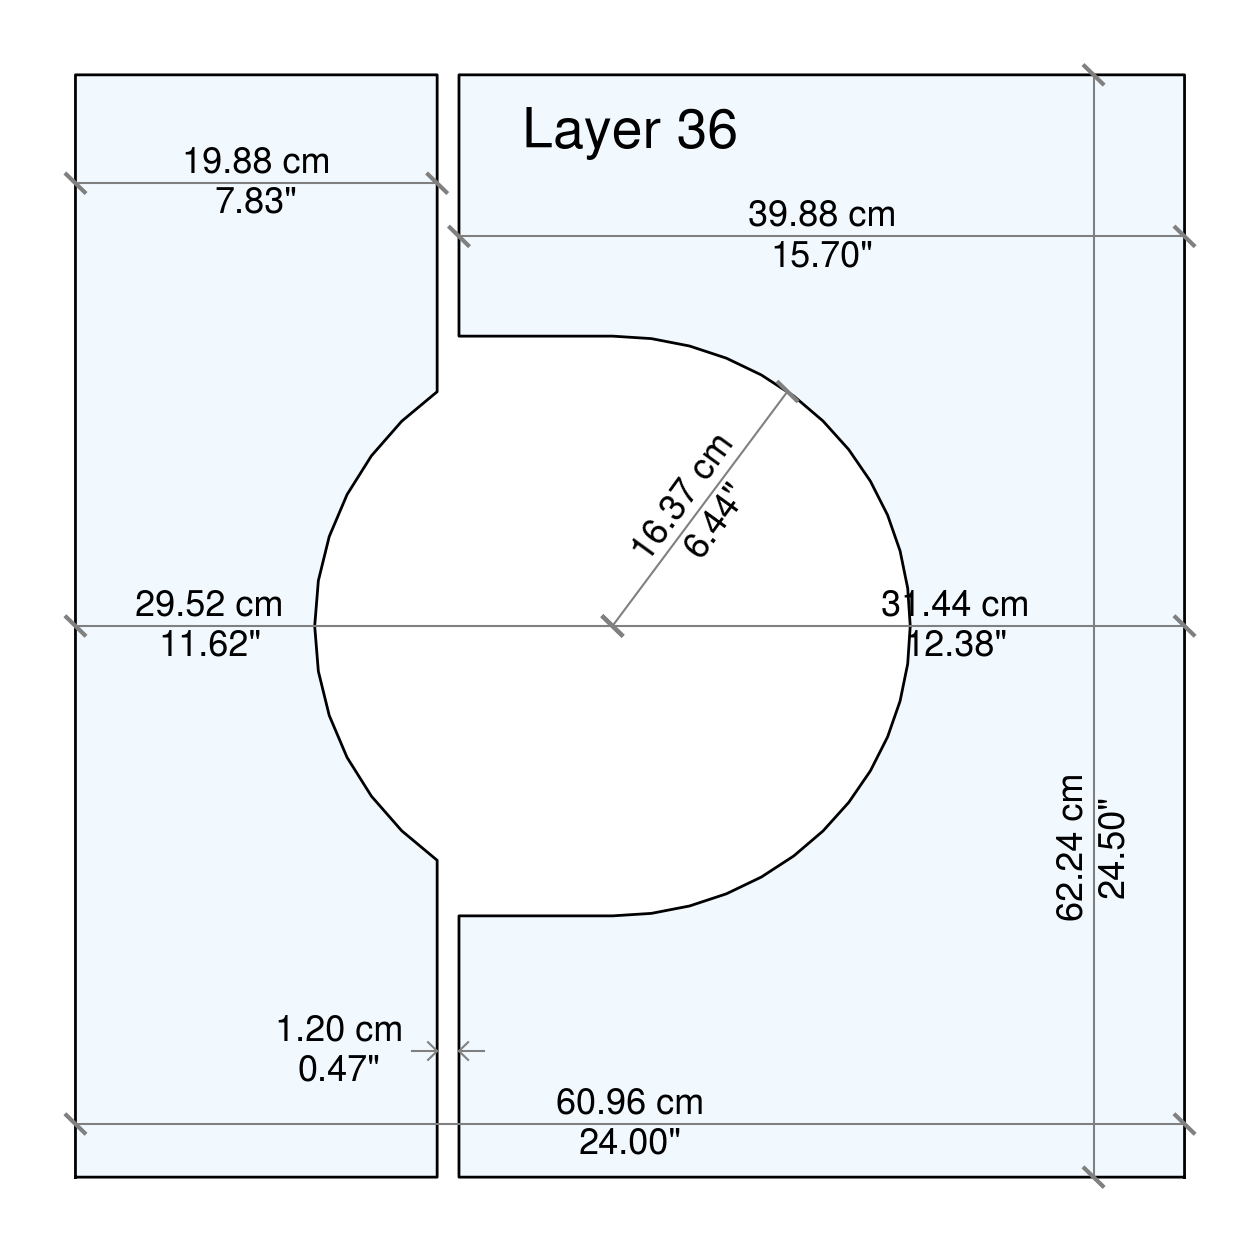

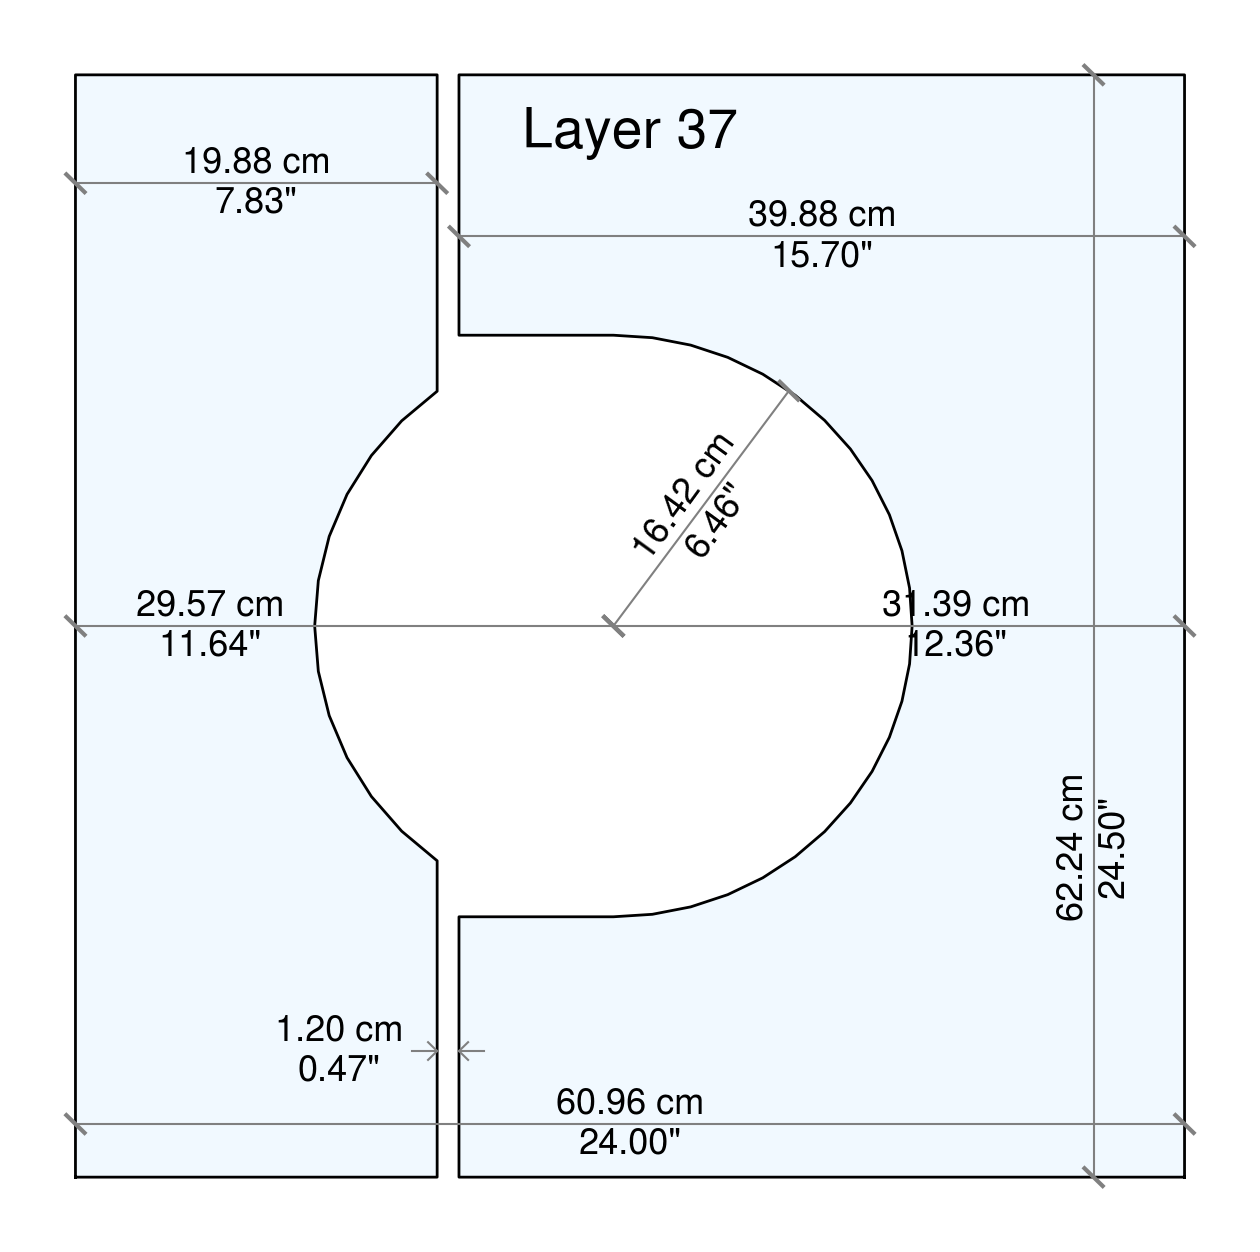

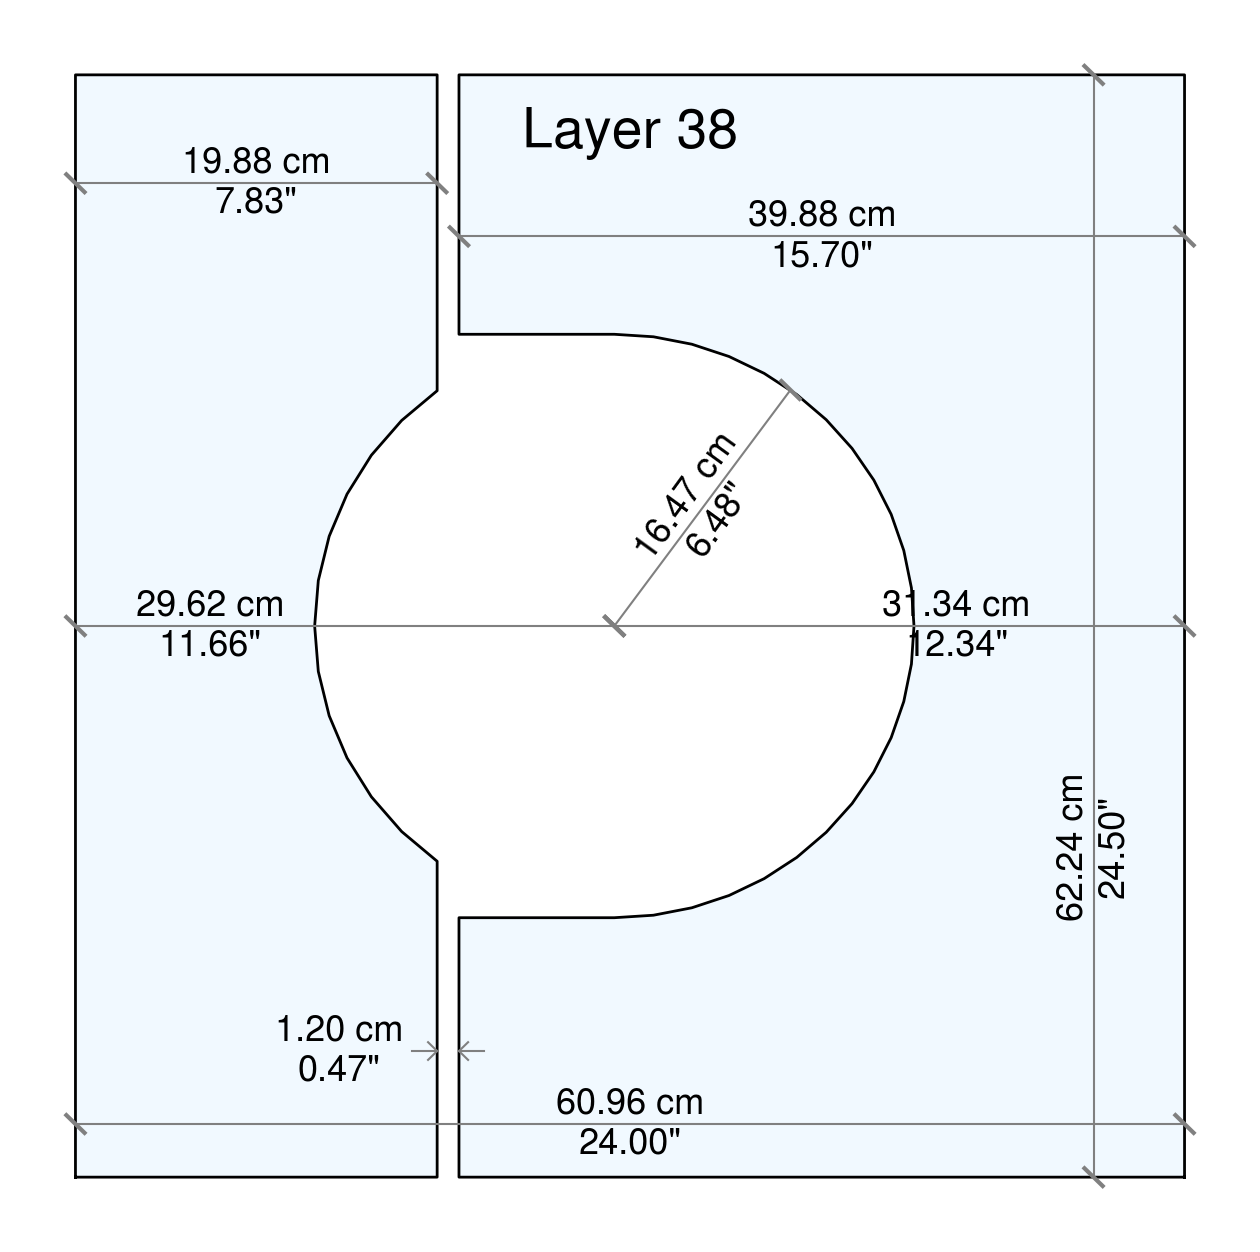

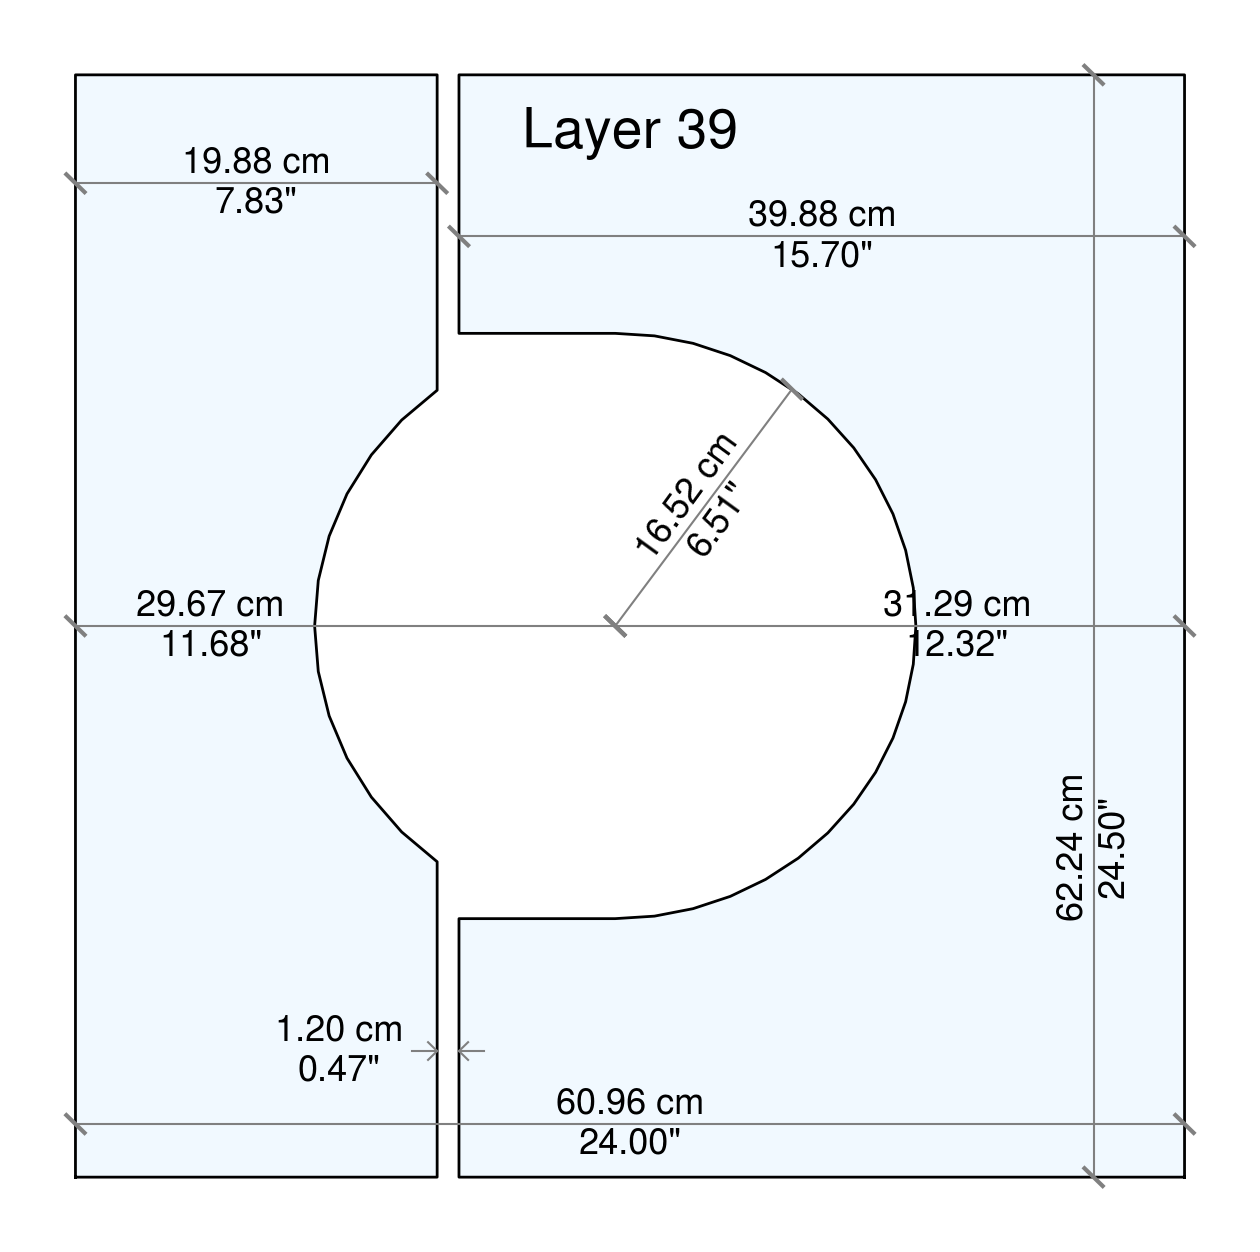

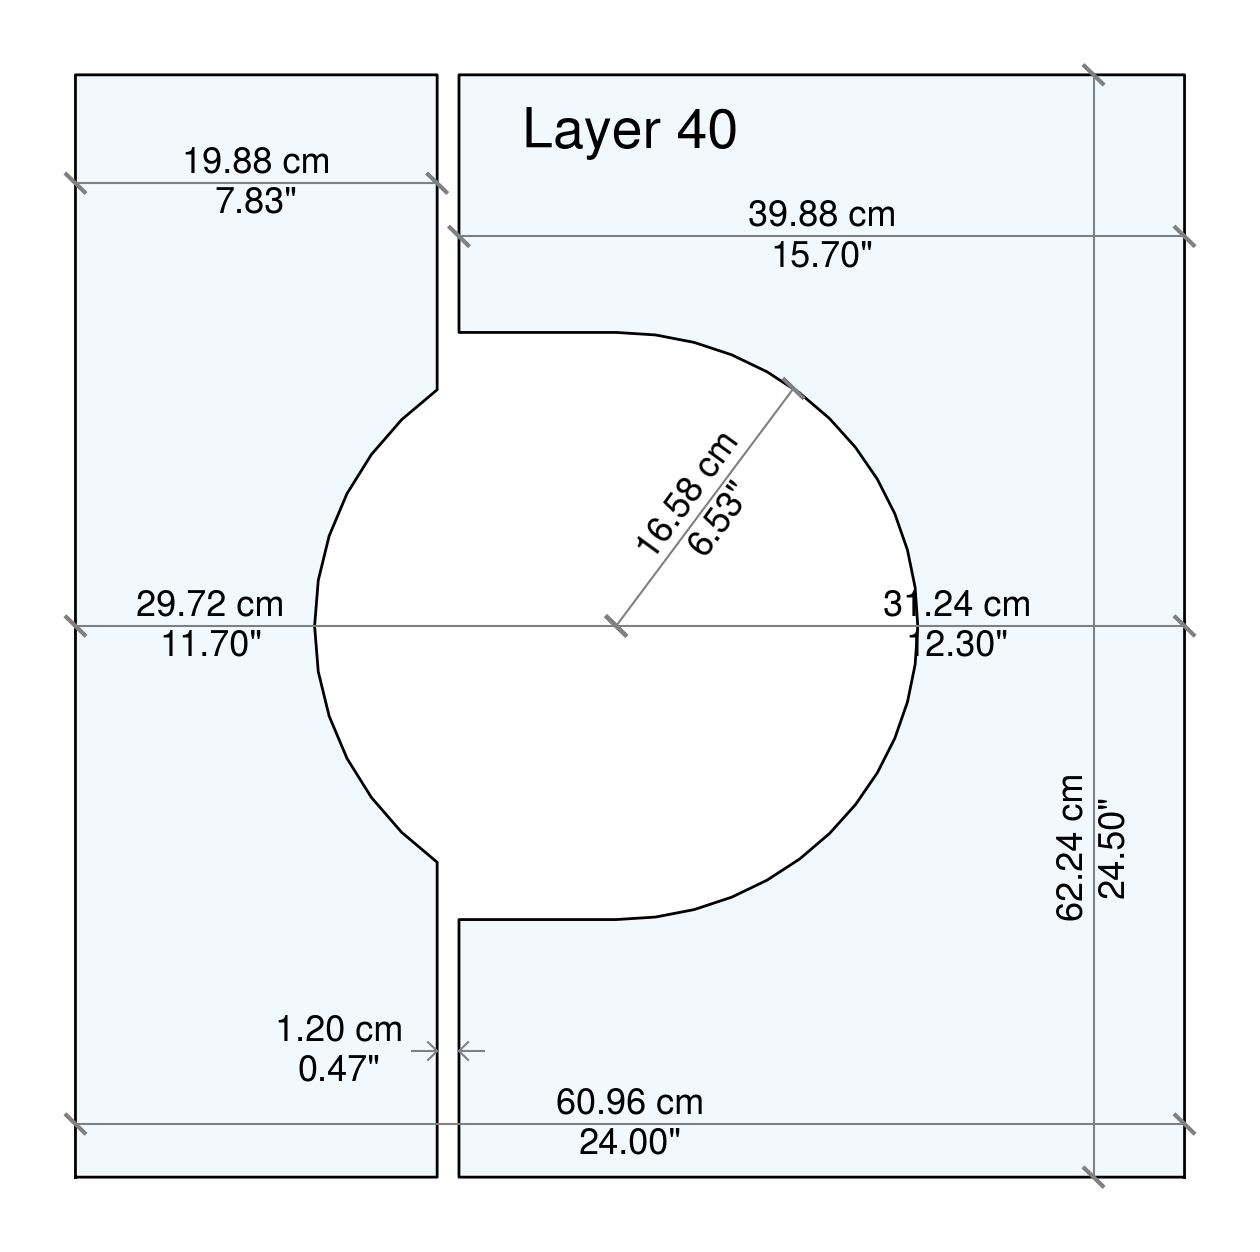

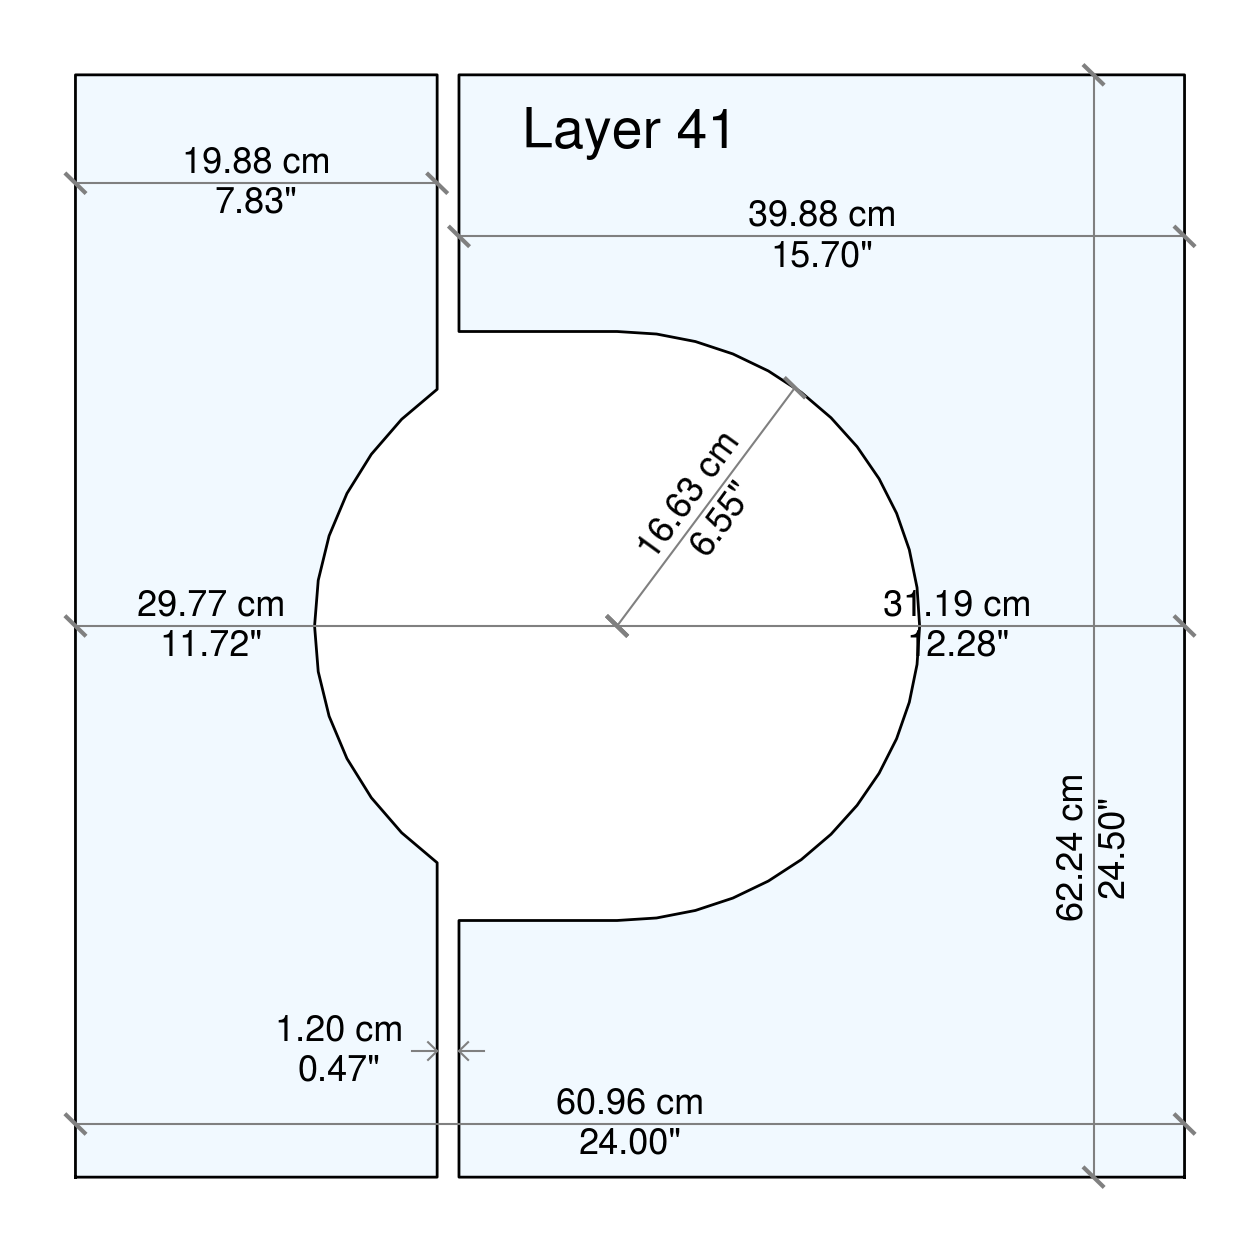

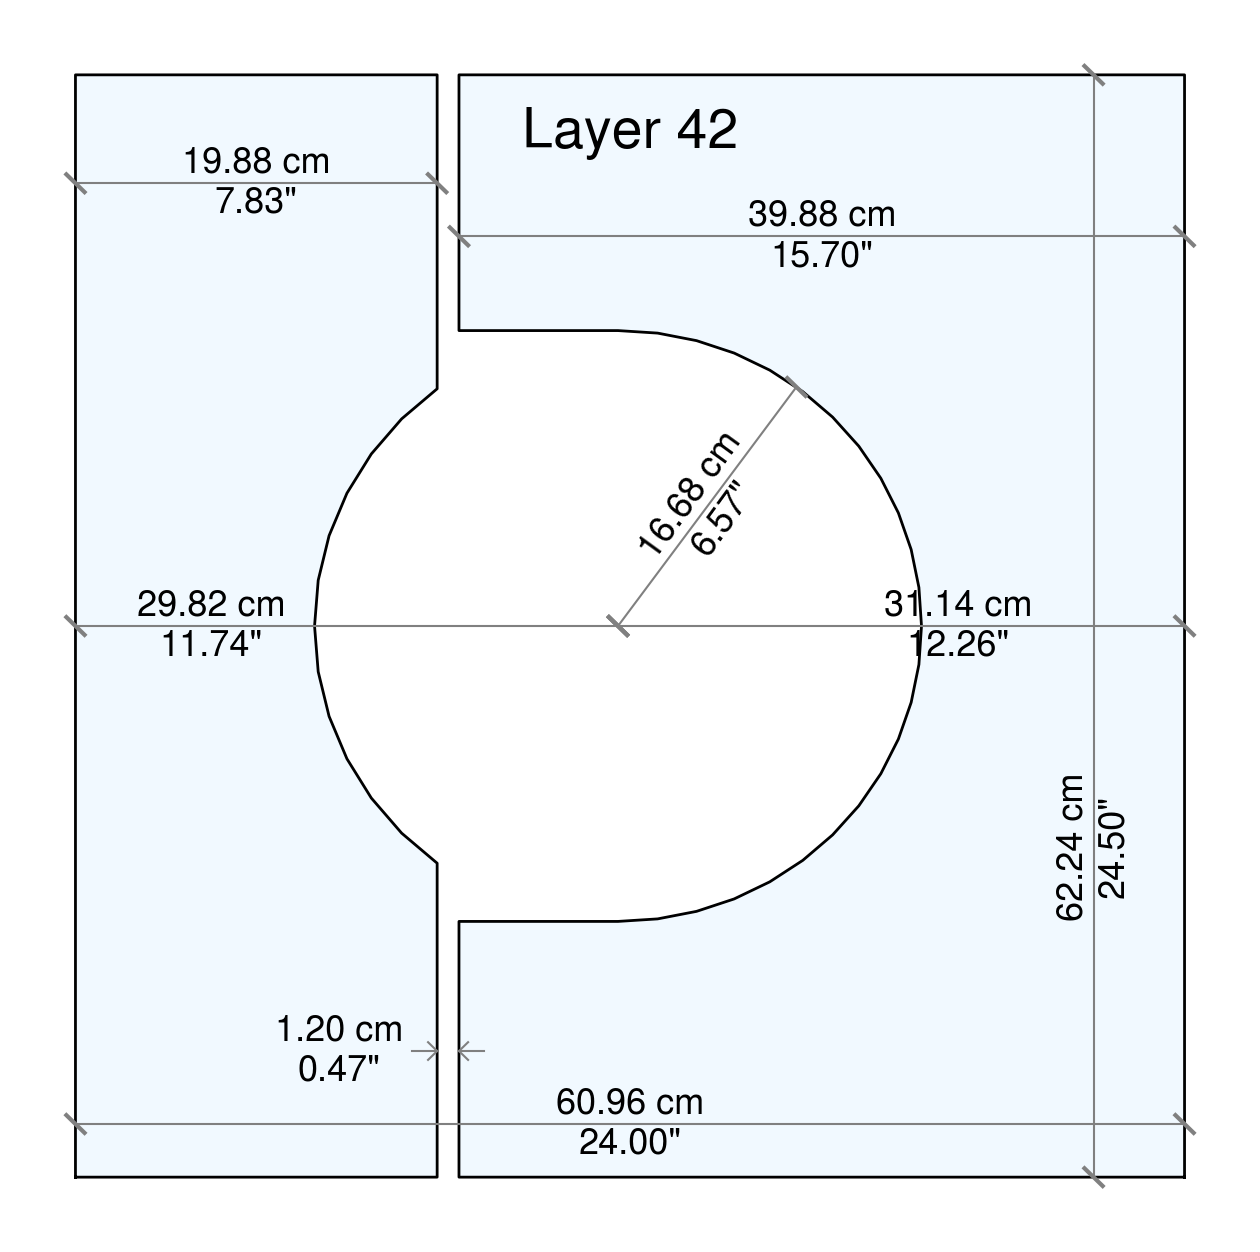

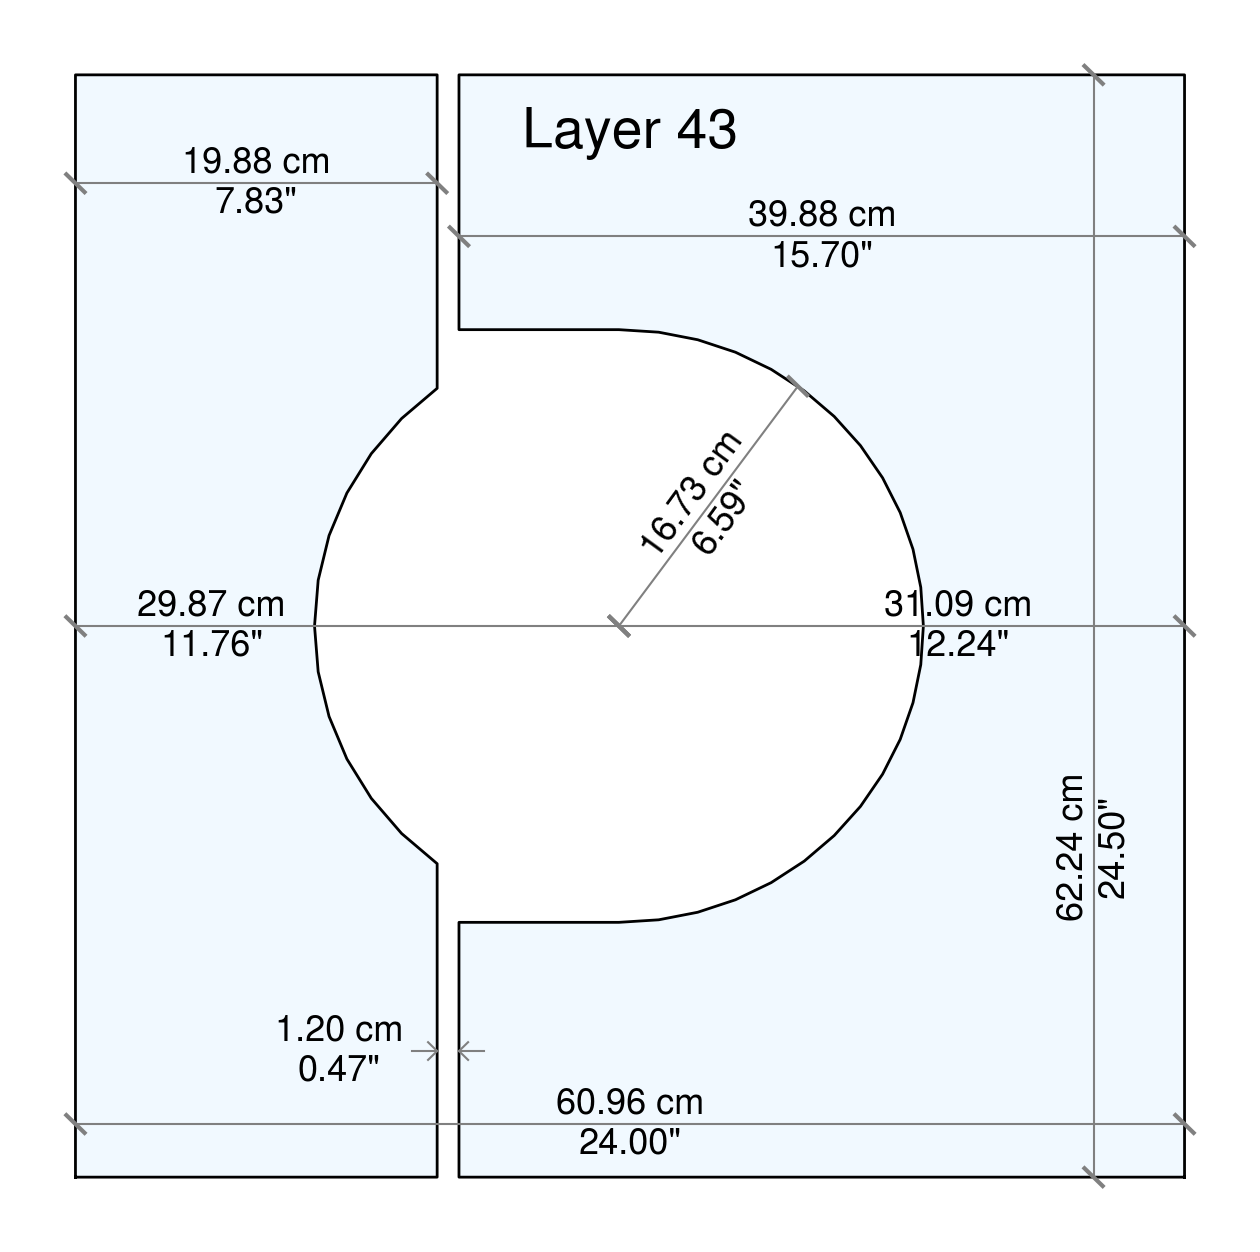

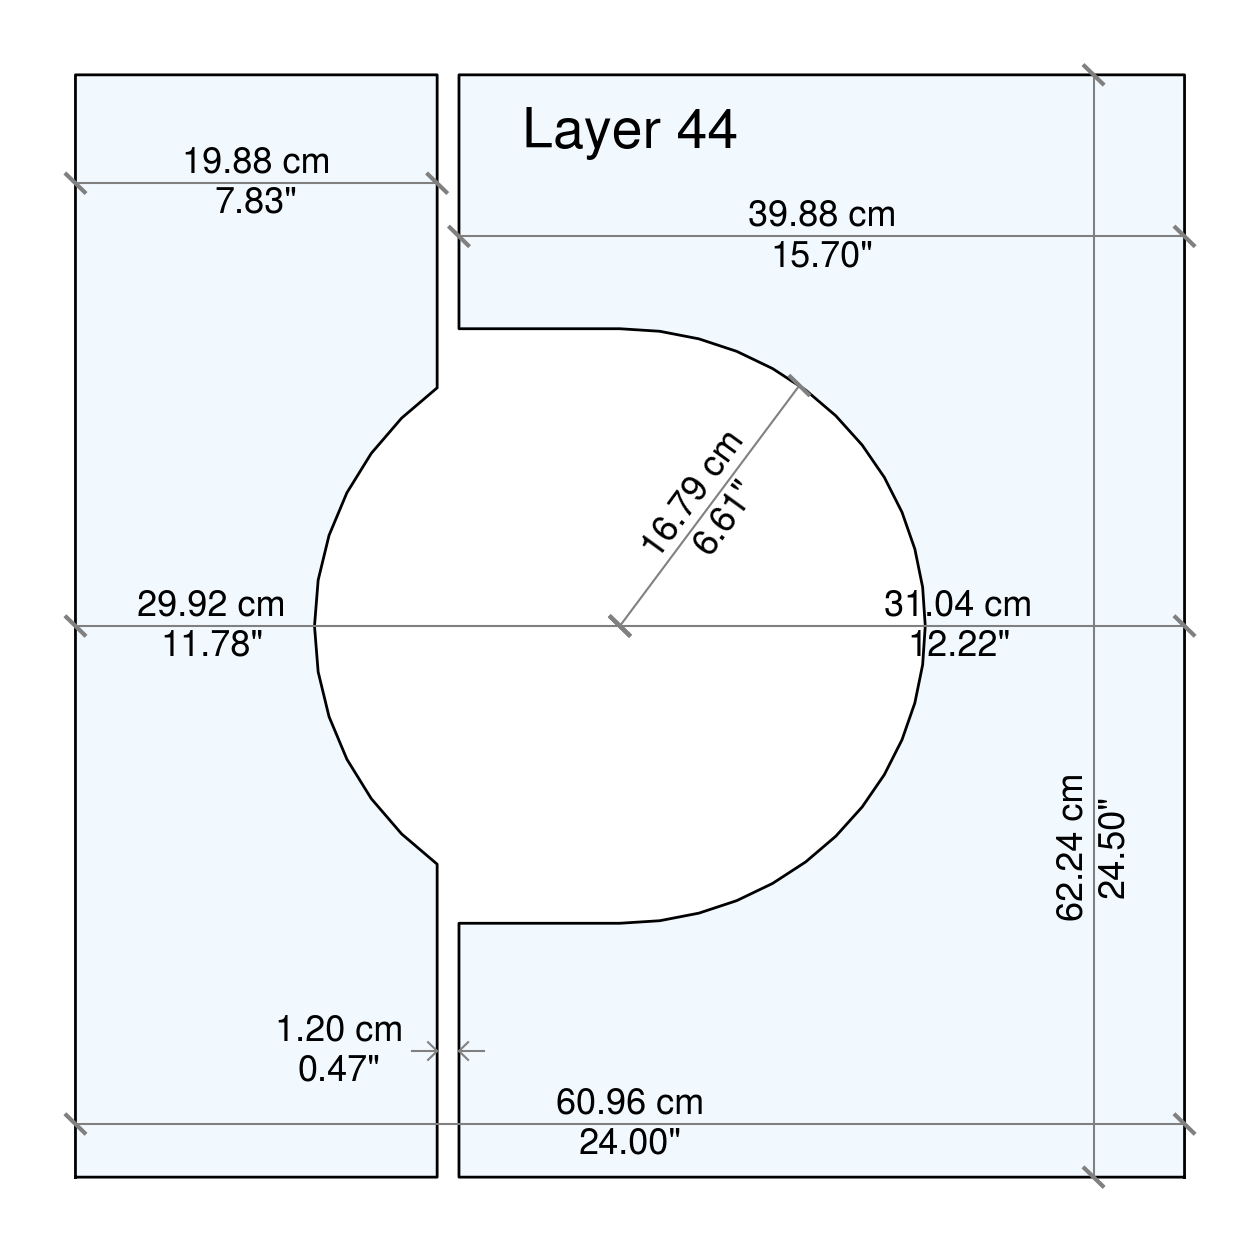

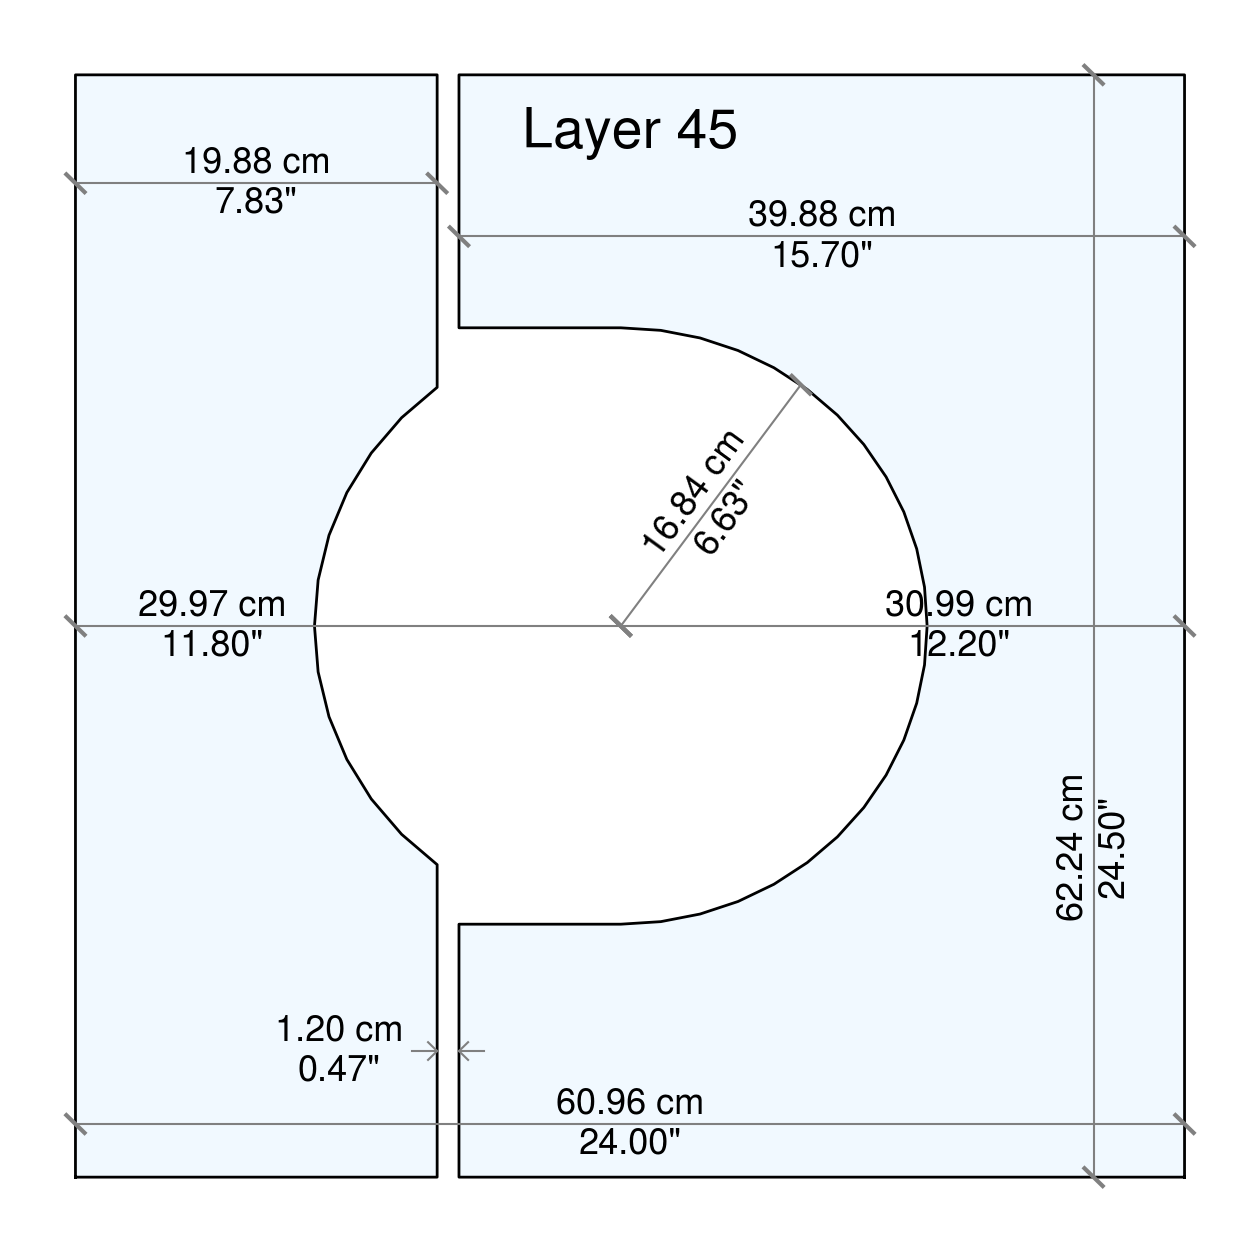

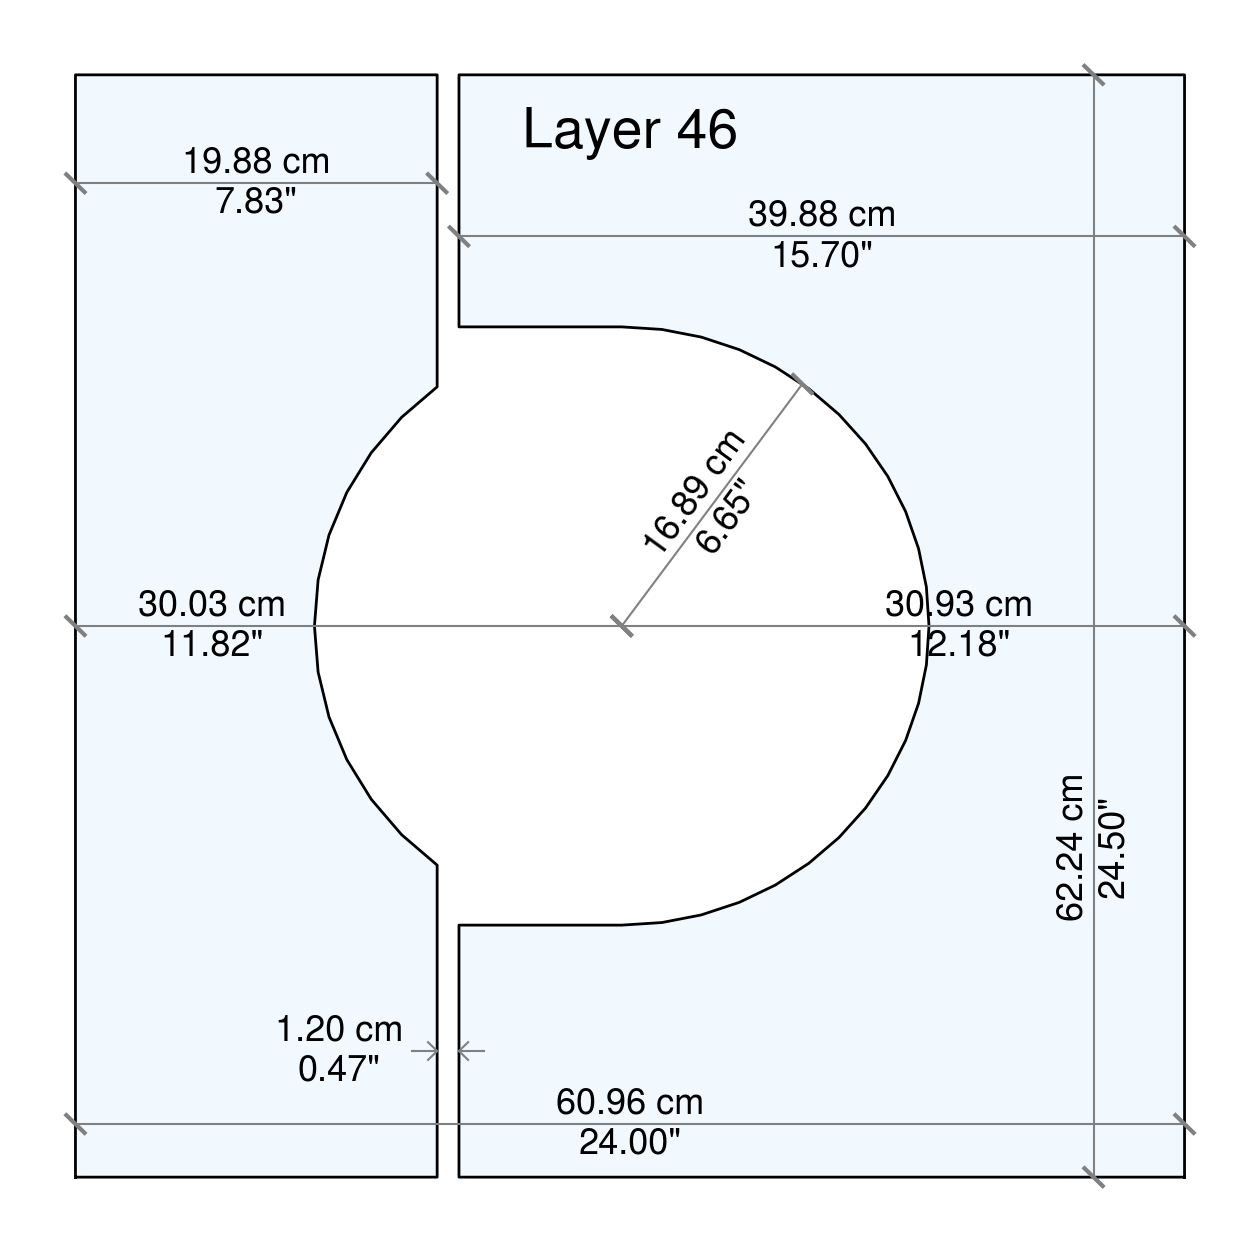

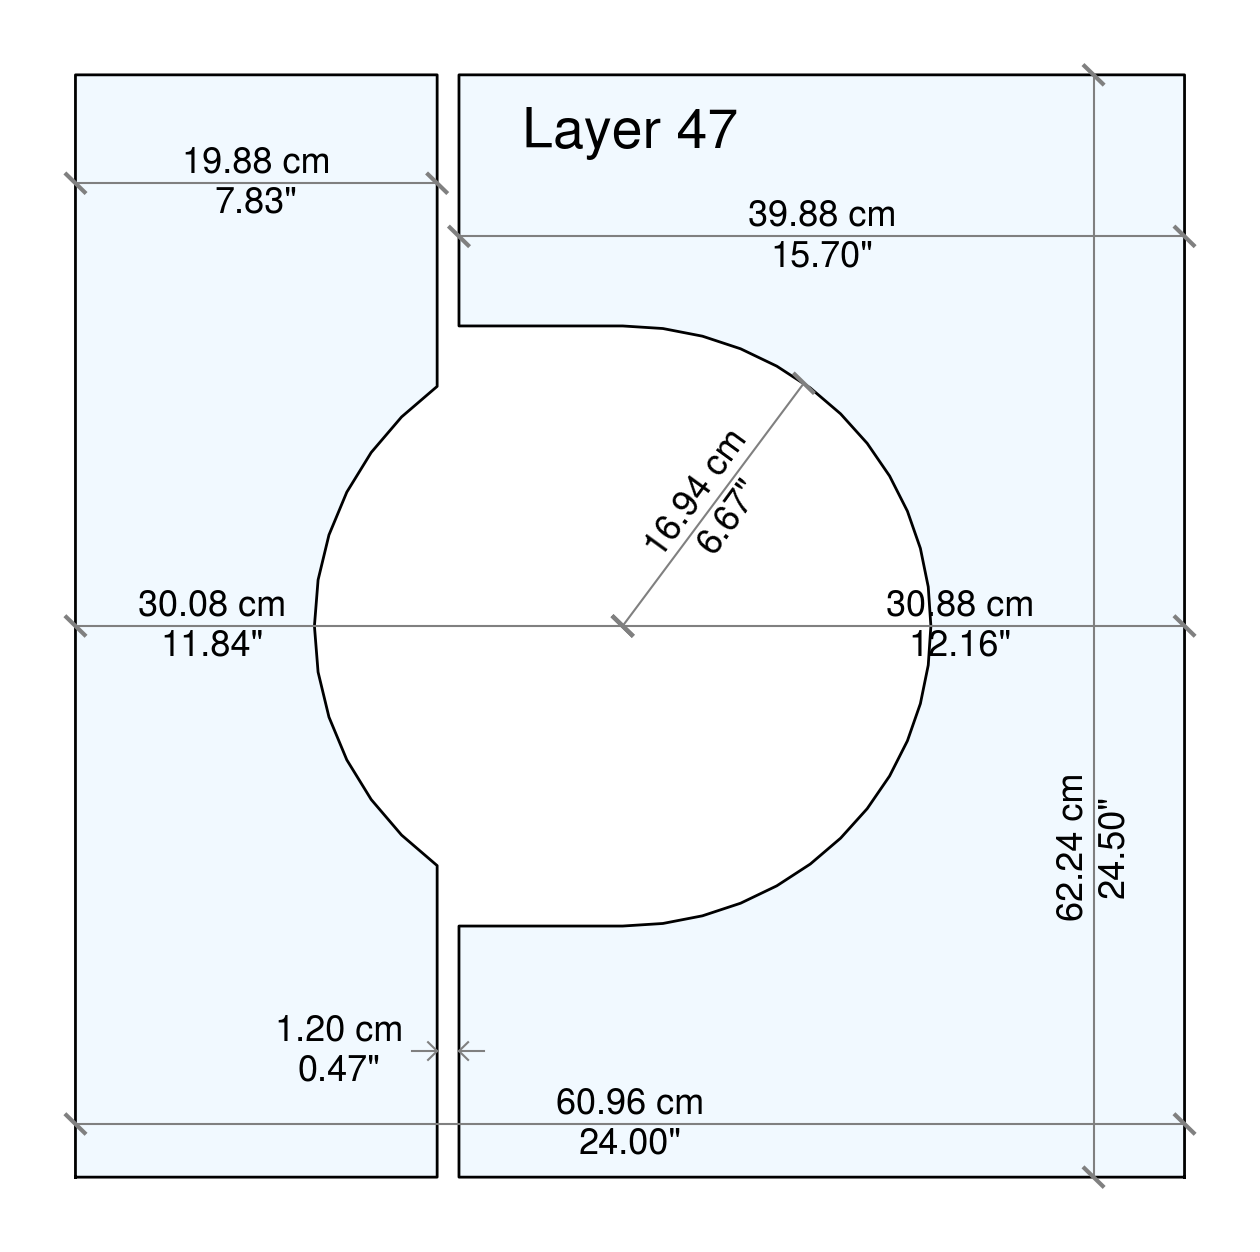

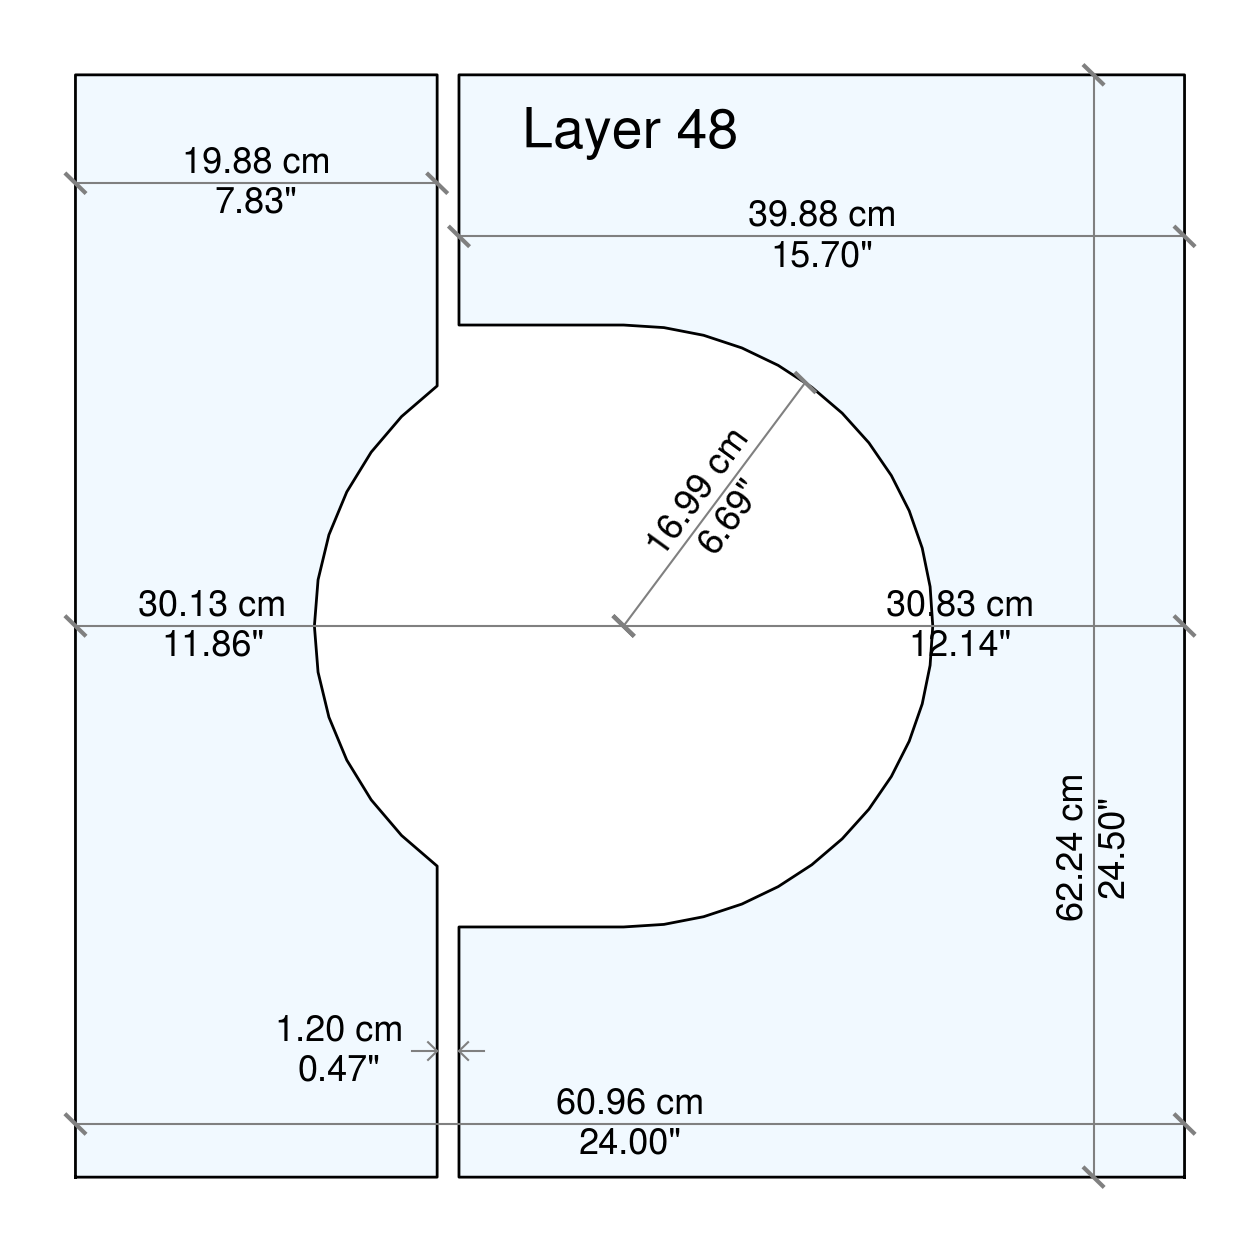

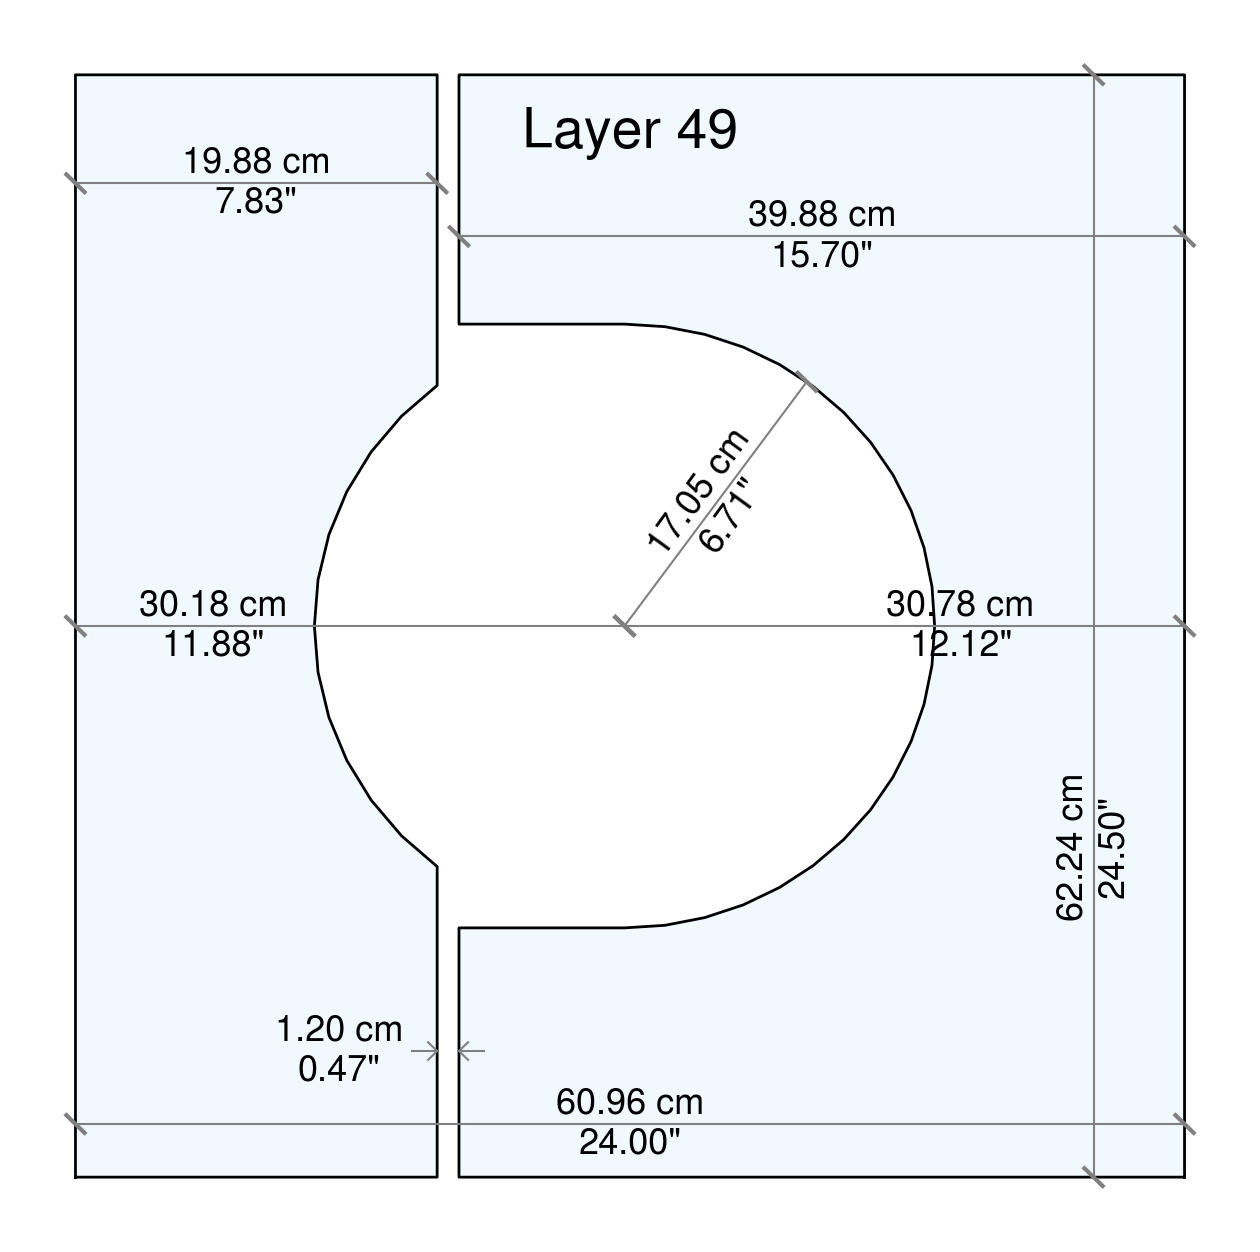

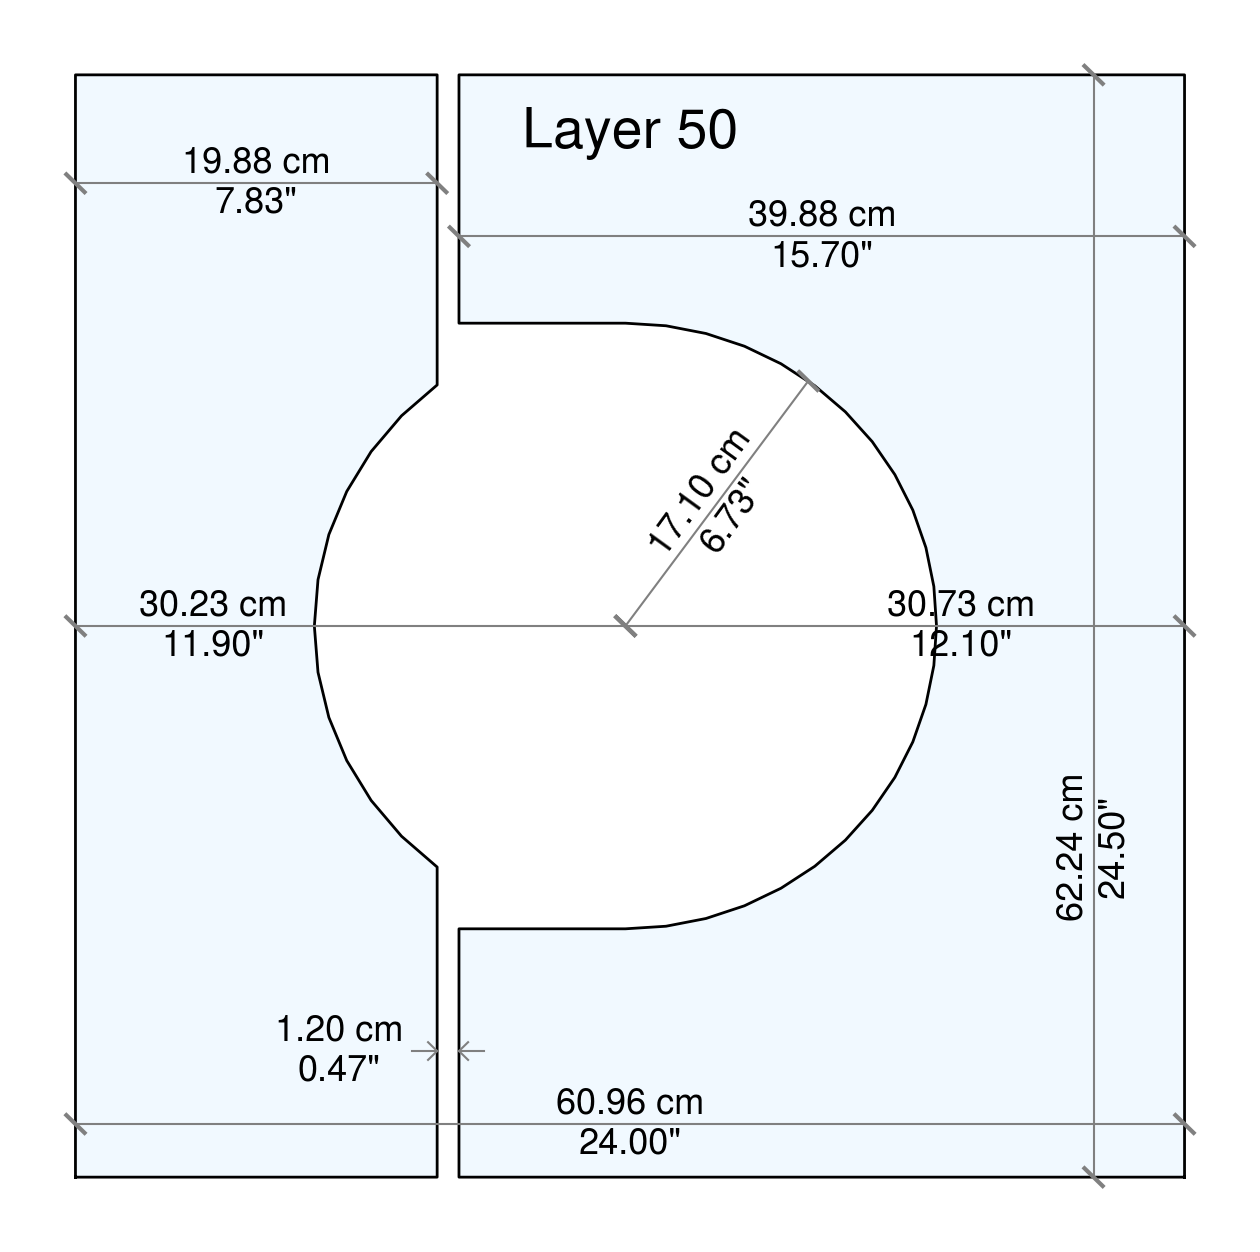

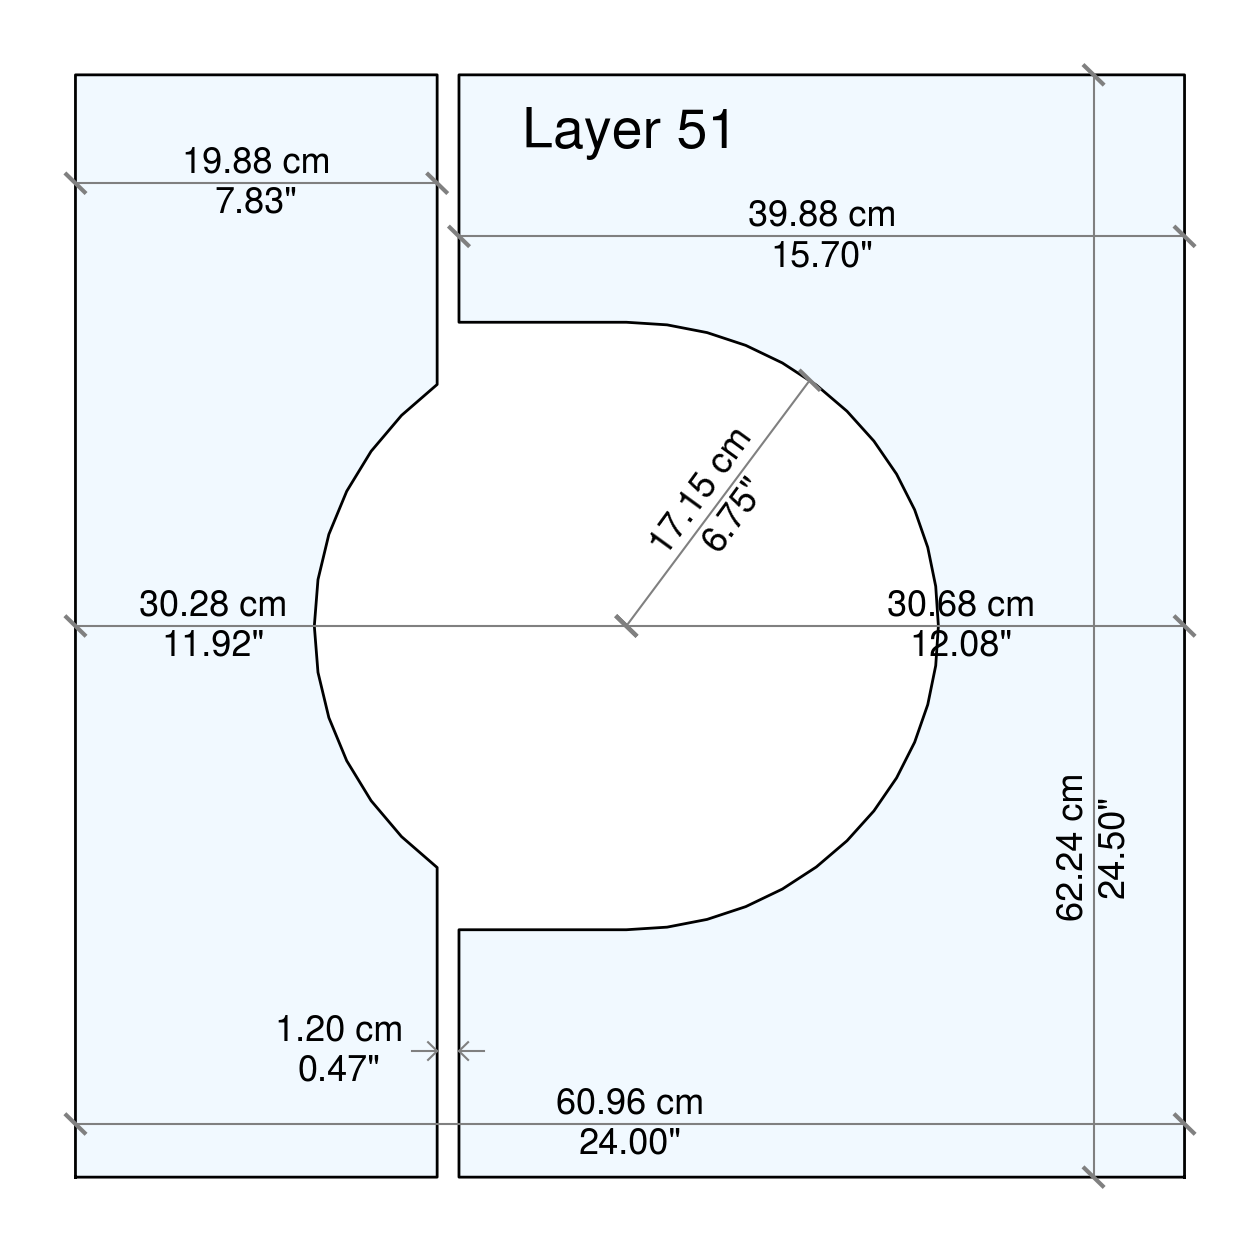

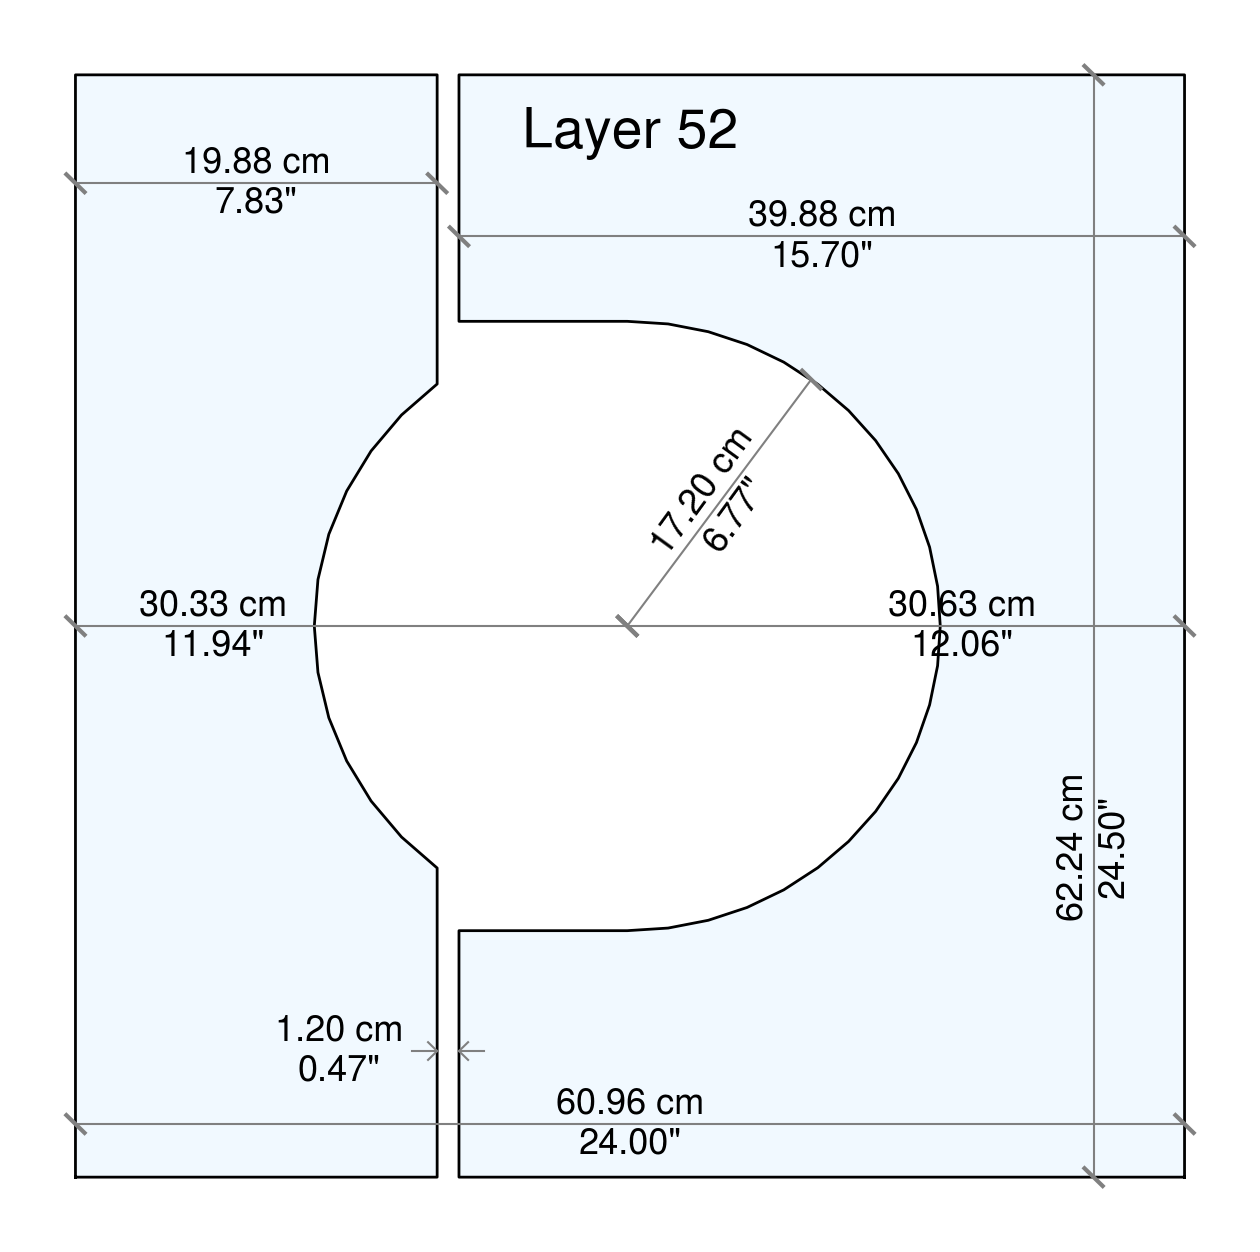

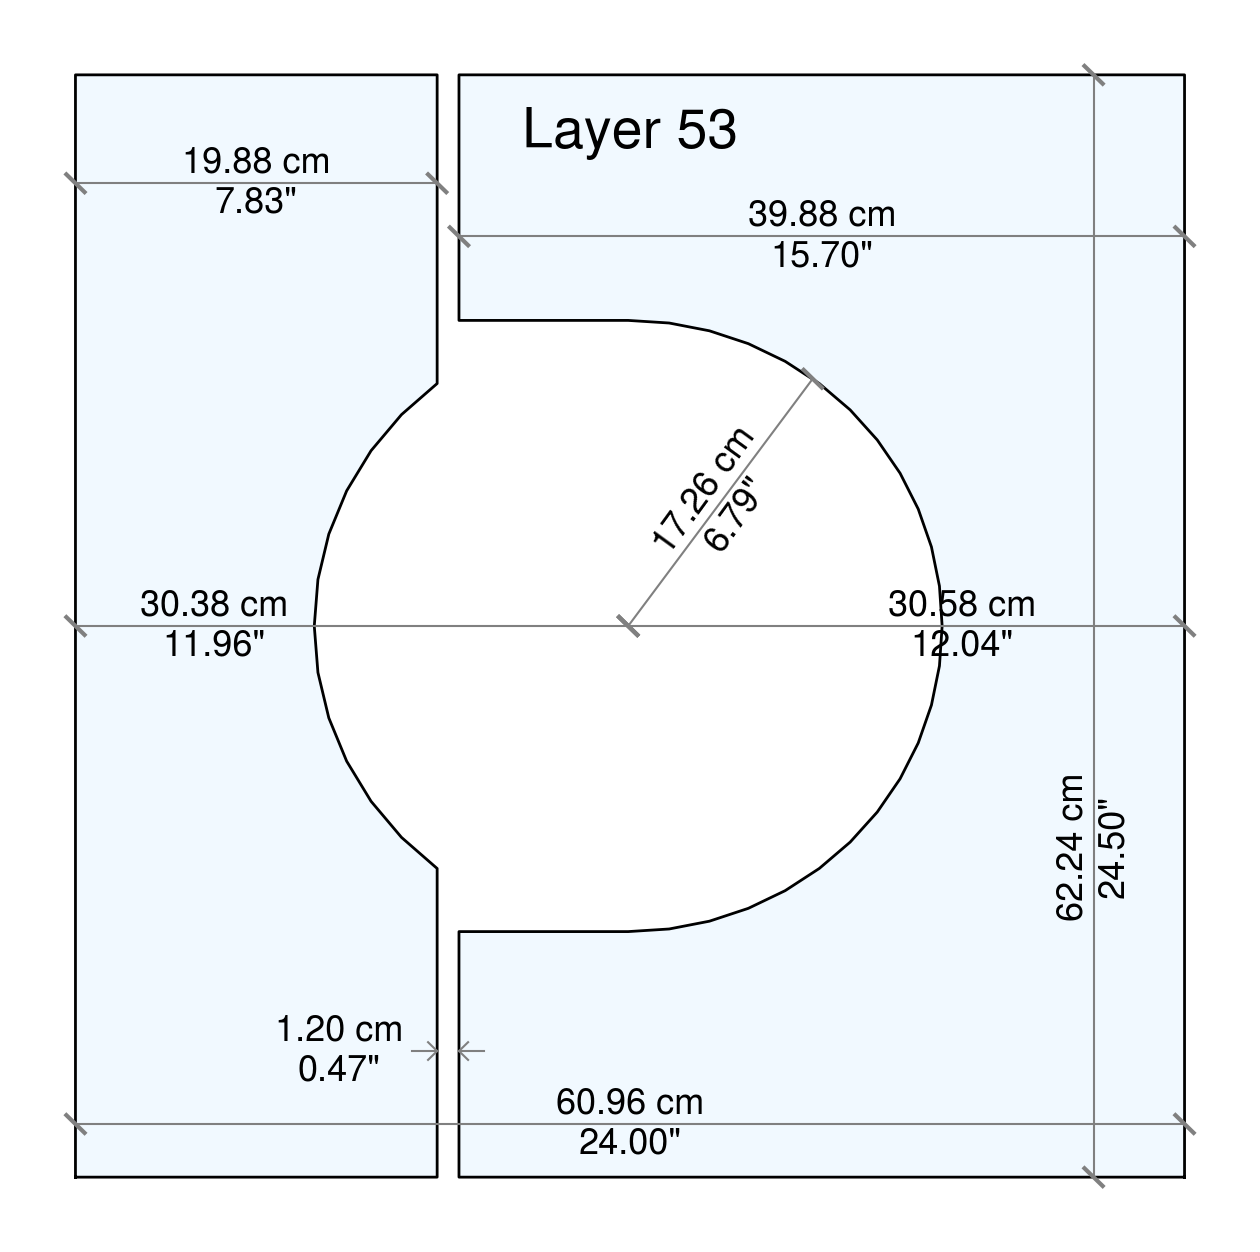

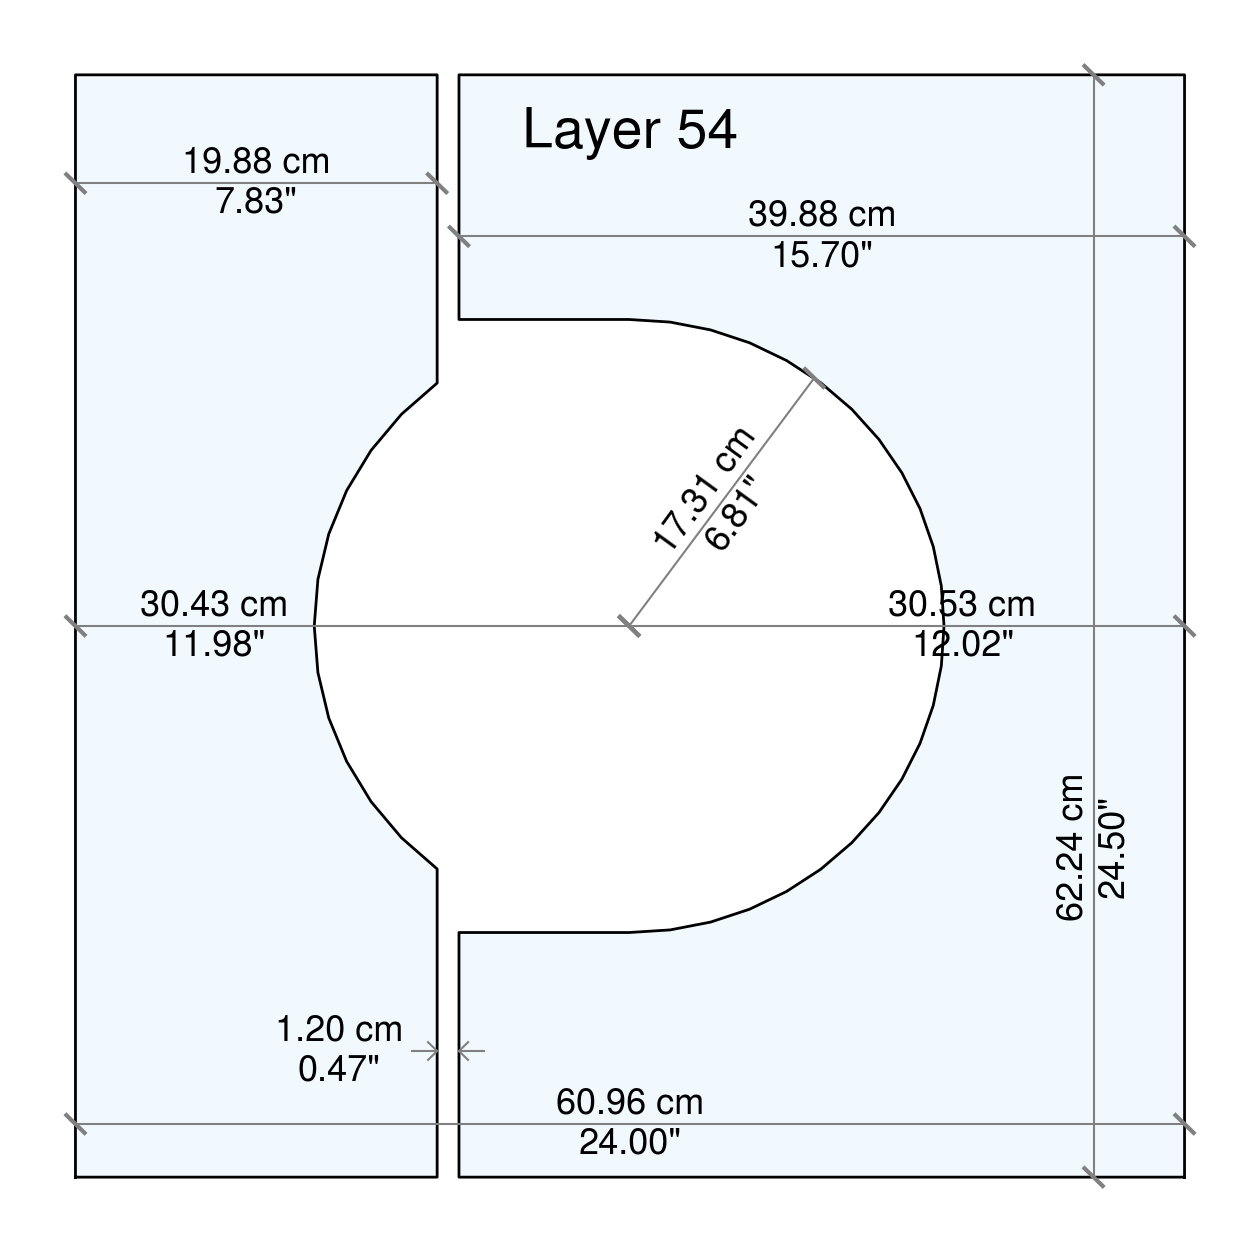

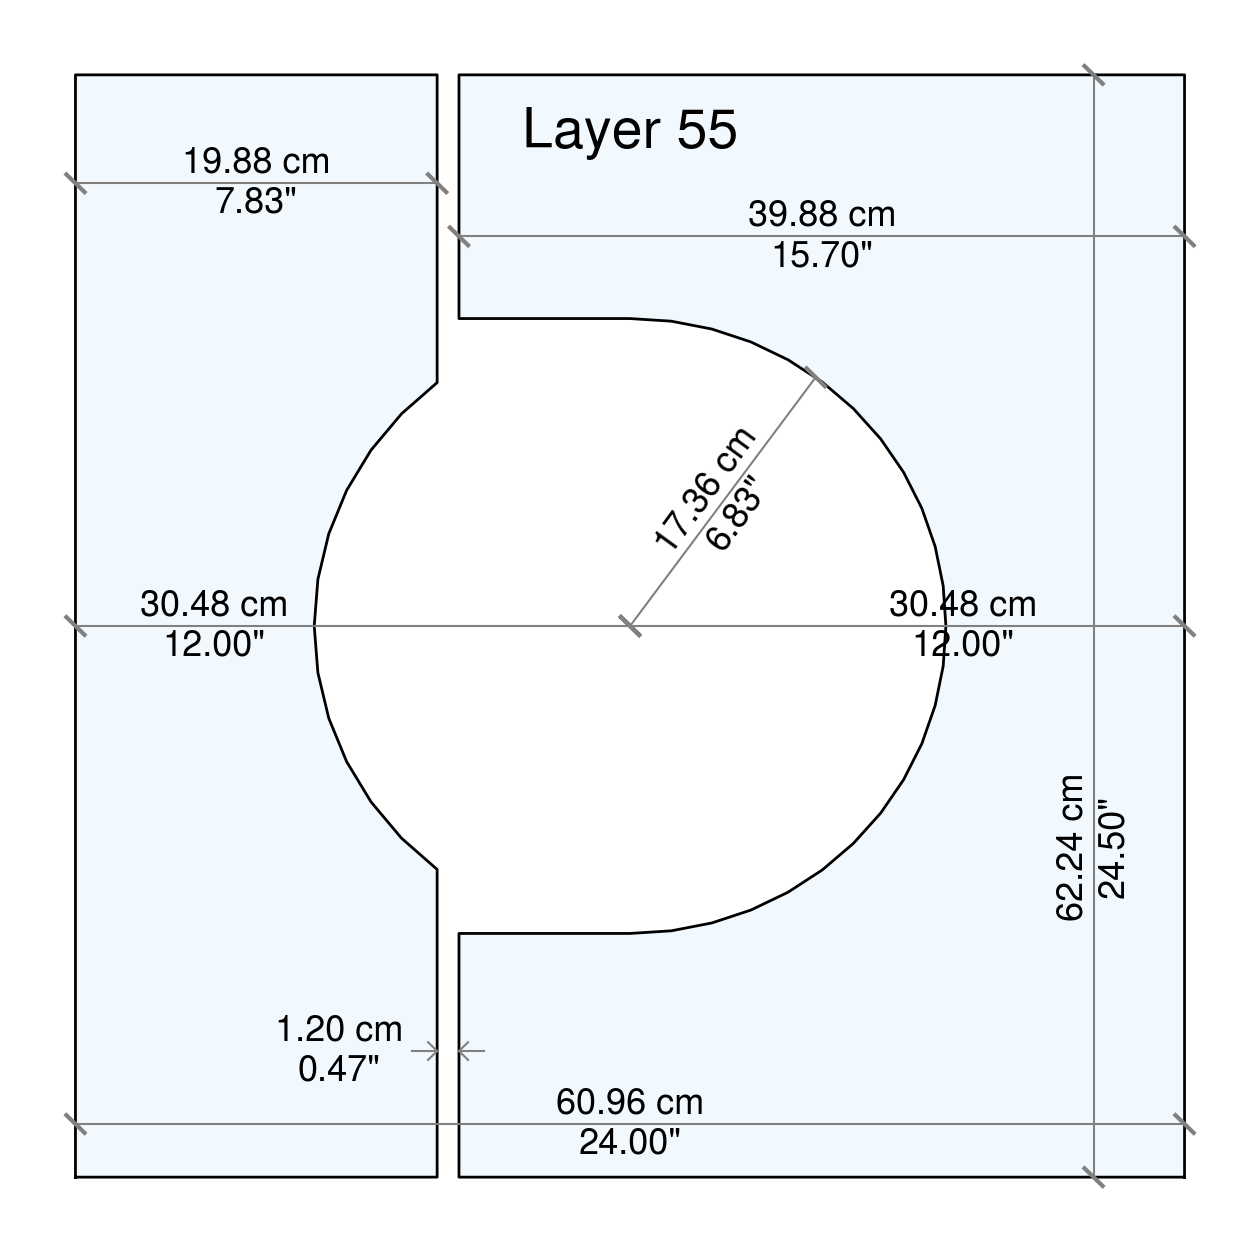

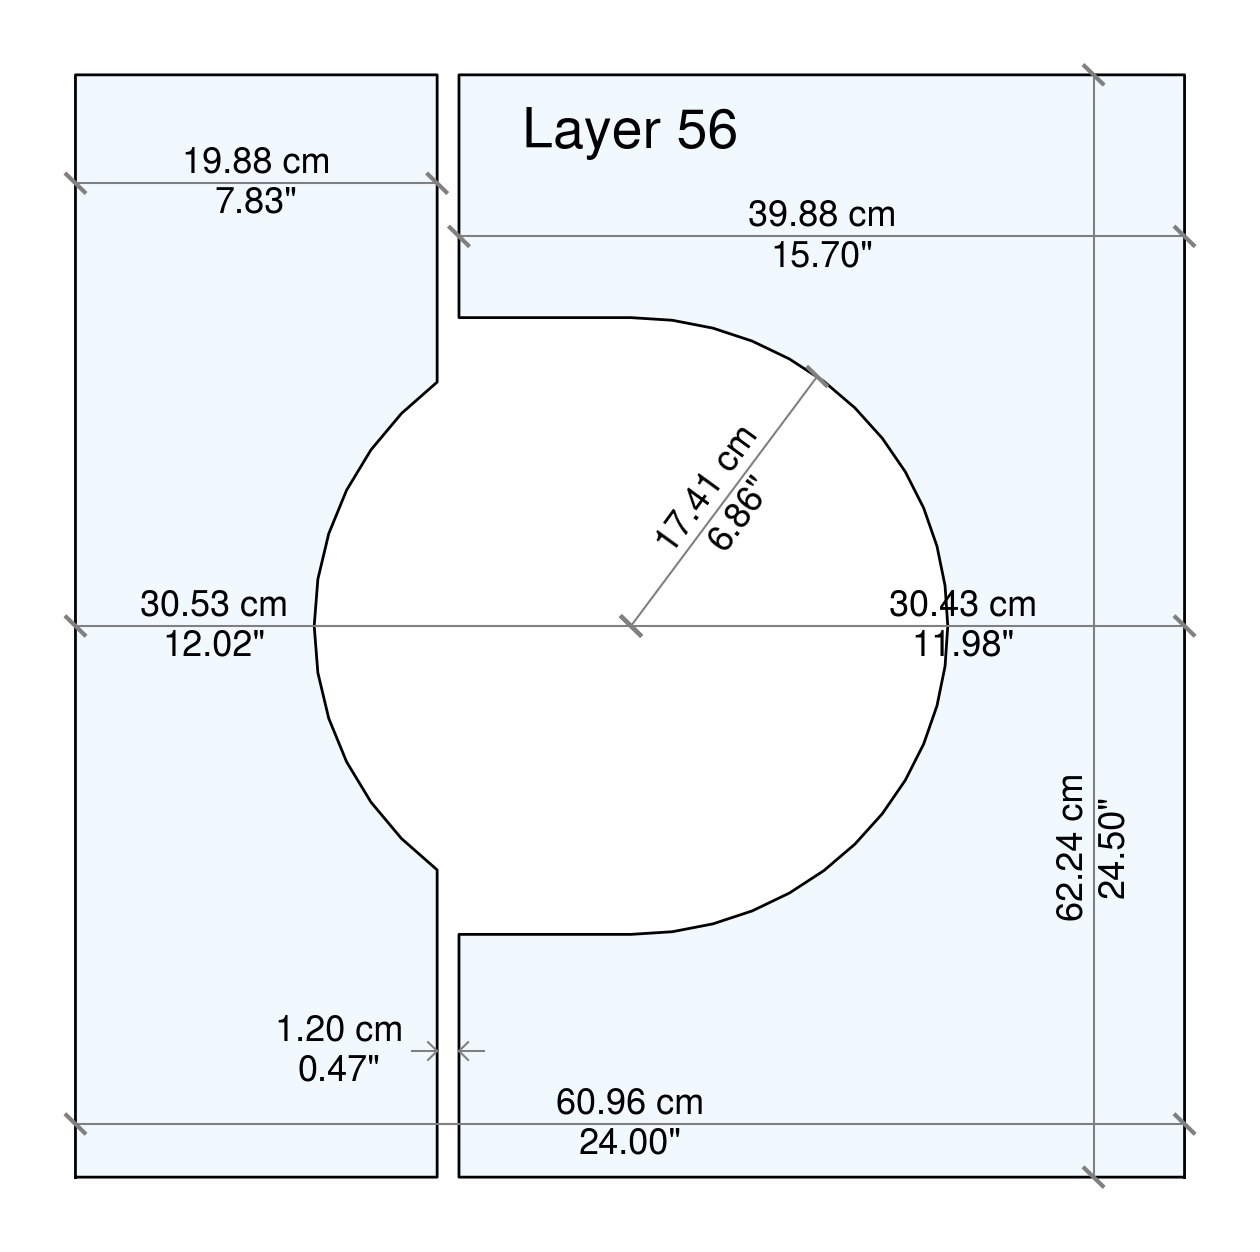

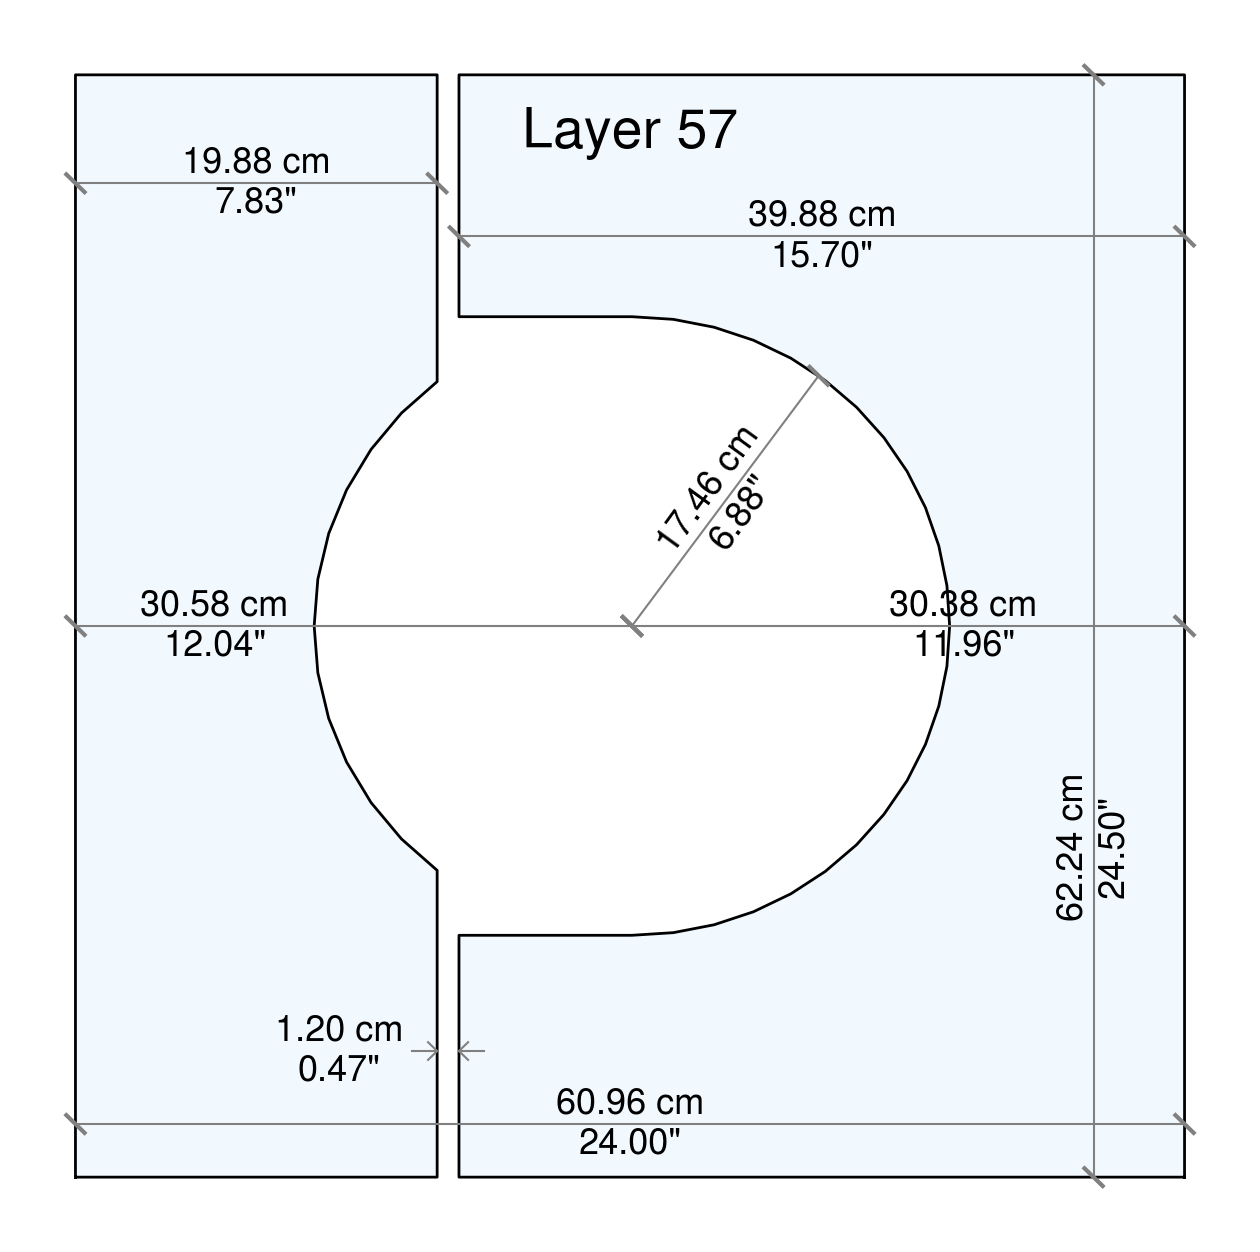

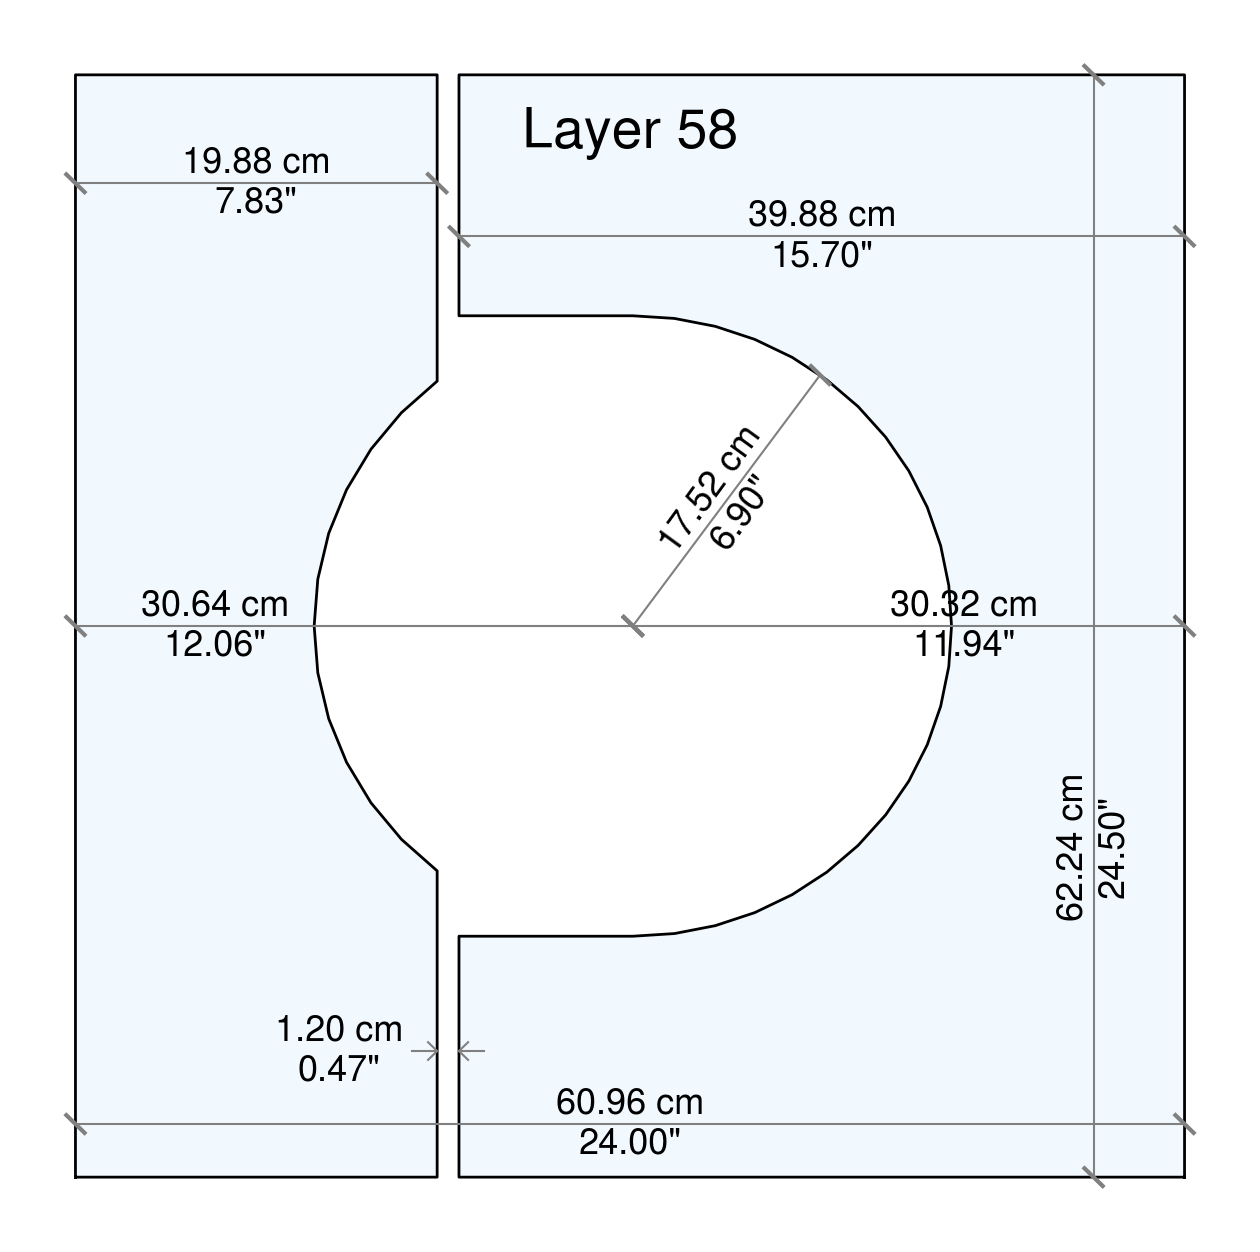

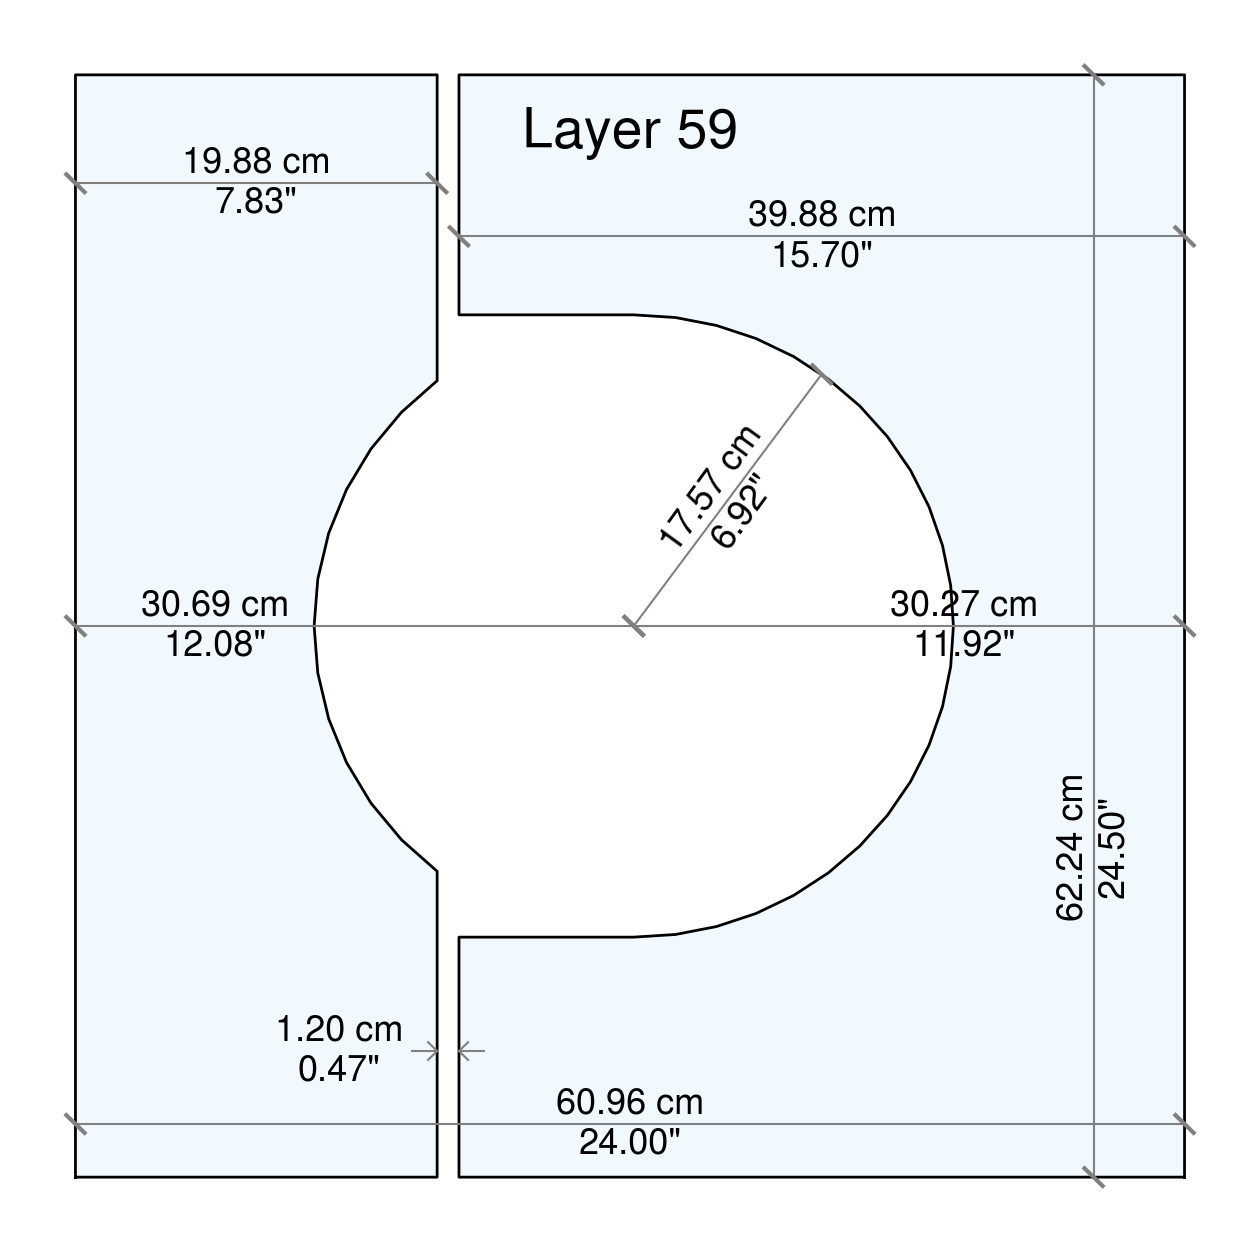

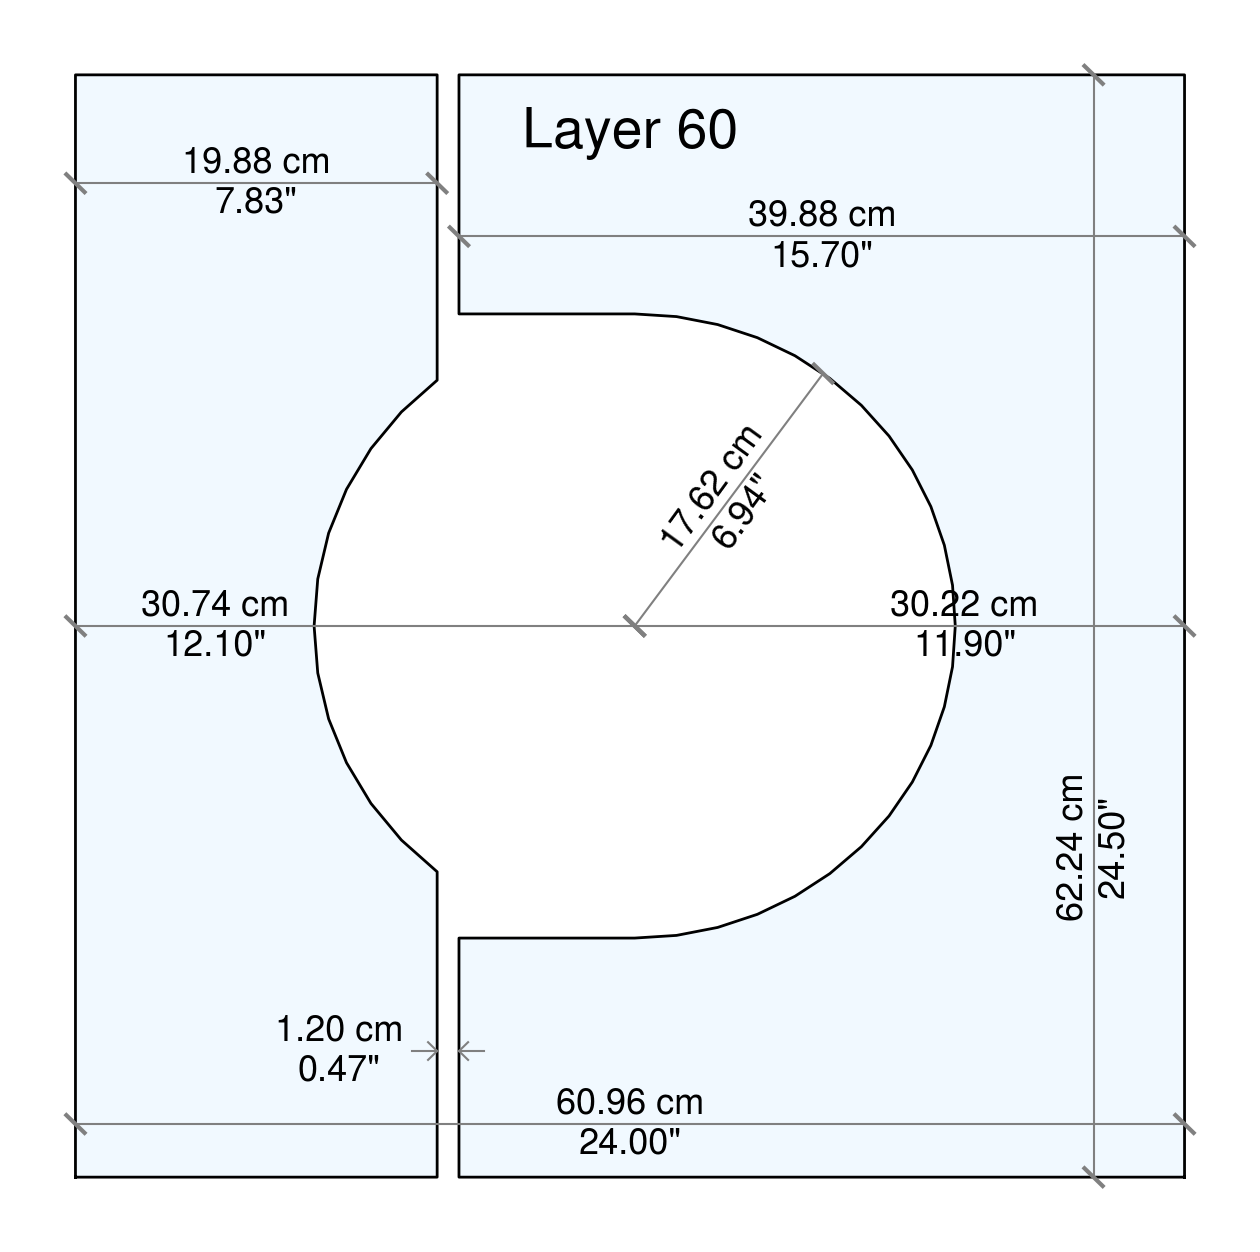

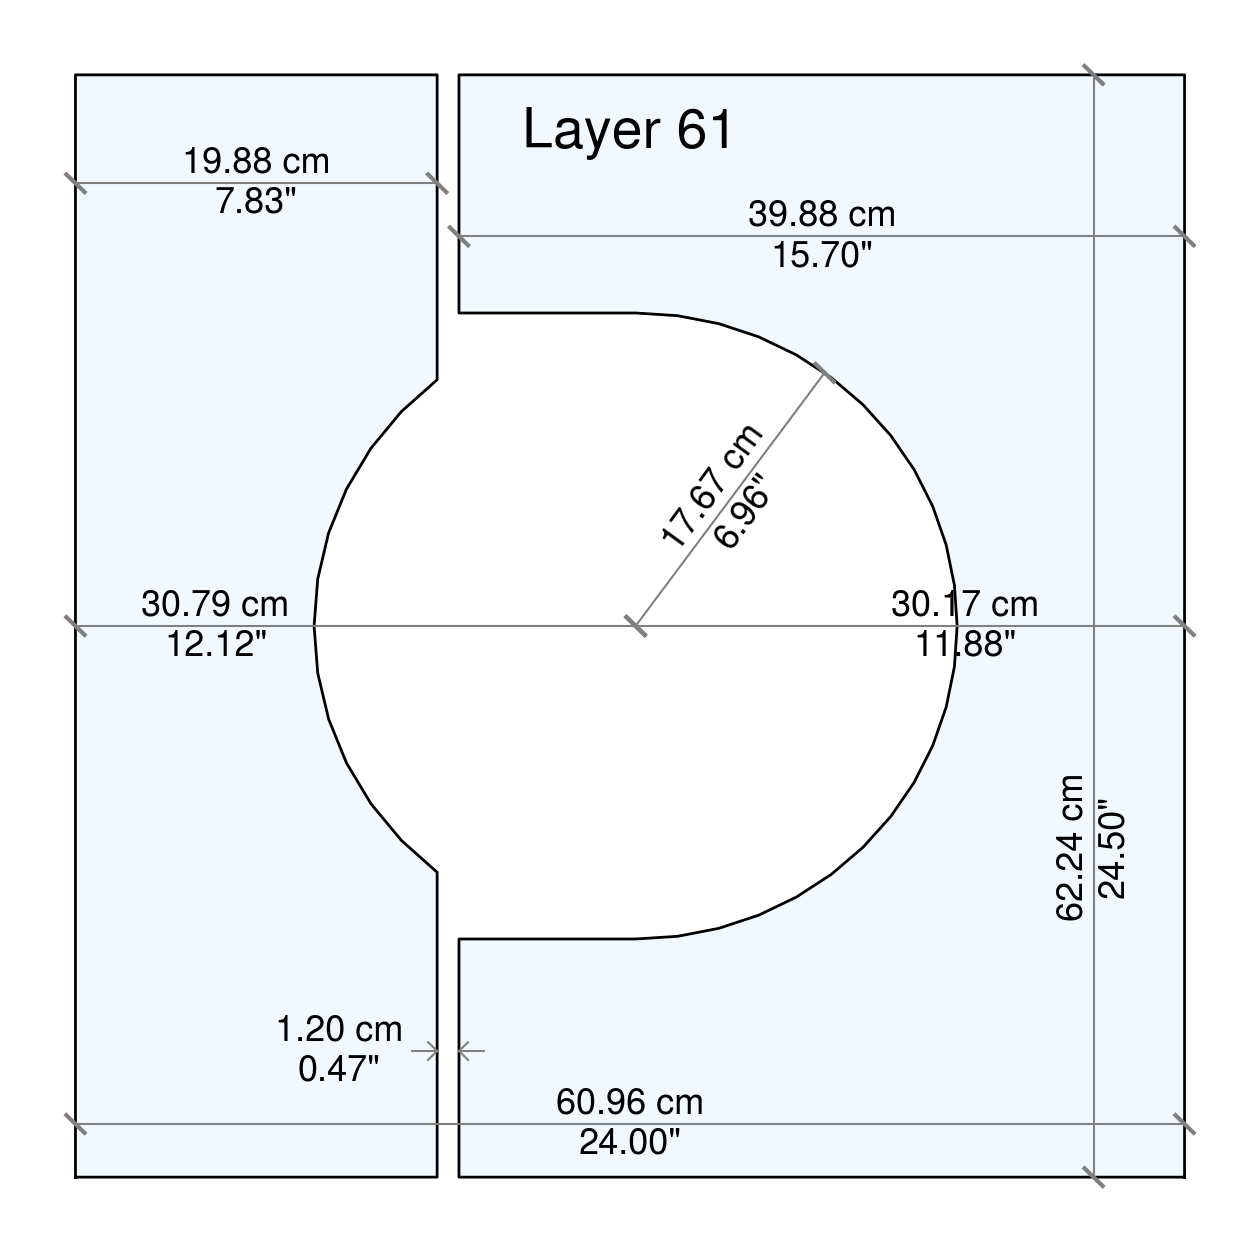

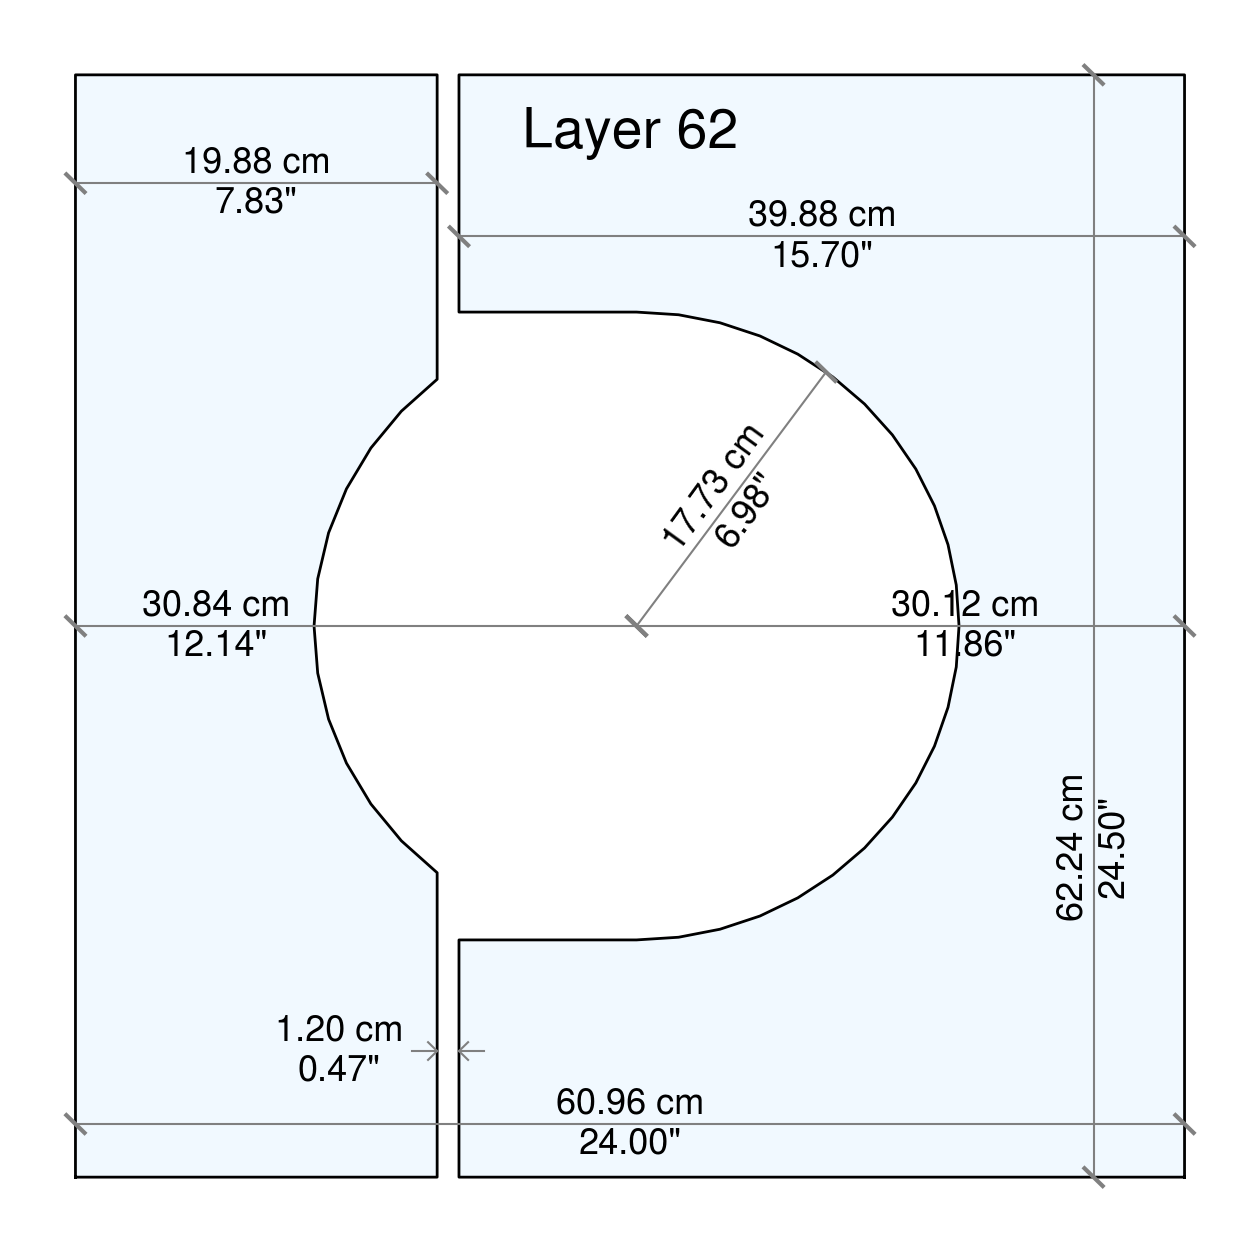

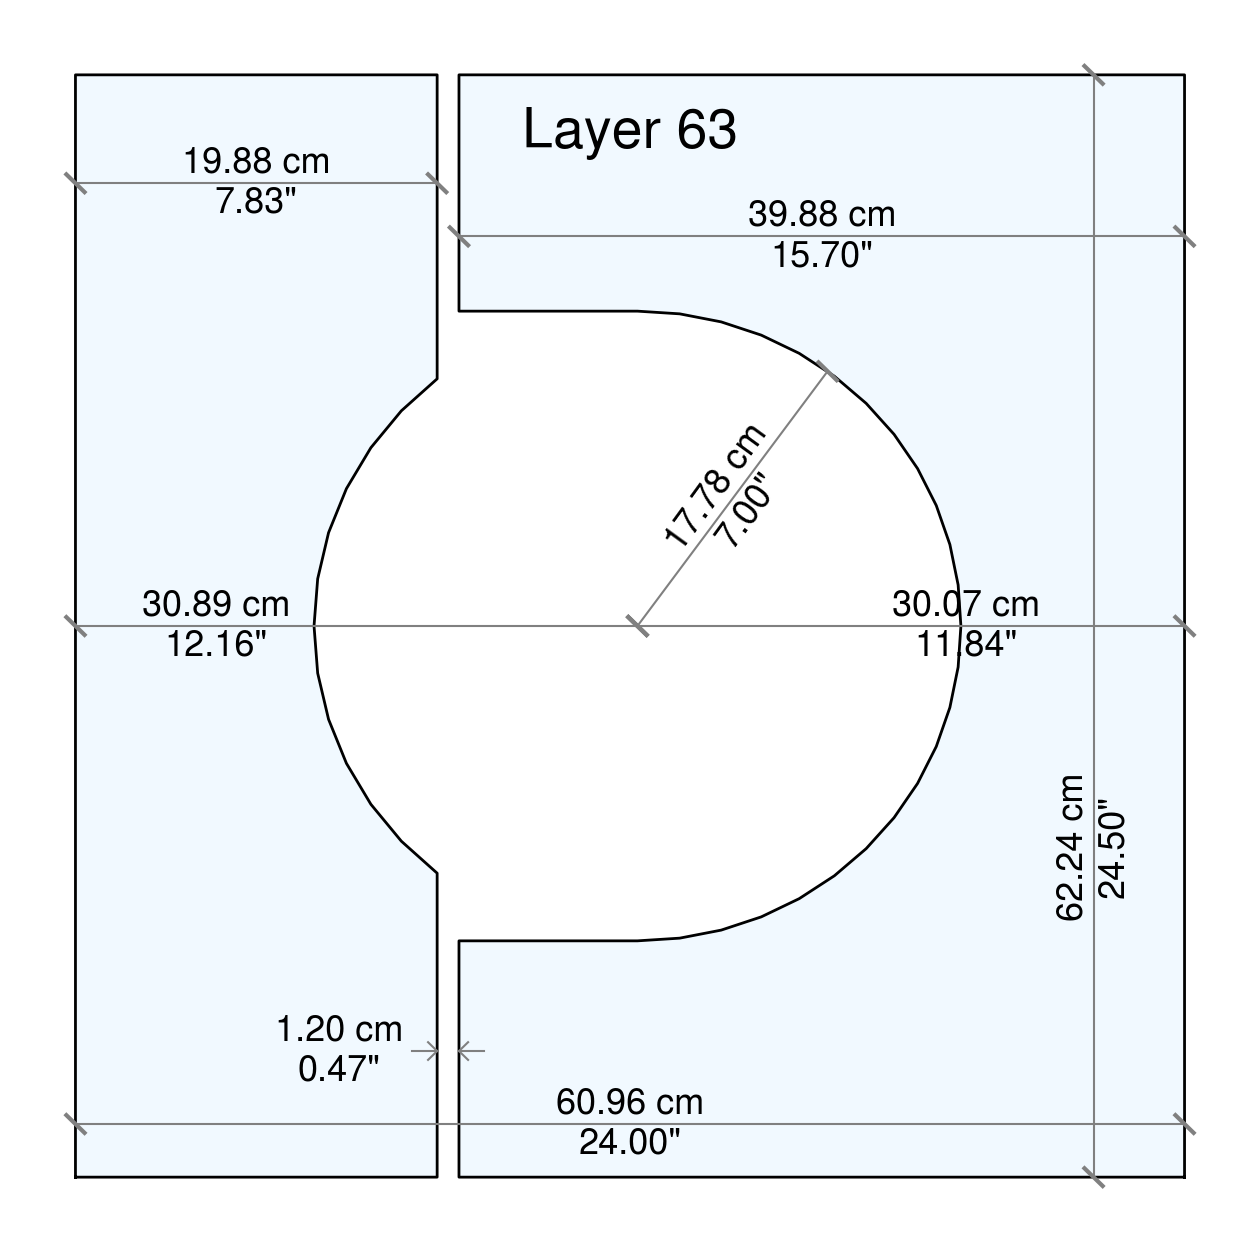

In [9]:
# Now export a multipage document with the engineering designs for all layers
from matplotlib.backends.backend_pdf import PdfPages

# Instantiating PDF document
pdf = PdfPages('all_layers_engineering.pdf')

    
nlayers=dp.n_layers
for i in range(nlayers):
    fig, ax = engineering_diagram(i)
    # Saving figures on pdf pages
    pdf.savefig(fig)
    

# Writting data to the pdf file
pdf.close()

(-1.5, 7.5, -3.0, 5.0)

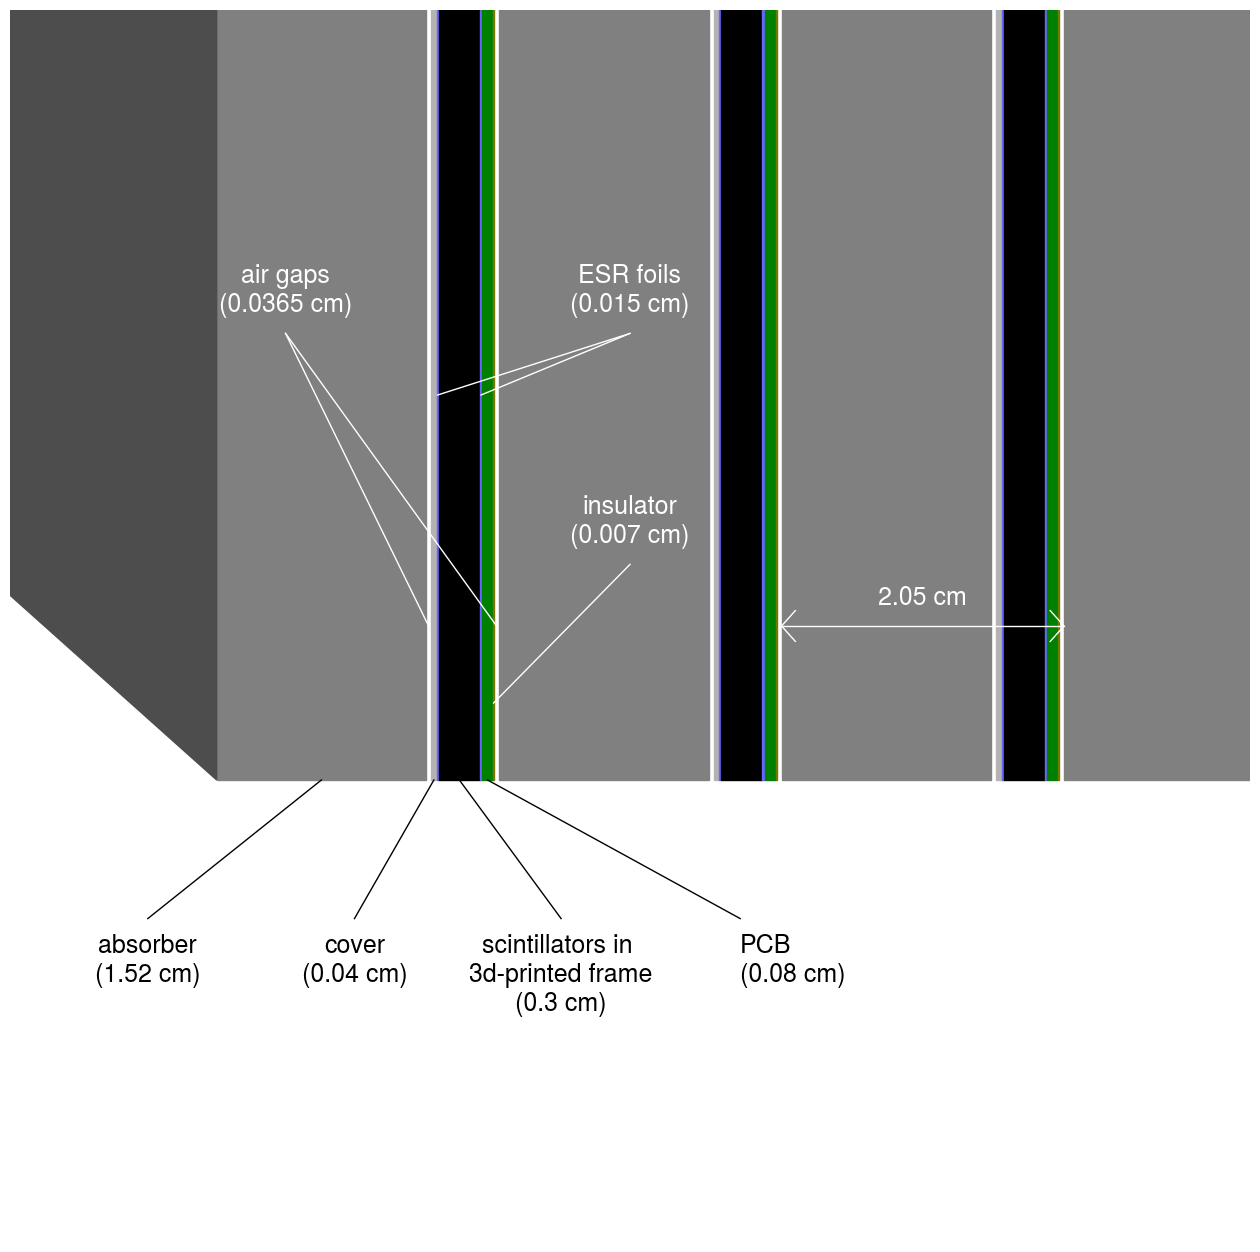

In [12]:
#now draw the longitudinal structure of every layer:
fig,ax=plt.subplots(1,1,figsize=(16,16))
ax.set_xlim(-1.5, 7.5)
ax.set_ylim(-3, 5)

colors='.5','#00000000','.7', '#6666ff', 'k', '#6666ff', 'g', '#777700', '#00000000'

names=['absorber', 'air gaps', 'cover', "ESR foils", "scintillators in \n3d-printed frame", "ESR foils", "PCB",
            "insulator", "air gaps"]

#have similarly labeled components connect to the same position
#text_pos=[0, 1, 2,3.5,4, 3.5,5,6,1]
text_pos=[0, 1, 2,3.5,4, 3.5,5,6,1]
add_label=[1,1,1,1,1,0,1,1,0]
shift_label_up= [0,1,0,1,0,1,0,0.5,1]
ypointto=[0, 1,0,2.5, 0,2.5, 0, .5, 1]
ha=['center']*6+['left']*3
ha[4]='center'
ha[7]='center'
ha[6]='left'
text_pos[2]=1.5
text_pos[4]=3
text_pos[6]=4.3
text_pos[7]=3.5
for i in range(5):
    for j,comp in enumerate(dp.components.values()):
        z,t=comp.z_offset, comp.thickness
        plt.gca().add_patch(mpl.patches.Rectangle((z+dp.coord_thickness*i,0), t,10, color=colors[j]))
        +shift_label_up[j]*4
        if i == 0:
            if not shift_label_up[j]:
                xtxt=-0.5+text_pos[j]*1
                ytxt=-1
            else: 
                xtxt=-0.5+text_pos[j]*1
                ytxt=3*shift_label_up[j]
            plt.plot([z+t/2, xtxt], [ypointto[j], ytxt+(.1 if not shift_label_up[j] else -.1)], 
                     color='k' if not shift_label_up[j] else '1', linewidth=1)
            if add_label[j]:
                args=dict(ha=ha[j], va='top'  if not shift_label_up[j] else 'bottom', rotation=0, fontsize=18)
                if shift_label_up[j]:
                    args['color']='1'
                plt.text(xtxt, ytxt, f"{names[j]}\n({t:3} cm)", **args)
                
#shaded to look 3d
plt.gca().add_patch(mpl.patches.Polygon([[0,0],[-2, 1.6], [-2, 10], [-2, 10], [0, 10]], color='.3'))

args=dict(ha='center', va='bottom', rotation=0, fontsize=18, color='1')

plt.text(2.5*dp.coord_thickness, 1+.1, f"{dp.coord_thickness:.2f} cm", **args)
ct=dp.coord_thickness
args=dict(color='1', linewidth=1)
#arrow indicating the longitudinal dimension
plt.plot([2*ct, 3*ct], [1, 1], **args)
plt.plot(2*ct+.1*np.array([1, 0,1]), 1+.1*np.array([1,0, -1]), **args)
plt.plot(3*ct-.1*np.array([1, 0,1]), 1+.1*np.array([1,0, -1]), **args)
plt.gca().axis('off')

In [11]:
dp.components.keys()

dict_keys(['absorber', 'airgap1', 'cover', 'foil1', 'scint', 'foil2', 'pcb', 'insulator', 'airgap2'])